In [184]:
from datetime import datetime, timedelta
import time
import json
import requests, pandas, lxml
from lxml import html

import numpy as np
import matplotlib.pyplot as plt

import talib as ta

largeFigSize = (16,6)
plt.rcParams["figure.figsize"] = largeFigSize

In [2]:
def format_date(date_datetime):
    date_timetuple = date_datetime.timetuple()
    date_mktime = time.mktime(date_timetuple)
    date_int = int(date_mktime)
    date_str = str(date_int)
    return date_str


def subdomain(symbol, start, end, filter='history'):
    subdoma="/quote/{0}/history?period1={1}&period2={2}&interval=1d&filter={3}&frequency=1d"
    subdomain = subdoma.format(symbol, start, end, filter)
    return subdomain


def header_function(subdomain):
    hdrs = {"authority": "finance.yahoo.com",
            "method": "GET",
            "path": subdomain,
            "scheme": "https",
            "accept": "text/html",
            "accept-encoding": "gzip, deflate, br",
            "accept-language": "en-US,en;q=0.9",
            "cache-control": "no-cache",
            "dnt": "1",
            "pragma": "no-cache",
            "sec-fetch-mode": "navigate",
            "sec-fetch-site": "same-origin",
            "sec-fetch-user": "?1",
            "upgrade-insecure-requests": "1",
            "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64)"}
    return hdrs


def scrape_page(url, header):
    try:
        page = requests.get(url, headers=header)
        element_html = html.fromstring(page.content)
        table = element_html.xpath('//table')
        table_tree = lxml.etree.tostring(table[0], method='xml')
        panda = pandas.read_html(table_tree)
        return panda
    except:
        print("Failed to find page")
        return None
    

In [175]:
datetime.today()-timedelta(days=365)

datetime.datetime(2020, 6, 9, 10, 15, 6, 188741)

In [160]:
def get_stock(symbol='GOOG', latest=datetime.today(), days=365, server_limit=100):
    interval_pair = []
    full_df = []
    
    if days>=server_limit:
        remain = days
        dt_end = latest
        while remain>=server_limit:
            dt_start = dt_end - timedelta(days=server_limit)
            remain -= server_limit
            interval_pair.append([dt_start, dt_end])
            dt_end = dt_start - timedelta(days=1)
        else:
            dt_start = dt_end - timedelta(days=remain)
            interval_pair.append((dt_start, dt_end))
    else:
        dt_start = latest - timedelta(days=days)
        dt_end = latest
        interval_pair.append((dt_start, dt_end))
        
    #print(interval_pair)

    for pair in interval_pair:
        start = format_date(pair[0])
        end = format_date(pair[1])

        sub = subdomain(symbol, start, end)
        header = header_function(sub)

        base_url = 'https://finance.yahoo.com'
        url = base_url + sub
        price_history = scrape_page(url, header)

        try:
            full_df.append(price_history[0])
        except:
            return full_df
    
    return full_df
    


def get_close_price(price_df, days=None):
    if not days:
        days=len(price_df)
    close_price_ls = list(price_df['Close*'][0:days])
    for item in close_price_ls:
        if 'Dividend' in item:
            close_price_ls.remove(item)
            
    close_price = np.flip(np.array(close_price_ls).astype('float'))
    return close_price


def get_high_price(price_df, days=None):
    if not days:
        days=len(price_df)
    high_price_ls = list(price_df['High'][0:days])
    for item in high_price_ls:
        if 'Dividend' in item:
            high_price_ls.remove(item)
            
    high_price = np.flip(np.array(high_price_ls).astype('float'))
    return high_price


def get_low_price(price_df, days=None):
    if not days:
        days=len(price_df)
    low_price_ls = list(price_df['High'][0:days])
    for item in low_price_ls:
        if 'Dividend' in item:
            low_price_ls.remove(item)
            
    low_price = np.flip(np.array(low_price_ls).astype('float'))
    return low_price


In [145]:
def stock_df_postprocess(df_list):
    concat_df = pandas.concat(df_list)
    for item in concat_df['Close*']:
        try:
            float(item)
        except:
            drop_list = concat_df.index[concat_df['Close*']==item].to_list()
            concat_df = concat_df.drop(drop_list)
    
    return concat_df

In [152]:
#Batch download of stock

def batch_download(ticker_list:list(), dump_path="data/", day_length=90):
    N = len(ticker_list)
    missing_list = []
    
    for n in range(N):
        ticker = ticker_list[n]
        print("Downloading [", ticker, "] ...")
        stock_df_list = get_stock(symbol=ticker, days=day_length)
        stock_df = stock_df_postprocess(stock_df_list)
        filename = ticker+'.pkl'
        if isinstance(stock_df, pandas.DataFrame):
            stock_df.to_pickle(dump_path+filename)
        else:
            missing_list.append(stock_no)
            print("[", stock_ticker, "] 404 not found")


In [158]:
tickers = ['TSLA', 'SQ', 'BLK', 'NVDA', 'AMC', 'LEDS', 'BYND', 'RIOT']

batch_download(tickers, dump_path="us_stock/", day_length=365*10)

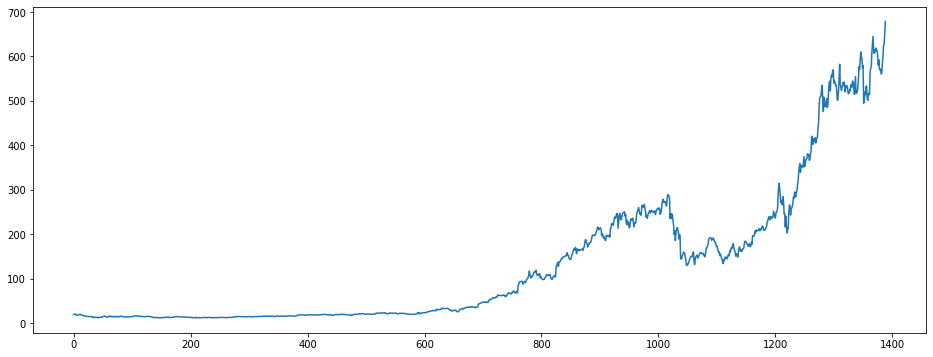

In [173]:
any_df = pandas.read_pickle('us_stock/NVDA.pkl')
any_cp = get_close_price(any_df)
plt.plot(any_cp)

In [136]:
goog_price_history = get_stock(days=365*10)

In [138]:
len(goog_price_history)

37

In [142]:
goog_price_history[0]

Date  \
0                                        Jun 07, 2021   
1                                        Jun 04, 2021   
2                                        Jun 03, 2021   
3                                        Jun 02, 2021   
4                                        Jun 01, 2021   
..                                                ...   
65                                       Mar 04, 2021   
66                                       Mar 03, 2021   
67                                       Mar 02, 2021   
68                                       Mar 01, 2021   
69  *Close price adjusted for splits.**Adjusted cl...   

                                                 Open  \
0                                             2451.32   
1                                             2422.52   
2                                             2395.02   
3                                             2435.31   
4                                             2422.00   
..                                                ...   
65                                            2023.37   
66                                            2067.21   
67                                            2076.19   
68                                            2056.52   
69  *Close price adjusted for splits.**Adjusted cl...   

                                                 High  \
0                                             2468.00   
1                                             2453.86   
2                                             2409.75   
3                                             2442.00   
4                                             2437.97   
..                                                ...   
65                                            2089.24   
66                                            2088.52   
67                                            2104.37   
68                                            2086.52   
69  *Close price adjusted for splits.**Adjusted cl...   

                                                  Low  \
0                                             2441.07   
1                                             2417.77   
2                                             2382.83   
3                                             2404.20   
4                                             2404.88   
..                                                ...   
65                                            2020.27   
66                                            2010.00   
67                                            2071.26   
68                                            2046.10   
69  *Close price adjusted for splits.**Adjusted cl...   

                                               Close*  \
0                                             2466.09   
1                                             2451.76   
2                                             2404.61   
3                                             2421.28   
4                                             2429.81   
..                                                ...   
65                                            2049.09   
66                                            2026.71   
67                                            2075.84   
68                                            2081.51   
69  *Close price adjusted for splits.**Adjusted cl...   

                                          Adj Close**  \
0                                             2466.09   
1                                             2451.76   
2                                             2404.61   
3                                             2421.28   
4                                             2429.81   
..                                                ...   
65                                            2049.09   
66                                            2026.71   
67                                            2075.84   
68                                            2081.51 

In [146]:
goog_df = stock_df_postprocess(goog_price_history)

Date     Open     High      Low   Close* Adj Close**   Volume
0   Jun 07, 2021  2451.32  2468.00  2441.07  2466.09     2466.09  1189600
1   Jun 04, 2021  2422.52  2453.86  2417.77  2451.76     2451.76  1295800
3   Jun 02, 2021  2435.31  2442.00  2404.20  2421.28     2421.28   857900
4   Jun 01, 2021  2422.00  2437.97  2404.88  2429.81     2429.81   958300
5   May 28, 2021  2421.96  2428.14  2407.69  2411.56     2411.56  1205400
6   May 27, 2021  2436.94  2440.00  2402.00  2402.51     2402.51  1948100
7   May 26, 2021  2412.83  2442.94  2412.51  2433.53     2433.53  1092800
8   May 25, 2021  2420.00  2432.89  2402.99  2409.07     2409.07   941900
9   May 24, 2021  2367.00  2418.48  2360.11  2406.67     2406.67  1062200
11  May 20, 2021  2328.04  2360.34  2321.09  2356.09     2356.09  1191600
12  May 19, 2021  2264.40  2316.76  2263.52  2308.71     2308.71   967500
13  May 18, 2021  2336.91  2343.15  2303.16  2303.43     2303.43   865100
14  May 17, 2021  2309.32  2323.34  2295.00  2321.41     2321.41   992100
15  May 14, 2021  2291.83  2321.14  2283.32  2316.16     2316.16  1331200
16  May 13, 2021  2261.09  2276.60  2242.72  2261.97     2261.97  1333500
17  May 12, 2021  2261.71  2285.37  2230.05  2239.08     2239.08  1746700
18  May 11, 2021  2291.86  2322.00  2283.00  2308.76     2308.76  1605500
19  May 10, 2021  2374.89  2378.00  2334.73  2341.66     2341.66  1300300
20  May 07, 2021  2400.00  2416.41  2390.00  2398.69     2398.69  1163600
21  May 06, 2021  2350.64  2382.71  2342.34  2381.35     2381.35  1030900
22  May 05, 2021  2368.42  2382.20  2351.41  2356.74     2356.74  1090300
23  May 04, 2021  2369.74  2379.26  2311.70  2354.25     2354.25  1756000
24  May 03, 2021  2402.72  2419.70  2384.50  2395.17     2395.17  1689400
25  Apr 30, 2021  2404.49  2427.14  2402.16  2410.12     2410.12  1957100
26  Apr 29, 2021  2410.33  2436.52  2402.28  2429.89     2429.89  1977700
27  Apr 28, 2021  2407.15  2452.38  2374.85  2379.91     2379.91  2986400
28  Apr 27, 2021  2336.00  2337.45  2304.27  2307.12     2307.12  1598600
29  Apr 26, 2021  2319.93  2341.26  2313.84  2326.74     2326.74  1041700
30  Apr 23, 2021  2283.47  2325.82  2278.21  2315.30     2315.30  1433500
31  Apr 22, 2021  2293.23  2303.76  2256.45  2267.92     2267.92  1054800
32  Apr 21, 2021  2285.25  2295.32  2258.57  2293.29     2293.29  1196500
33  Apr 20, 2021  2307.89  2309.60  2271.71  2293.63     2293.63  1088700
34  Apr 19, 2021  2291.98  2318.45  2287.84  2302.40     2302.40  1234400
36  Apr 15, 2021  2276.98  2306.60  2266.00  2296.66     2296.66  1373600
37  Apr 14, 2021  2275.16  2277.99  2249.19  2254.84     2254.84  1011000
38  Apr 13, 2021  2261.47  2277.21  2256.09  2267.27     2267.27  1165500
39  Apr 12, 2021  2266.25  2275.32  2238.47  2254.79     2254.79  1565900
40  Apr 09, 2021  2256.70  2289.04  2253.71  2285.88     2285.88  1044400
41  Apr 08, 2021  2277.96  2284.00  2257.68  2265.44     2265.44  1358300
42  Apr 07, 2021  2226.13  2255.00  2225.33  2249.68     2249.68  1289900
43  Apr 06, 2021  2222.50  2237.66  2214.80  2224.75     2224.75  1353000
44  Apr 05, 2021  2152.94  2237.31  2151.62  2225.55     2225.55  2164900
45  Apr 01, 2021  2097.95  2142.94  2096.89  2137.75     2137.75  1699000
46  Mar 31, 2021  2059.12  2093.33  2056.75  2068.63     2068.63  1459900
47  Mar 30, 2021  2057.63  2070.78  2044.03  2055.54     2055.54  1036600
48  Mar 29, 2021  2027.88  2058.43  2015.62  2055.95     2055.95  1229800
49  Mar 26, 2021  2038.86  2050.99  2014.02  2035.55     2035.55  1493500
50  Mar 25, 2021  2044.81  2058.87  2010.73  2044.36     2044.36  1418900
51  Mar 24, 2021  2065.37  2078.21  2041.56  2045.06     2045.06  1154000
52  Mar 23, 2021  2051.70  2072.30  2039.22  2052.96     2052.96  1367000

In [149]:
goog_df.loc[goog_df['Date']=='Apr 27, 2015']

Date    Open    High     Low  Close* Adj Close**   Volume
9  Apr 27, 2015  563.39  565.95  553.20  555.37      555.37  2398000

In [150]:
goog_close_price = np.flip(np.array(goog_df['Adj Close**'][:]).astype('float'))

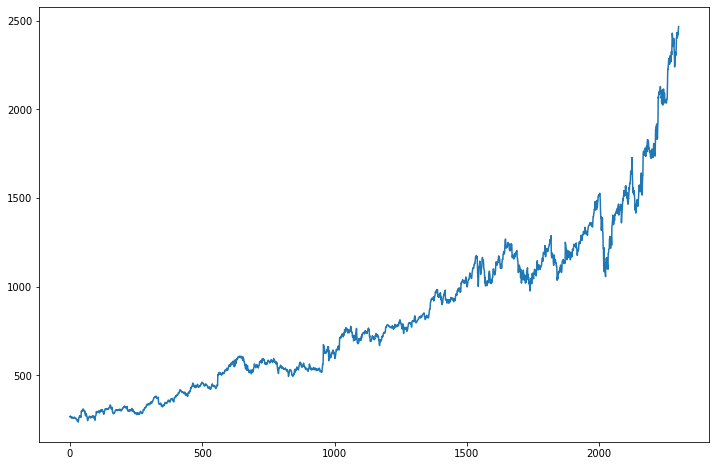

In [151]:
plt.plot(goog_close_price)

In [ ]:
goog_price_history[36].columns

In [42]:
price_df = price_history[0]

In [15]:
price_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [67]:
#Get close price of each day
close_price = np.flip(np.array(price_df['Close*'][0:100]).astype('float'))
print(close_price)

KeyError: 'Close'

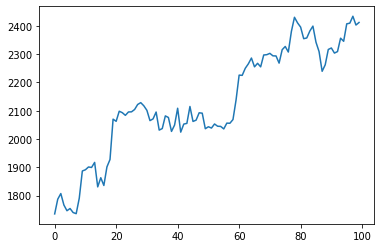

In [44]:
plt.plot(close_price)
plt.show()

In [4]:
def ta_SimpleMovingAverage(data, period=5, order='new2old'):
    if order=='old2new':
        data = np.flip(data)
    elif order=='new2old':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    sma = []
    
    for i in range(0, len(data)-period+1):
        avg = np.mean(data[i:i+period])
        sma.append(avg)
        
    sma = np.array(sma)
    
    if order=='old2new':
        sma = np.flip(sma)
        
    return sma
    
    

In [8]:
period_N = 10
close_price_sma = ta_SimpleMovingAverage(close_price, period=period_N, order='old2new')

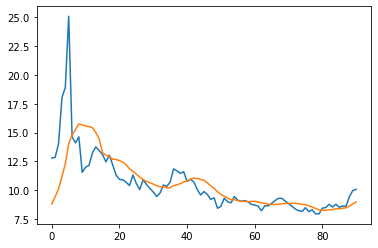

In [9]:
plt.plot(close_price[period_N-1:])
plt.plot(close_price_sma)
plt.show()

In [5]:
def ta_ExponentialMovingAverage(data, smooth=2.0, period=12, order='old2new'):
    if order=='new2old':
        data = np.flip(data)
    elif order=='old2new':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    ema = []
    k = smooth/(1+period)
    eavg_y = np.mean(data[0:period])  #initial EMA
    
    for i in range(period, len(data)):
        eavg = data[i]*k + eavg_y*(1-k)
        eavg_y = eavg
        ema.append(eavg)
        
    ema = np.array(ema)
        
    if order=='new2old':
        ema = np.flip(ema)
    
    return ema


    

In [11]:
close_price_ema = ta_ExponentialMovingAverage(close_price, period=period_N)

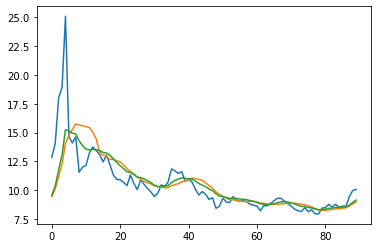

In [12]:
plt.plot(close_price[period_N:])
plt.plot(close_price_sma[1:])
plt.plot(close_price_ema)
plt.show()

In [6]:
def ta_MACD(data, order='old2new'):
    if order=='new2old':
        data = np.flip(data)
    elif order=='old2new':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    ema_12 = ta_ExponentialMovingAverage(data, period=12)
    ema_26 = ta_ExponentialMovingAverage(data, period=26)
    macd = ema_12[14:] - ema_26
    
    if order=='new2old':
        macd = np.flip(macd)
        
    return macd, ema_12, ema_26
    
    

In [14]:
cp_macd, cp_ema_12, cp_ema_26  = ta_MACD(close_price)

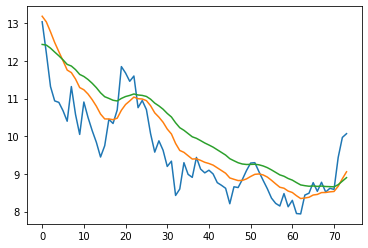

In [16]:
plt.plot(close_price[26:])
plt.plot(cp_ema_12[14:])
plt.plot(cp_ema_26)
plt.show()

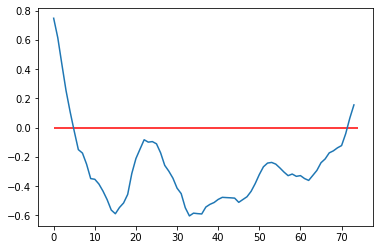

In [17]:
plt.hlines(0, 0, len(cp_macd), color='r')
plt.plot(cp_macd)
plt.show()

In [45]:
macd, macdsignal, macdhist = ta.MACD(close_price)

In [183]:
def plot_MACD(macd, macdsignal, macdhist, figSize=(12, 4)):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figSize)

    skip_nan = np.count_nonzero(np.isnan(macd))
    axes[0].hlines(0, skip_nan, len(macd), color='k', linewidth=1.0, label="baseline")
    axes[0].plot(macd, label="MACD")
    axes[0].plot(macdsignal, linestyle='dashed', label="Signal")
    axes[0].legend(loc="upper right")

    axes[1].hlines(0, skip_nan, len(macd), color='k')
    barlist = axes[1].bar(np.arange(len(macd)), macdhist, align='center', alpha=0.5)
    for i in range(len(macdhist)):
        if np.isnan(macdhist[i]):
            pass
        elif macdhist[i]>0:
            barlist[i].set_color('g')
        else:
            barlist[i].set_color('r')

    plt.show()
    

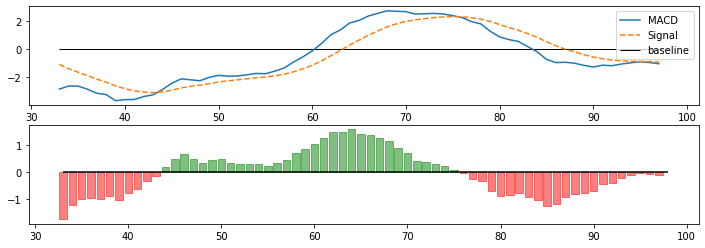

In [10]:
appl_df = get_stock(symbol="AAPL", days=365)
appl_cp = get_close_price(appl_df, days=100)
appl_macd, appl_macdsignal, appl_macdhist = ta.MACD(appl_cp)
plot_MACD(appl_macd, appl_macdsignal, appl_macdhist)

In [141]:
def find_trough_crest(data, diff_rate=0.05, day_filter_size=3):
    low = min(data)
    high = max(data)
    N = len(data)
    
    crest_cand = []
    trough_cand = []
    
    """
    if data[0]>data[1]:
        crest_cand.append(0)
    elif data[0]<data[1]:
        dip_cand.append(0)
    """
    
    #Scan for potential trough/crest
    for i in range(1, N-1):
        if data[i]<data[i-1] and data[i]<data[i+1]:
            trough_cand.append(i)
        elif data[i]>data[i-1] and data[i]>data[i+1]:
            crest_cand.append(i)

    
    trough_cond = low*(1+diff_rate)
    crest_cond = high*(1-diff_rate)
    #print(trough_cond, crest_cond)
    
    crest_filter1 = []
    trough_filter1 = []
    
    #1st filter: negligible amount
    for t in trough_cand:
        if data[t]<=trough_cond:
            trough_filter1.append(t)

    for c in crest_cand:
        if data[c]>=crest_cond:
            crest_filter1.append(c)
            
    
    crest_final = []
    trough_final = []
    
    #2nd filter: days filter
    for t in trough_filter1:
        lo = max(0,t-day_filter_size)
        up = min(N-1, t+day_filter_size)
        subset = data[lo:up+1]
        if len(subset)!=0:
            if min(subset)==data[t]:
                trough_final.append(t)
            
    for c in crest_filter1:
        lo = max(0,c-day_filter_size)
        up = min(N-1, c+day_filter_size)
        subset = data[lo:up+1]
        if len(subset)!=0:
            if max(subset)==data[c]:
                crest_final.append(c)
        
        
    return crest_final, trough_final
    #return crest_cand, trough_cand
    
        


def MACD_divergence(price, watch_window=5):
    macd, macdsignal, macdhist = ta.MACD(price)
    skip_nan = np.count_nonzero(np.isnan(macd))
    
    
        

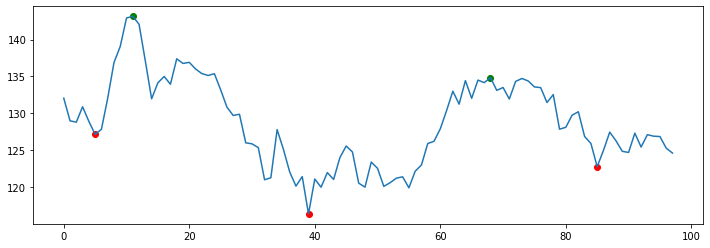

In [143]:
crest, trough = find_trough_crest(appl_cp, diff_rate=0.1, day_filter_size=18)
#print(crest)
#print(trough)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
plt.plot(appl_cp)

for c in crest:
    plt.scatter(c, appl_cp[c], color='g')
    
for t in trough:
    plt.scatter(t, appl_cp[t], color='r')

plt.show()



In [133]:
appl_cp[5]

127.14

In [ ]:
"""
[3, 11, 16, 18, 20, 24, 28, 34, 38, 40, 42, 45, 49, 54, 62, 64, 66, 68, 70, 73, 78, 82, 87, 91, 93]
[2, 5, 17, 23, 32, 39, 43, 51, 63, 67, 71, 79, 90]
"""

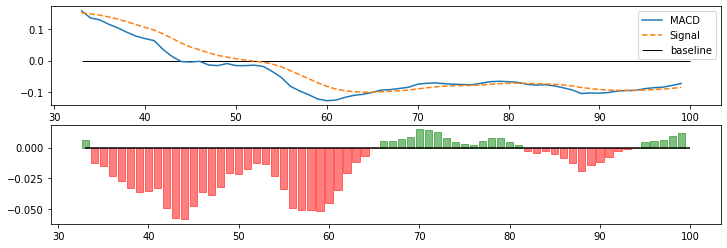

In [11]:
hk0546_df = get_stock(symbol="0546.HK", days=365)
hk0546_cp = get_close_price(hk0546_df, days=100)
hk0546_macd, hk0546_macdsignal, hk0546_macdhist = ta.MACD(hk0546_cp)
plot_MACD(hk0546_macd, hk0546_macdsignal, hk0546_macdhist)

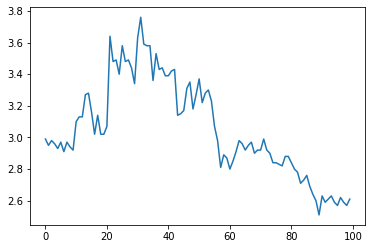

In [145]:
plt.plot(hk0546_cp)

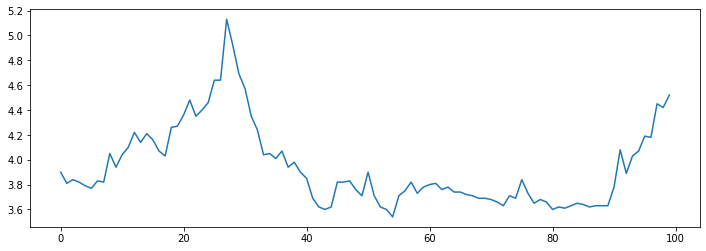

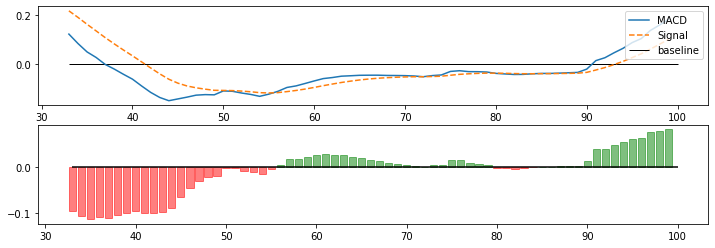

In [46]:
hk1119_df = get_stock(symbol="1119.HK", days=365)
hk1119_cp = get_close_price(hk1119_df, days=100)
hk1119_macd, hk1119_macdsignal, hk1119_macdhist = ta.MACD(hk1119_cp)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
plt.plot(hk1119_cp)
plot_MACD(hk1119_macd, hk1119_macdsignal, hk1119_macdhist)

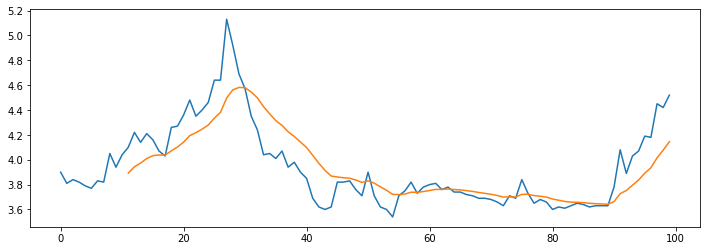

In [47]:
hk1119_ma = ta.EMA(hk1119_cp, timeperiod=12)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
plt.plot(hk1119_cp)
plt.plot(hk1119_ma)

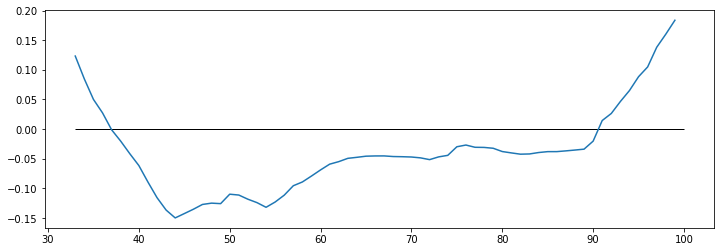

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
skip_nan = np.count_nonzero(np.isnan(hk1119_macd))
plt.plot(hk1119_macd)
plt.hlines(0, skip_nan, len(hk1119_macd), color='k', linewidth=1.0, label="baseline")

In [210]:
def compare_price_MACD(price, macd, ema_period=12, confid=0.8, min_day=5, results="MAX"):
    N = len(macd)
    price_avg = ta.EMA(price, timeperiod=ema_period)
    pair_period = []
    pair_score = []
    pair_pattern = []
    price_trend = []
    
    for n in range(1, N-min_day):
        K = n+min_day
        
        if K>=N:
            pass
        else:
            
            while K<N:
                
                match = []
                price_mov = []
                for i in range(n, K):
                    if np.isnan(macd[i-1]) or np.isnan(price_avg[i-1]):
                        pass
                    else:
                        macd_dir = macd[i]>macd[i-1]
                        price_dir = price_avg[i]>price_avg[i-1]
                        div = macd_dir!=price_dir
                        match.append(int(div))
                        price_mov.append(price_dir)
                        
                if len(match)>min_day:
                    match_score = float(np.sum(np.array(match)))/len(match)
                    #print(match_score)
                    pair_period.append((n,K-1))
                    pair_score.append(match_score)
                    pair_pattern.append(match.copy())
                    price_trend.append(price_mov.count(True)>price_mov.count(False))
                    
                K+=1

    max_index = pair_score.index(max(pair_score))
    
    if results=="FULL":
        return pair_period, pair_score, pair_pattern, price_trend
    else:
        return pair_period[max_index], pair_score[max_index], pair_pattern[max_index], price_trend[max_index]
    

In [ ]:
def compare_price_MACD_2(price, macd, ema_period=12, confid=0.8, min_day=5, results="MAX"):
    N = len(macd)
    price_avg = ta.EMA(price, timeperiod=ema_period)
    pair_period = []
    pair_score = []
    pair_pattern = []
    price_trend = []
    
    for n in range(1, N-min_day):
        K = n+min_day
        
        if K>=N:
            pass
        else:
            
            while K<N:
                
                match = []
                price_mov = []
                for i in range(n, K):
                    if np.isnan(macd[i-1]) or np.isnan(price_avg[i-1]):
                        pass
                    else:
                        macd_dir = macd[i]>macd[i-1]
                        price_dir = price_avg[i]>price_avg[i-1]
                        div = macd_dir!=price_dir
                        match.append(int(div))
                        price_mov.append(price_dir)
                        
                if len(match)>min_day:
                    match_score = float(np.sum(np.array(match)))/len(match)
                    #print(match_score)
                    pair_period.append((n,K-1))
                    pair_score.append(match_score)
                    pair_pattern.append(match.copy())
                    price_trend.append(price_mov.count(True)>price_mov.count(False))
                    
                K+=1

    max_index = pair_score.index(max(pair_score))
    
    if results=="FULL":
        return pair_period, pair_score, pair_pattern, price_trend
    else:
        return pair_period[max_index], pair_score[max_index], pair_pattern[max_index], price_trend[max_index]
    

(52, 67) 0.8125
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
False


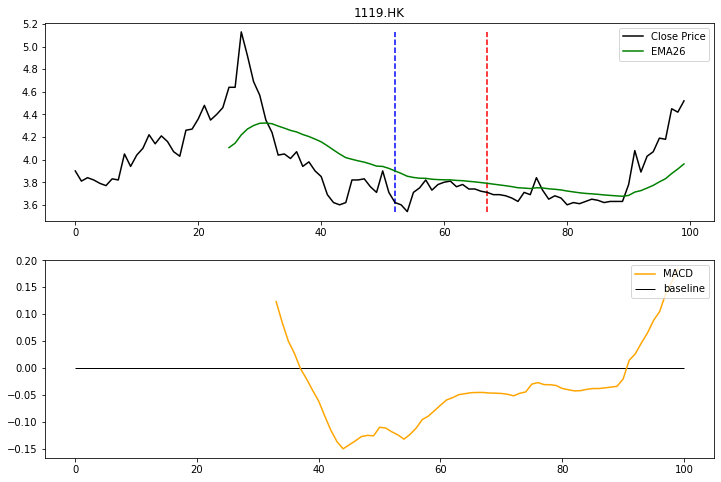

In [56]:
ema_period = 26
hk1119_ema = ta.EMA(hk1119_cp, timeperiod=ema_period)
period, score, pattern, trend = compare_price_MACD(hk1119_cp, hk1119_macd, ema_period=ema_period, min_day=15)

print(period, score)
print(pattern)
print(trend)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

axes[0].set_title("1119.HK")
axes[0].plot(hk1119_cp, color='k', label="Close Price")
axes[0].plot(hk1119_ema, color='g', label="EMA26")
axes[0].vlines(period[0], hk1119_cp.min(), hk1119_cp.max(), color='b', linestyle='dashed')
axes[0].vlines(period[1], hk1119_cp.min(), hk1119_cp.max(), color='r', linestyle='dashed')
axes[0].legend(loc="upper right")

axes[1].plot(hk1119_macd, color='orange', label='MACD')
axes[1].hlines(0, 0, len(hk1119_macd), color='k', linewidth=1.0, label="baseline")
axes[1].legend(loc="upper right")

In [58]:
def plot_MACD_div(fname, title, cp, ema, macd, period=(0,1), line_length=(1,1)):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

    axes[0].set_title(title)
    axes[0].plot(cp, color='k', label="Close Price")
    axes[0].plot(ema, color='g', label="EMA26")
    axes[0].vlines(period[0], line_length[0], line_length[1], color='b', linestyle='dashed')
    axes[0].vlines(period[1], line_length[0], line_length[1], color='r', linestyle='dashed')
    axes[0].legend(loc="upper right")

    axes[1].plot(macd, color='orange', label='MACD')
    axes[1].hlines(0, 0, len(macd), color='k', linewidth=1.0, label="baseline")
    axes[1].legend(loc="upper right")
    
    plt.savefig(fname)
    

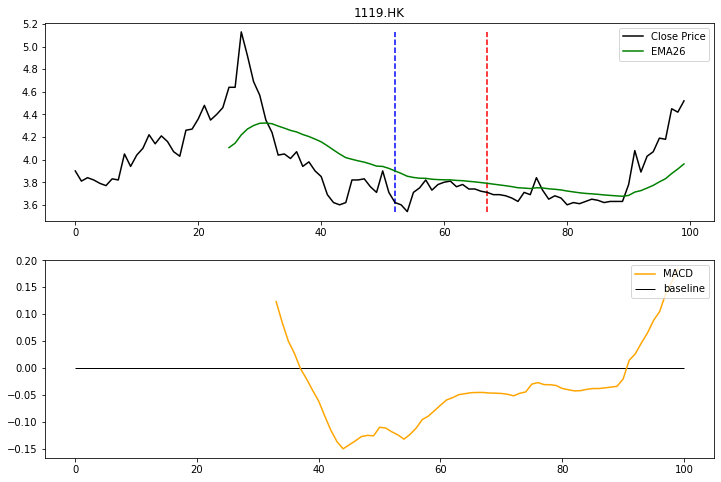

In [61]:
plot_MACD_div("hk1119.jpg", "1119.HK", hk1119_cp, hk1119_ema, hk1119_macd, period, (hk1119_cp.min(), hk1119_cp.max()))

In [222]:
True!=False

True

In [162]:
hk1119_hp = get_high_price(hk1119_df, days=100)
hk1119_lp = get_low_price(hk1119_df, days=100)

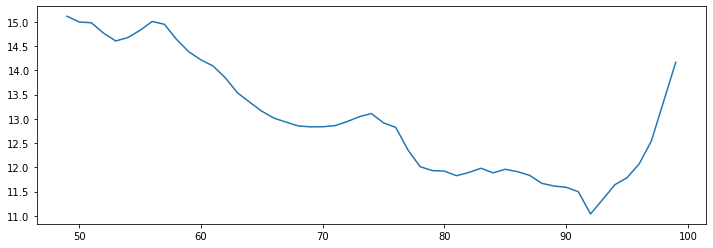

In [174]:
hk1119_dir = ta.ADX(hk1119_hp, hk1119_lp, hk1119_cp, timeperiod=25)
plt.plot(hk1119_dir)

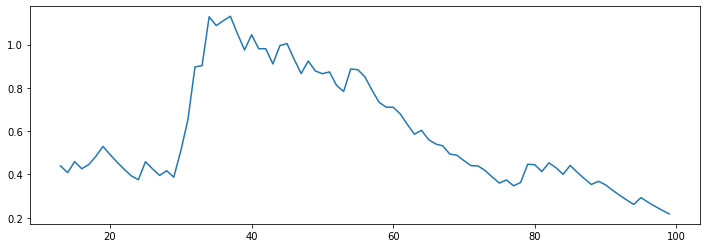

In [176]:
hk1119_mindm = ta.MINUS_DM(hk1119_hp, hk1119_lp, timeperiod=14)
plt.plot(hk1119_mindm)

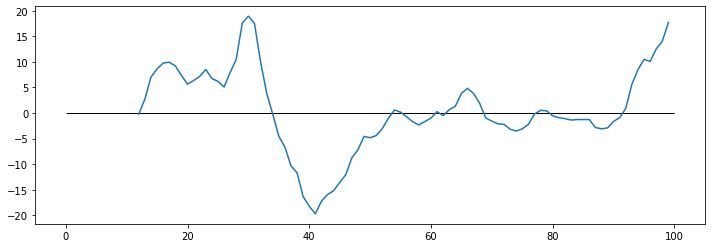

In [186]:
hk1119_roc = ta.MA(ta.ROC(hk1119_cp, timeperiod=10), timeperiod=3)
plt.hlines(0, 0, len(hk1119_roc), color='k', linewidth=1.0, label="baseline")
plt.plot(hk1119_roc)

In [33]:
any_df = get_stock(symbol="80737.HK", days=365)
any_df

Date  \
0                                         May 31, 2021   
1                                         May 28, 2021   
2                                         May 27, 2021   
3                                         May 26, 2021   
4                                         May 25, 2021   
..                                                 ...   
96                                        Jan 07, 2021   
97                                        Jan 06, 2021   
98                                        Jan 05, 2021   
99                                        Jan 04, 2021   
100  *Close price adjusted for splits.**Adjusted cl...   

                                                  Open  \
0                                                2.490   
1                                                2.490   
2                                                2.450   
3                                                2.500   
4                                                2.500   
..                                                 ...   
96                                               2.450   
97                                               2.450   
98                                               2.250   
99                                               2.230   
100  *Close price adjusted for splits.**Adjusted cl...   

                                                  High  \
0                                                2.500   
1                                                2.490   
2                                                2.500   
3                                                2.500   
4                                                2.500   
..                                                 ...   
96                                               2.500   
97                                               2.450   
98                                               2.360   
99                                               2.250   
100  *Close price adjusted for splits.**Adjusted cl...   

                                                   Low  \
0                                                2.490   
1                                                2.440   
2                                                2.420   
3                                                2.500   
4                                                2.500   
..                                                 ...   
96                                               2.380   
97                                               2.450   
98                                               2.250   
99                                               2.190   
100  *Close price adjusted for splits.**Adjusted cl...   

                                                Close*  \
0                                                2.500   
1                                                2.480   
2                                                2.430   
3                                                2.500   
4                                                2.500   
..                                                 ...   
96                                               2.410   
97                                               2.450   
98                                               2.360   
99                                               2.250   
100  *Close price adjusted for splits.**Adjusted cl...   

                                           Adj Close**  \
0                                                2.500   
1                                                2.480   
2                                                2.430   
3                                                2.500   
4                                                2.500   
..                                                 ...   
96                                               2.410   
97                                               2.450   
98                                         

In [24]:
any_df["Open"][100]

'*Close price adjusted for splits.**Adjusted close price adjusted for both dividends and splits.'

In [23]:
any_df["Close*"][100]

'*Close price adjusted for splits.**Adjusted close price adjusted for both dividends and splits.'

In [30]:
hk1119_df.to_pickle("data/hk1119.pkl")

In [34]:
read_back = pandas.read_pickle("data/hk3413.pkl")
read_back

Symbol             Name  Last Price Industry / Category    Type Exchange
0  3913.HK       KWG LIVING        8.26         Real Estate  Stocks      HKG
1  3313.HK   ARTGO HOLDINGS        0.07         Industrials  Stocks      HKG
2  1413.HK   KWONG LUEN ENG        0.34         Industrials  Stocks      HKG
3  8413.HK     ASIA GROCERY        0.30  Consumer Defensive  Stocks      HKG
4  3813.HK  POU SHENG INT'L        1.90   Consumer Cyclical  Stocks      HKG
5  0413.HK      SC HOLDINGS        0.12   Consumer Cyclical  Stocks      HKG
6  3613.HK    TONGRENTANGCM       13.08          Healthcare  Stocks      HKG
7  3143.HK     CAM HK BANKS        7.69                 NaN  Stocks      HKG
8  3013.HK          3013.HK       14.56                 NaN  Stocks      HKG

In [32]:
stock_ticker = str(5).zfill(4)+'.HK'
print(stock_ticker)

0005.HK


In [72]:
stock_list_src = pandas.read_excel("ListOfSecurities.xls")
stock_list_src.rename(columns=stock_list_src.iloc[1], inplace=True)
stock_list_src = stock_list_src.drop([0,1])
stock_list_src

Stock Code Name of Securities                       Category  \
2          00001       CKH HOLDINGS                         Equity   
3          00002       CLP HOLDINGS                         Equity   
4          00003     HK & CHINA GAS                         Equity   
5          00004     WHARF HOLDINGS                         Equity   
6          00005      HSBC HOLDINGS                         Equity   
...          ...                ...                            ...   
18493      86655        PRC B2106-R                Debt Securities   
18494      86656        PRC B2406-R                Debt Securities   
18495      86657        PRC B2207-R                Debt Securities   
18496      86658        PRC B2507-R                Debt Securities   
18497      87001      HUI XIAN REIT  Real Estate Investment Trusts   

                         Sub-Category Board Lot   Par Value          ISIN  \
2      Equity Securities (Main Board)       500  HKD 1.0000  KYG217651051   
3      Equity Securities (Main Board)       500         NaN  HK0002007356   
4      Equity Securities (Main Board)     1,000         NaN  HK0003000038   
5      Equity Securities (Main Board)     1,000         NaN  HK0004000045   
6      Equity Securities (Main Board)       400  USD 0.5000  GB0005405286   
...                               ...       ...         ...           ...   
18493                             NaN     5,000         NaN  HK0000511102   
18494                             NaN     5,000         NaN  HK0000511110   
18495                             NaN     5,000         NaN  HK0000622438   
18496                             NaN     5,000         NaN  HK0000622446   
18497                             NaN     1,000         NaN  HK0000078516   

      Expiry Date Subject to Stamp Duty Shortsell Eligible CAS Eligible  \
2             NaN                     Y                  Y            Y   
3             NaN                     Y                  Y            Y   
4             NaN                     Y                  Y            Y   
5             NaN                     Y                  Y            Y   
6             NaN                     Y                  Y            Y   
...           ...                   ...                ...          ...   
18493  24/06/2021                   NaN                NaN          NaN   
18494  24/06/2024                   NaN                NaN          NaN   
18495  27/07/2022                   NaN                NaN          NaN   
18496  27/07/2025                   NaN                NaN          NaN   
18497         NaN                     Y                  Y            Y   

      VCM Eligible Admitted to Stock Options Admitted to Stock Futures  \
2                Y                         Y                         Y   
3                Y                         Y                         Y   
4                Y                         Y                         Y   
5                Y                         Y                         Y   
6                Y                         Y                         Y   
...            ...                       ...                       ...   
18493          NaN                       NaN                       NaN   
18494          NaN                       NaN                       NaN   
18495          NaN                       NaN                       NaN   
18496          NaN                       NaN                       NaN   
18497          NaN                       NaN                       NaN   

      Admitted to CCASS              ETF / Fund Manager  \
2                     Y                             NaN   
3                     Y                             NaN   
4                     Y                             NaN   
5                     Y                             NaN   
6                     Y                             NaN   
...                 ...                             ...   
18493                 Y              

In [65]:
stock_list_src.columns

Index(['Stock Code', 'Name of Securities', 'Category', 'Sub-Category',
       'Board Lot', 'Par Value', 'ISIN', 'Expiry Date',
       'Subject to Stamp Duty', 'Shortsell Eligible', 'CAS Eligible',
       'VCM Eligible', 'Admitted to Stock Options',
       'Admitted to Stock Futures', 'Admitted to CCASS', 'ETF / Fund Manager',
       'Debt Securities Board Lot (Nominal)', 'Debt Securities Investor Type',
       'POS Eligble', 'Spread Table\n1, 4 = Part A\n3 = Part B\n5 = Part D'],
      dtype='object')

In [29]:
stock_ticker_list = list(stock_list_src['Stock Code'])

In [30]:
#Save HKEX ticker list to file
import json
with open('hkex_ticker.json', 'w') as f:
    json.dump(stock_ticker_list, f)


In [71]:
stock_list_src['Category'][2]

'Equity'

In [42]:
s = 2943
N = len(stock_list_src)
missing_list = []
dump_path = "data/"

for n in range(s,N):
    stock_no = int(stock_list_src['Stock Code'][n])
    if stock_list_src['Category'][n]=='Equity':
        stock_ticker = str(stock_no).zfill(4)+'.HK'
        stock_df = get_stock(symbol=stock_ticker, days=365)
        filename = "hk"+str(stock_no).zfill(4)+'.pkl'
        if isinstance(stock_df, pandas.DataFrame):
            stock_df.to_pickle(dump_path+filename)
        else:
            missing_list.append(stock_no)
            print(stock_ticker, "404 not found")


In [74]:
def hkex_macd_div(s, N, hkex_df, src_path="data/", str_path="macd_div_results/", threshold=0.8, ema_period=26, min_day=15):
    results_summary = []
    for n in range(s, N):
        valid_stock = hkex_df['Category'][n]=='Equity'

        if valid_stock:
            stock_no = int(hkex_df['Stock Code'][n])
            stock_ticker = str(stock_no).zfill(4)+'.HK'
            filename = "hk"+str(stock_no).zfill(4)
            try:
                stock_df = pandas.read_pickle(dump_path+filename+'.pkl')
                stock_cp = get_close_price(stock_df, days=100)
                macd, macdsignal, macdhist = ta.MACD(stock_cp)
                ema = ta.EMA(stock_cp, timeperiod=ema_period)
                div_period, score, pattern, trend = compare_price_MACD(stock_cp, macd, 
                                                                       ema_period=ema_period, min_day=min_day)
                if score>=threshold:
                    suffix = "_neg" if trend else "_pos"
                    path = "neg_div/" if trend else "pos_div/"
                    plot_fname = str_path+path+filename+suffix+".jpg"
                    plot_MACD_div(plot_fname, stock_ticker, 
                                  stock_cp, ema, macd, div_period, (stock_cp.min(), stock_cp.max()))
                    results_summary.append([stock_no, div_period, score, trend])
            except:
                print("Failed to analyze stock ", stock_ticker)
    
    with open('hkex_macd_div.json', 'w') as f:
        json.dump(results_summary, f)
            
            
        

Failed to analyze stock  0067.HK
Failed to analyze stock  0110.HK


/home/bwan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Failed to analyze stock  0115.HK
Failed to analyze stock  0136.HK
Failed to analyze stock  0155.HK
Failed to analyze stock  0172.HK
Failed to analyze stock  0183.HK
Failed to analyze stock  0254.HK
Failed to analyze stock  0307.HK
Failed to analyze stock  0362.HK
Failed to analyze stock  0363.HK
Failed to analyze stock  0364.HK
Failed to analyze stock  0365.HK
Failed to analyze stock  0366.HK
Failed to analyze stock  0367.HK
Failed to analyze stock  0368.HK
Failed to analyze stock  0369.HK
Failed to analyze stock  0370.HK
Failed to analyze stock  0378.HK
Failed to analyze stock  0381.HK
Failed to analyze stock  0382.HK
Failed to analyze stock  0383.HK
Failed to analyze stock  0384.HK
Failed to analyze stock  0385.HK
Failed to analyze stock  0386.HK
Failed to analyze stock  0387.HK
Failed to analyze stock  0388.HK
Failed to analyze stock  0389.HK
Failed to analyze stock  0390.HK
Failed to analyze stock  0391.HK
Failed to analyze stock  0392.HK
Failed to analyze stock  0393.HK
Failed to 

Failed to analyze stock  0697.HK
Failed to analyze stock  0698.HK
Failed to analyze stock  0699.HK
Failed to analyze stock  0700.HK
Failed to analyze stock  0701.HK
Failed to analyze stock  0702.HK
Failed to analyze stock  0703.HK
Failed to analyze stock  0704.HK
Failed to analyze stock  0706.HK
Failed to analyze stock  0707.HK
Failed to analyze stock  0708.HK
Failed to analyze stock  0709.HK
Failed to analyze stock  0710.HK
Failed to analyze stock  0711.HK
Failed to analyze stock  0712.HK
Failed to analyze stock  0713.HK
Failed to analyze stock  0715.HK
Failed to analyze stock  0716.HK
Failed to analyze stock  0717.HK
Failed to analyze stock  0718.HK
Failed to analyze stock  0719.HK
Failed to analyze stock  0720.HK
Failed to analyze stock  0721.HK
Failed to analyze stock  0722.HK
Failed to analyze stock  0723.HK
Failed to analyze stock  0724.HK
Failed to analyze stock  0725.HK
Failed to analyze stock  0726.HK
Failed to analyze stock  0727.HK
Failed to analyze stock  0728.HK
Failed to 

Failed to analyze stock  1262.HK
Failed to analyze stock  1263.HK
Failed to analyze stock  1265.HK
Failed to analyze stock  1266.HK
Failed to analyze stock  1268.HK
Failed to analyze stock  1269.HK
Failed to analyze stock  1270.HK
Failed to analyze stock  1271.HK
Failed to analyze stock  1272.HK
Failed to analyze stock  1273.HK
Failed to analyze stock  1277.HK
Failed to analyze stock  1278.HK
Failed to analyze stock  1280.HK
Failed to analyze stock  1281.HK
Failed to analyze stock  1282.HK
Failed to analyze stock  1283.HK
Failed to analyze stock  1285.HK
Failed to analyze stock  1286.HK
Failed to analyze stock  1288.HK
Failed to analyze stock  1289.HK
Failed to analyze stock  1290.HK
Failed to analyze stock  1292.HK
Failed to analyze stock  1293.HK
Failed to analyze stock  1296.HK
Failed to analyze stock  1297.HK
Failed to analyze stock  1308.HK
Failed to analyze stock  1310.HK
Failed to analyze stock  1312.HK
Failed to analyze stock  1313.HK
Failed to analyze stock  1314.HK
Failed to 

Failed to analyze stock  1741.HK
Failed to analyze stock  1742.HK
Failed to analyze stock  1743.HK
Failed to analyze stock  1745.HK
Failed to analyze stock  1746.HK
Failed to analyze stock  1747.HK
Failed to analyze stock  1748.HK
Failed to analyze stock  1749.HK
Failed to analyze stock  1750.HK
Failed to analyze stock  1751.HK
Failed to analyze stock  1752.HK
Failed to analyze stock  1753.HK
Failed to analyze stock  1755.HK
Failed to analyze stock  1756.HK
Failed to analyze stock  1757.HK
Failed to analyze stock  1758.HK
Failed to analyze stock  1759.HK
Failed to analyze stock  1760.HK
Failed to analyze stock  1761.HK
Failed to analyze stock  1762.HK
Failed to analyze stock  1763.HK
Failed to analyze stock  1765.HK
Failed to analyze stock  1766.HK
Failed to analyze stock  1767.HK
Failed to analyze stock  1769.HK
Failed to analyze stock  1771.HK
Failed to analyze stock  1772.HK
Failed to analyze stock  1773.HK
Failed to analyze stock  1775.HK
Failed to analyze stock  1776.HK
Failed to 

Failed to analyze stock  2126.HK
Failed to analyze stock  2127.HK
Failed to analyze stock  2128.HK
Failed to analyze stock  2129.HK
Failed to analyze stock  2130.HK
Failed to analyze stock  2131.HK
Failed to analyze stock  2132.HK
Failed to analyze stock  2133.HK
Failed to analyze stock  2135.HK
Failed to analyze stock  2136.HK
Failed to analyze stock  2138.HK
Failed to analyze stock  2139.HK
Failed to analyze stock  2142.HK
Failed to analyze stock  2146.HK
Failed to analyze stock  2148.HK
Failed to analyze stock  2153.HK
Failed to analyze stock  2156.HK
Failed to analyze stock  2158.HK
Failed to analyze stock  2159.HK
Failed to analyze stock  2160.HK
Failed to analyze stock  2161.HK
Failed to analyze stock  2163.HK
Failed to analyze stock  2166.HK
Failed to analyze stock  2168.HK
Failed to analyze stock  2169.HK
Failed to analyze stock  2170.HK
Failed to analyze stock  2176.HK
Failed to analyze stock  2178.HK
Failed to analyze stock  2180.HK
Failed to analyze stock  2181.HK
Failed to 

Failed to analyze stock  3898.HK
Failed to analyze stock  3899.HK
Failed to analyze stock  3900.HK
Failed to analyze stock  3903.HK
Failed to analyze stock  3908.HK
Failed to analyze stock  3913.HK
Failed to analyze stock  3918.HK
Failed to analyze stock  3919.HK
Failed to analyze stock  3928.HK
Failed to analyze stock  3933.HK
Failed to analyze stock  3938.HK
Failed to analyze stock  3939.HK
Failed to analyze stock  3948.HK
Failed to analyze stock  3958.HK
Failed to analyze stock  3963.HK
Failed to analyze stock  3968.HK
Failed to analyze stock  3969.HK
Failed to analyze stock  3978.HK
Failed to analyze stock  3983.HK
Failed to analyze stock  3988.HK
Failed to analyze stock  3989.HK
Failed to analyze stock  3990.HK
Failed to analyze stock  3991.HK
Failed to analyze stock  3992.HK
Failed to analyze stock  3993.HK
Failed to analyze stock  3996.HK
Failed to analyze stock  3997.HK
Failed to analyze stock  3998.HK
Failed to analyze stock  4332.HK
Failed to analyze stock  4333.HK
Failed to 

Failed to analyze stock  8337.HK
Failed to analyze stock  8356.HK
Failed to analyze stock  8357.HK
Failed to analyze stock  8360.HK
Failed to analyze stock  8362.HK
Failed to analyze stock  8363.HK
Failed to analyze stock  8365.HK
Failed to analyze stock  8366.HK
Failed to analyze stock  8367.HK
Failed to analyze stock  8368.HK
Failed to analyze stock  8370.HK
Failed to analyze stock  8371.HK
Failed to analyze stock  8372.HK
Failed to analyze stock  8373.HK
Failed to analyze stock  8375.HK
Failed to analyze stock  8377.HK
Failed to analyze stock  8379.HK
Failed to analyze stock  8383.HK
Failed to analyze stock  8385.HK
Failed to analyze stock  8391.HK
Failed to analyze stock  8392.HK
Failed to analyze stock  8395.HK
Failed to analyze stock  8400.HK
Failed to analyze stock  8401.HK
Failed to analyze stock  8402.HK
Failed to analyze stock  8403.HK
Failed to analyze stock  8405.HK
Failed to analyze stock  8406.HK
Failed to analyze stock  8411.HK
Failed to analyze stock  8412.HK
Failed to 

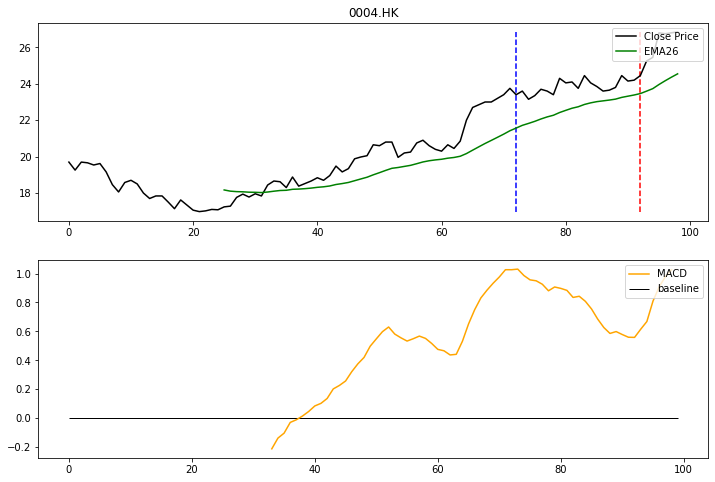

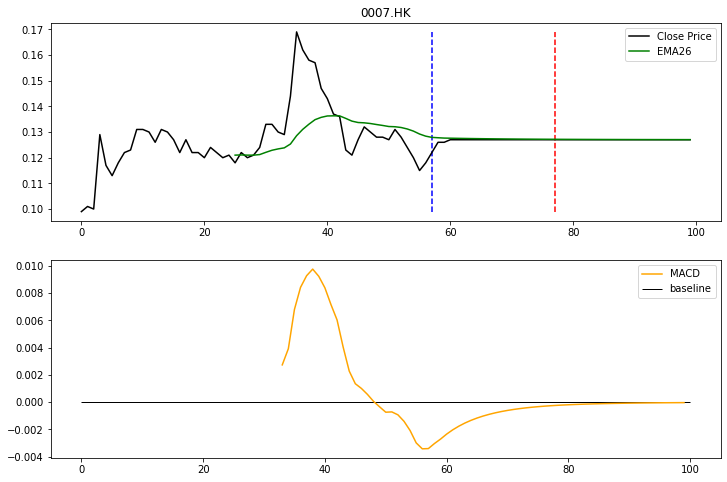

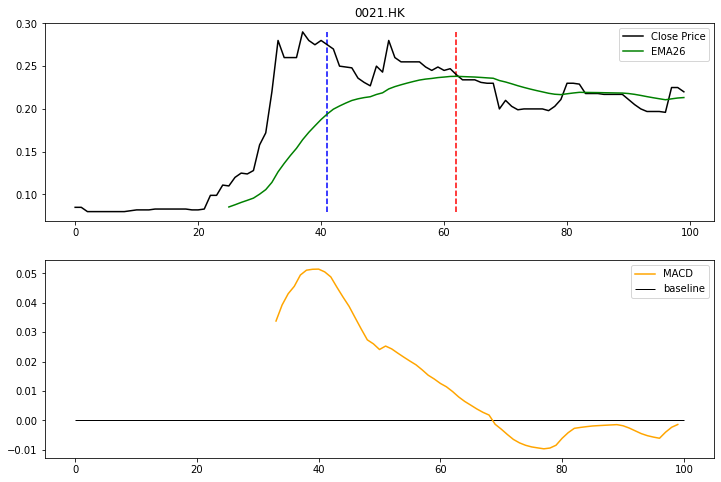

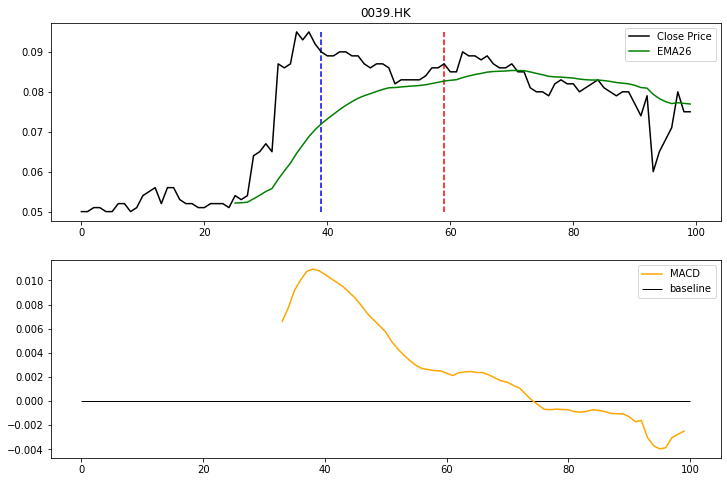

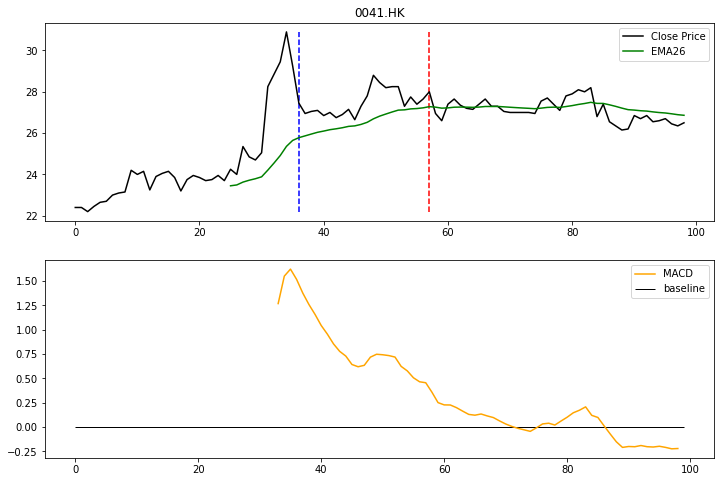

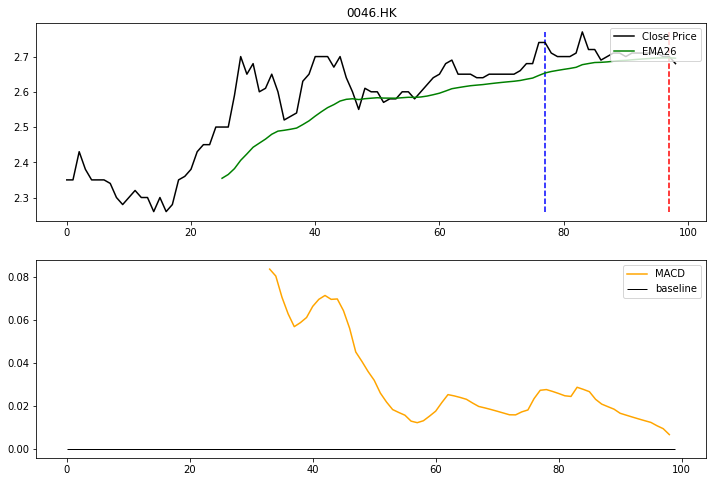

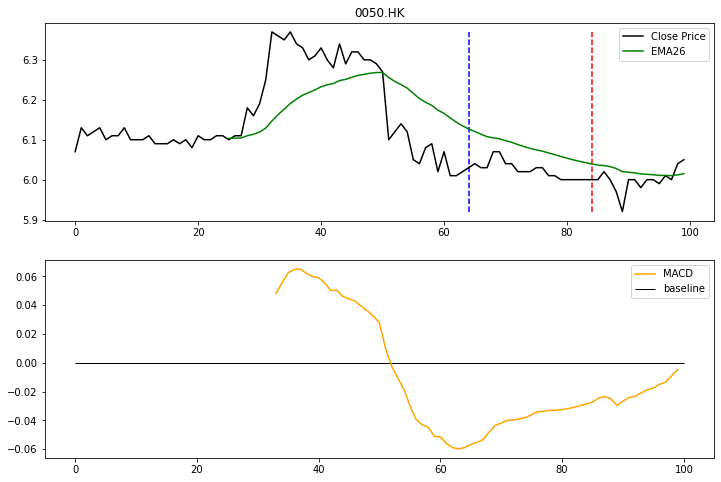

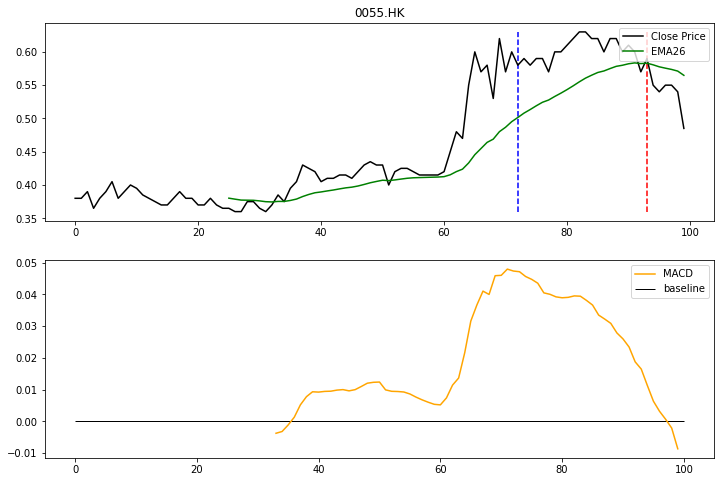

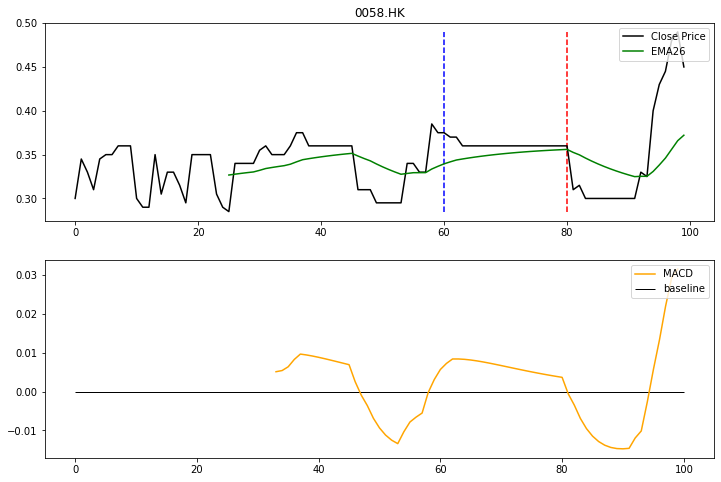

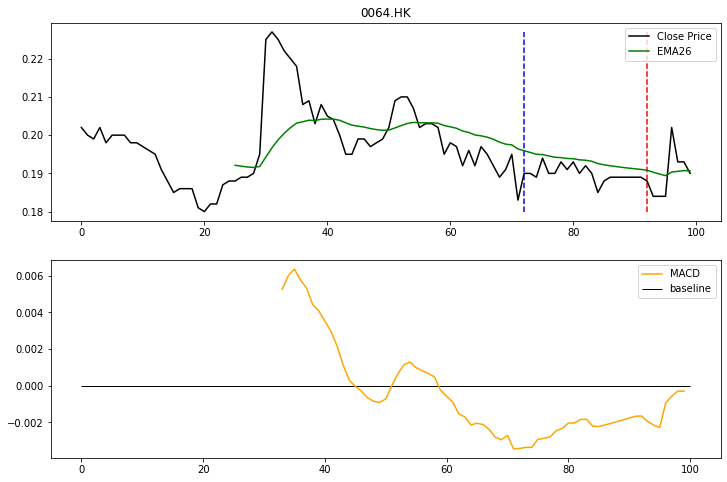

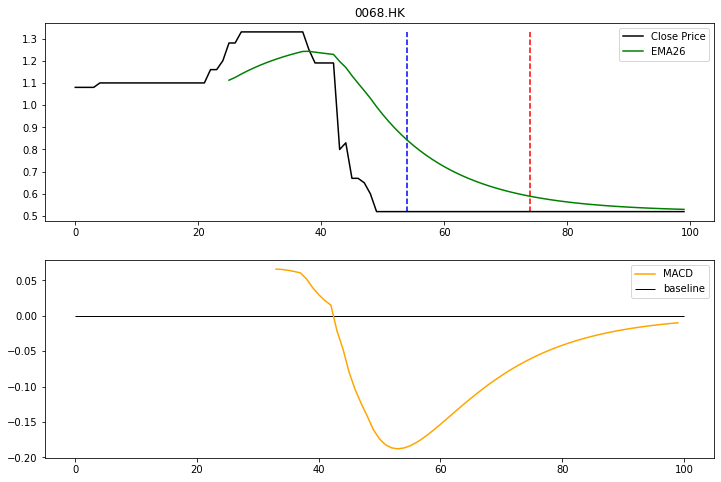

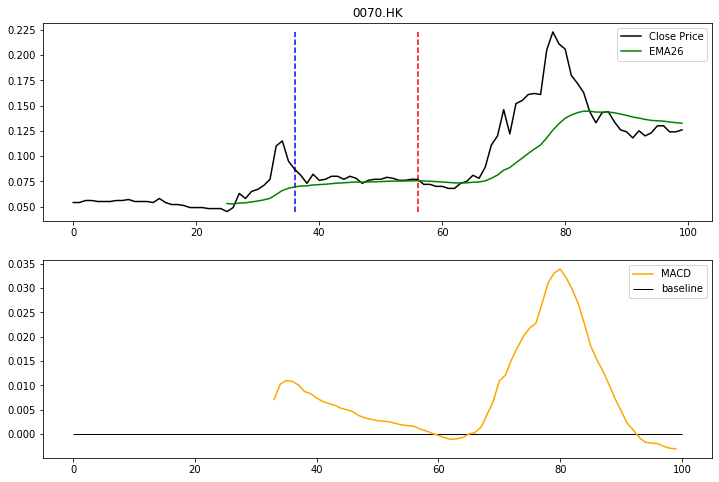

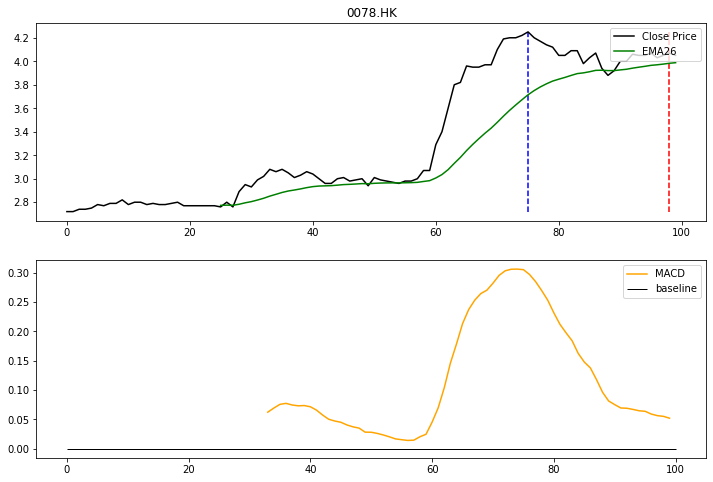

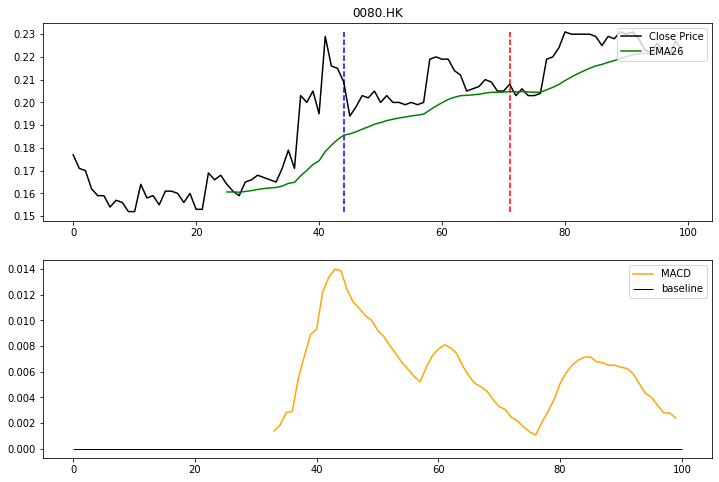

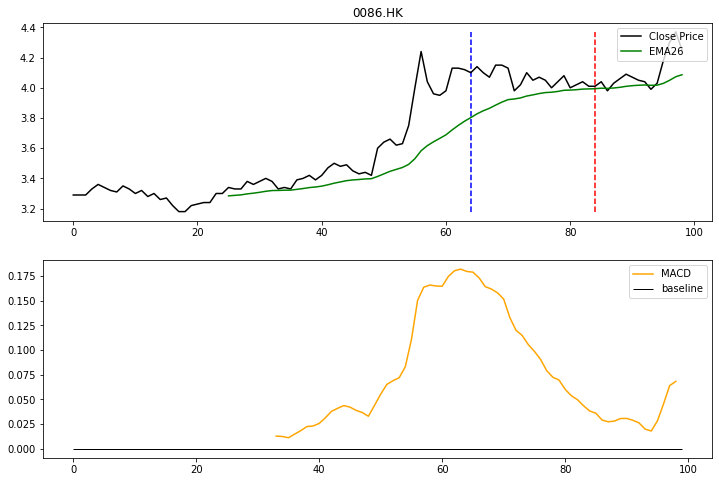

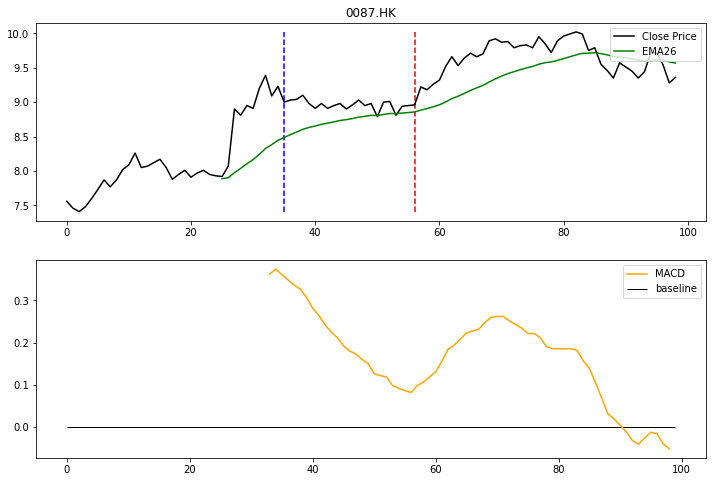

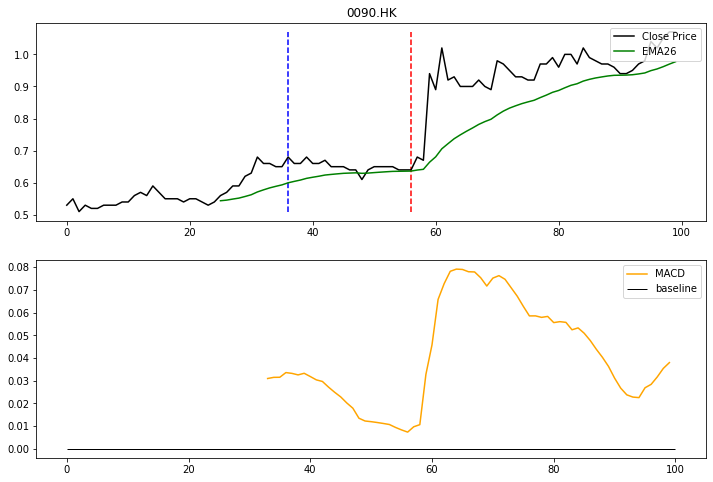

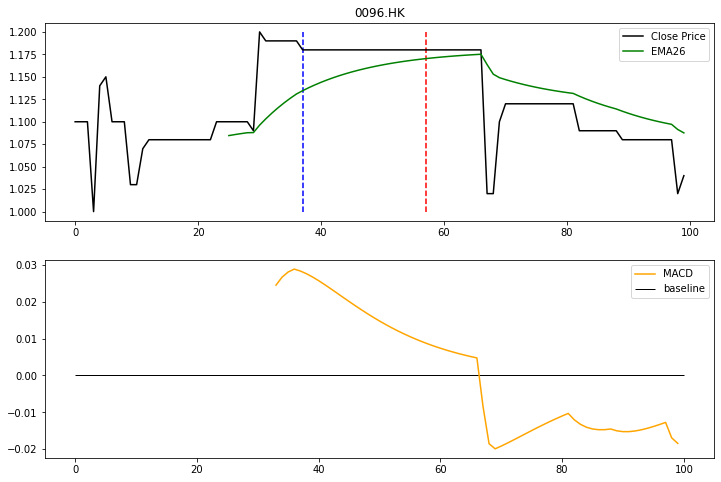

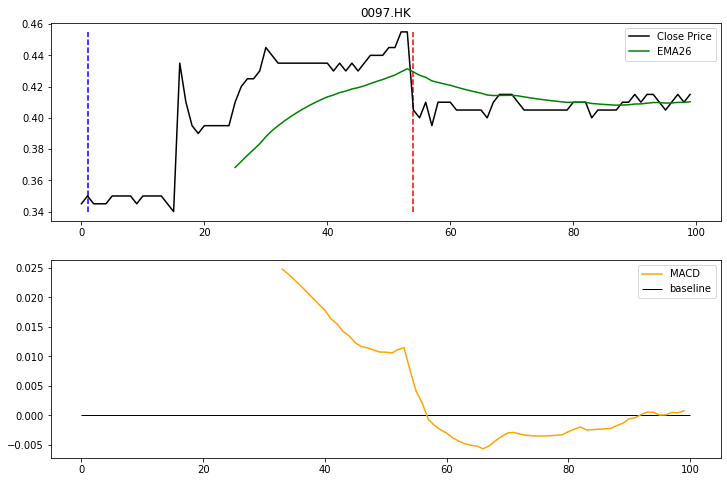

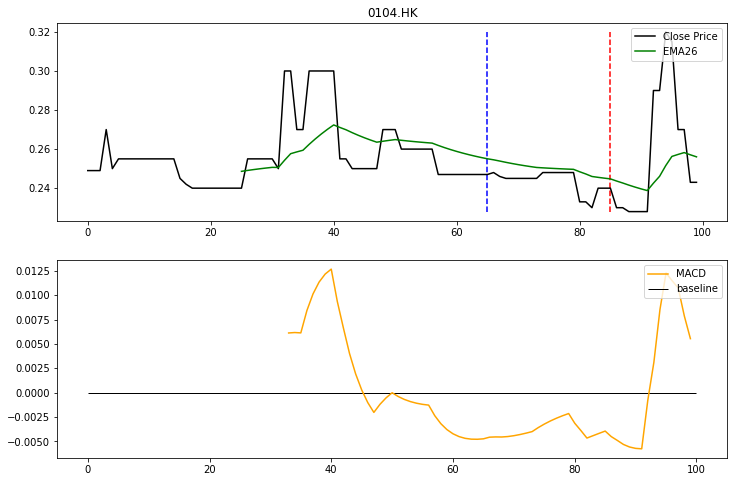

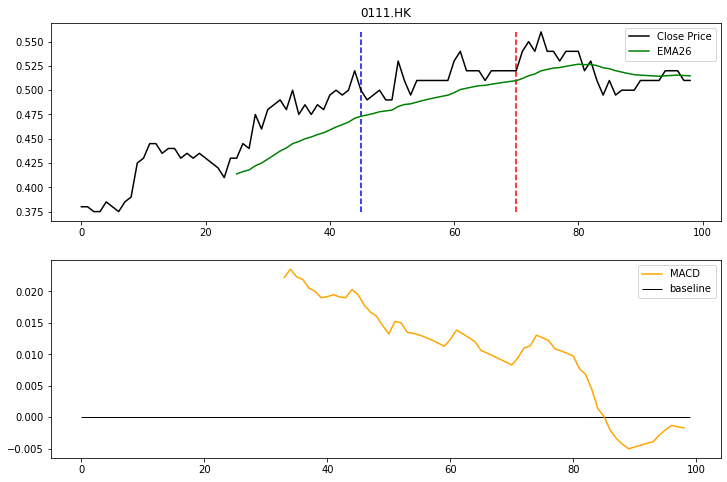

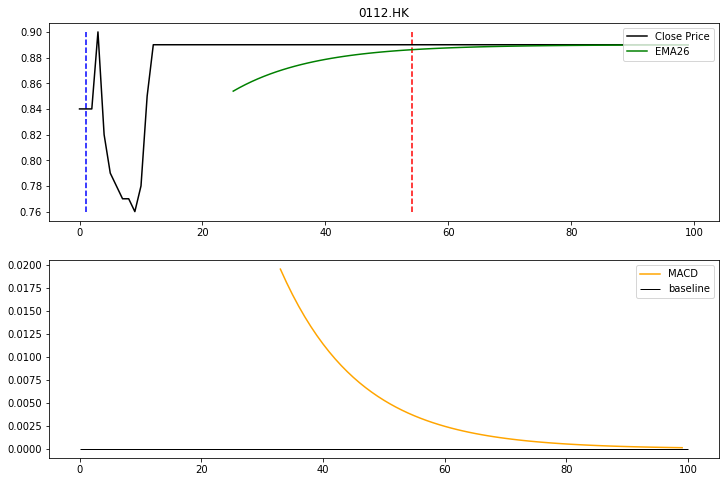

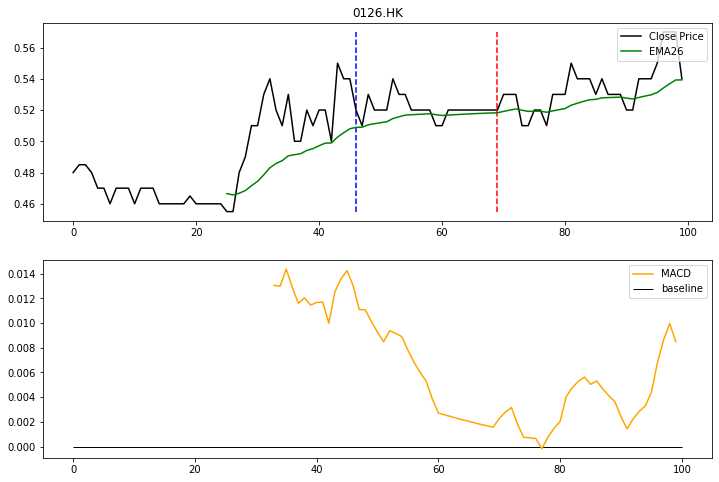

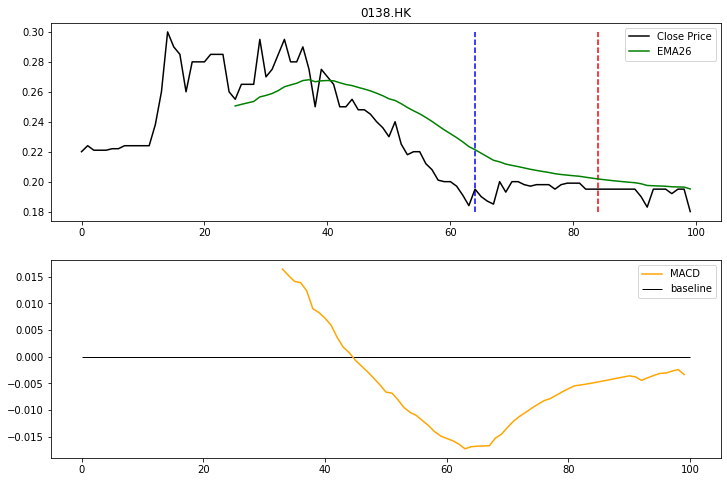

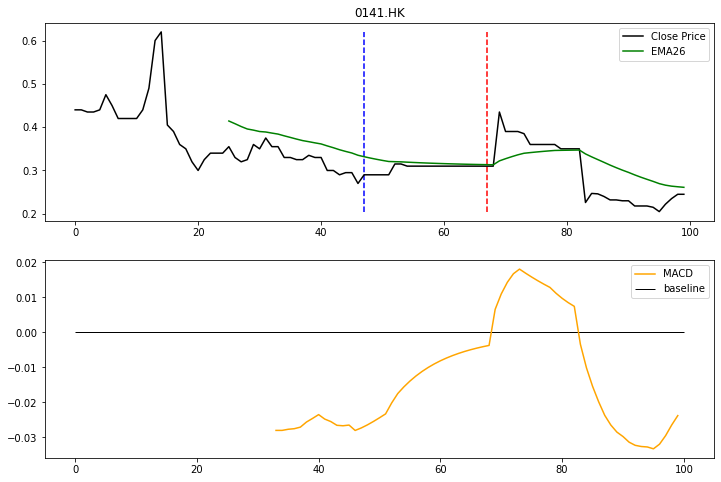

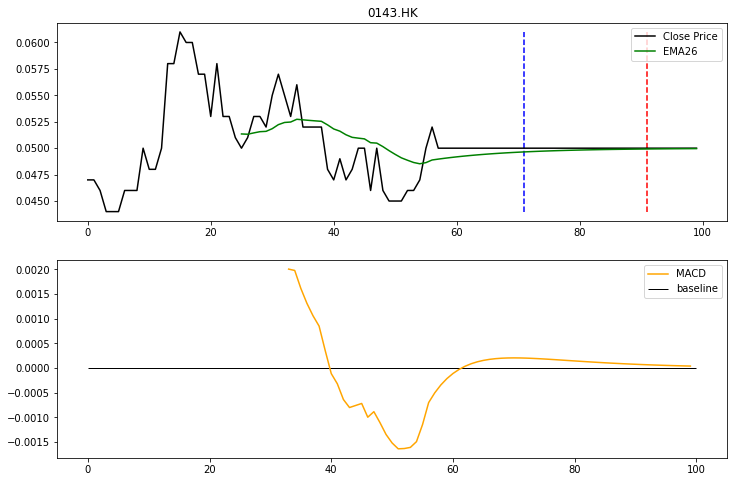

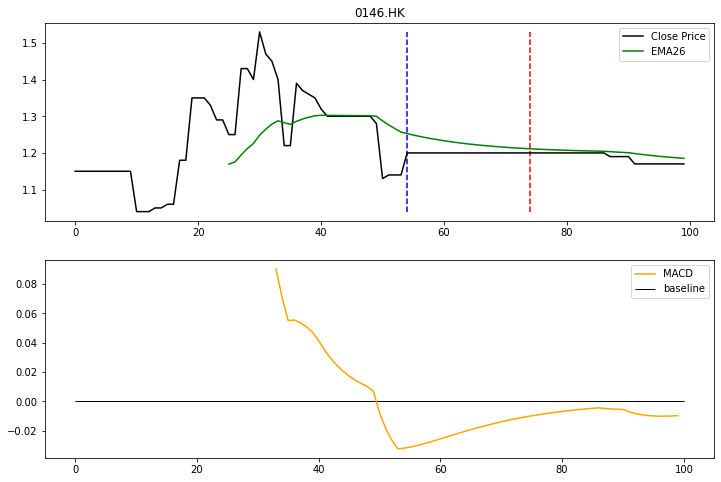

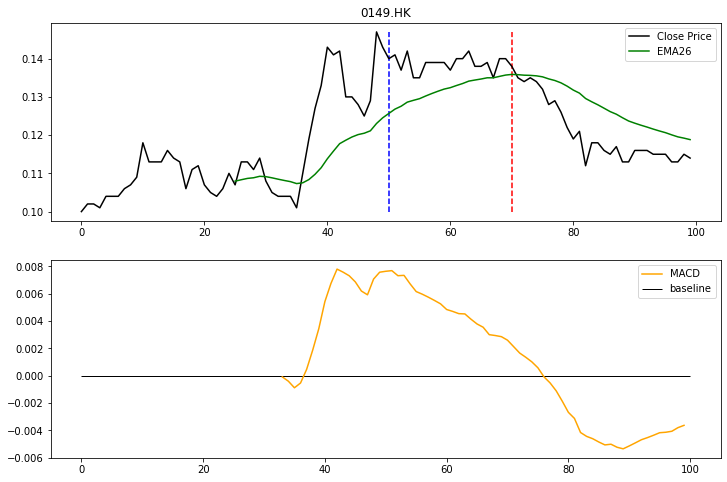

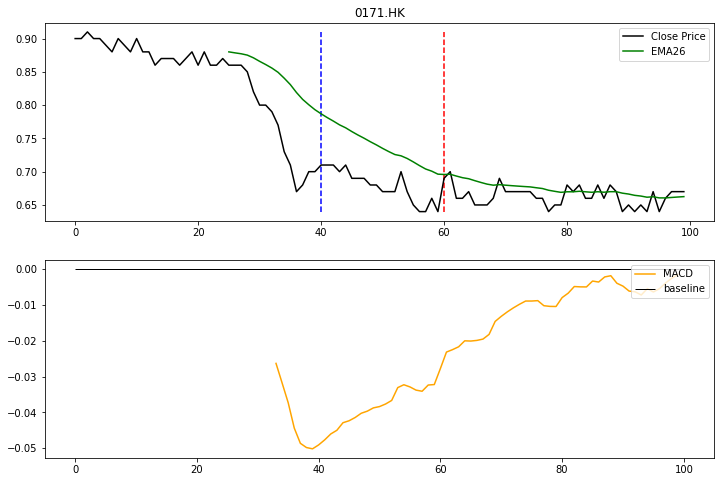

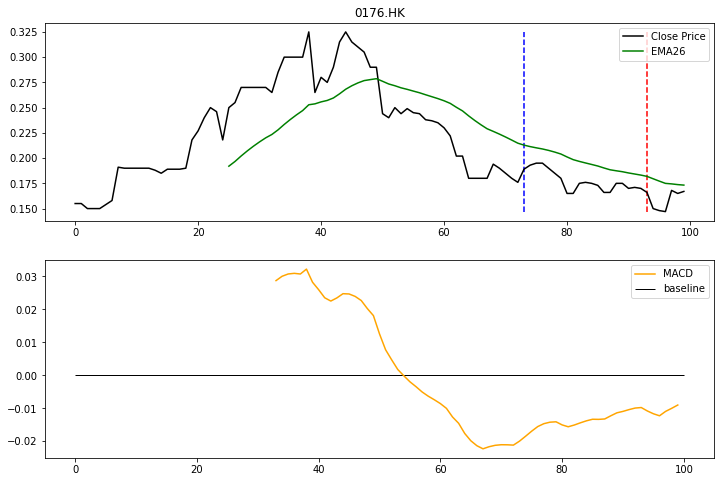

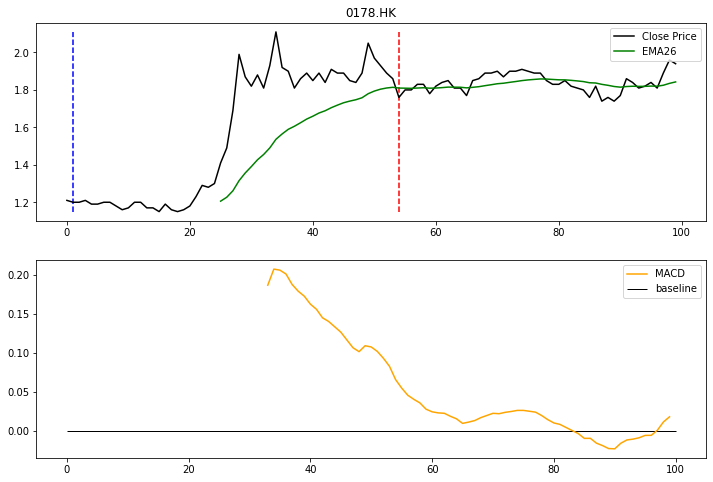

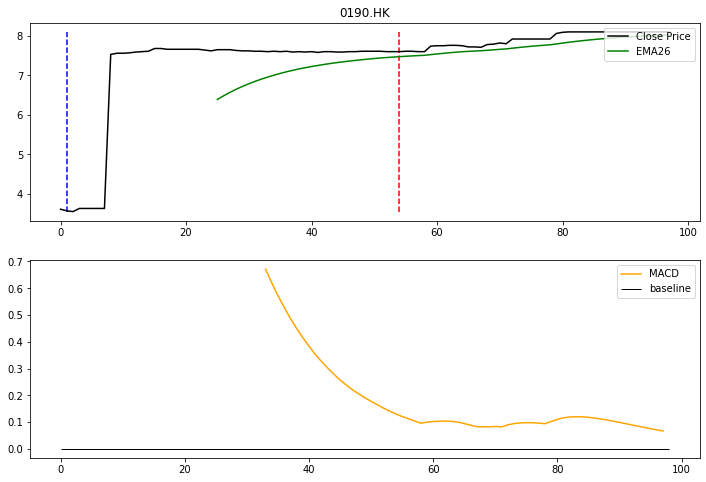

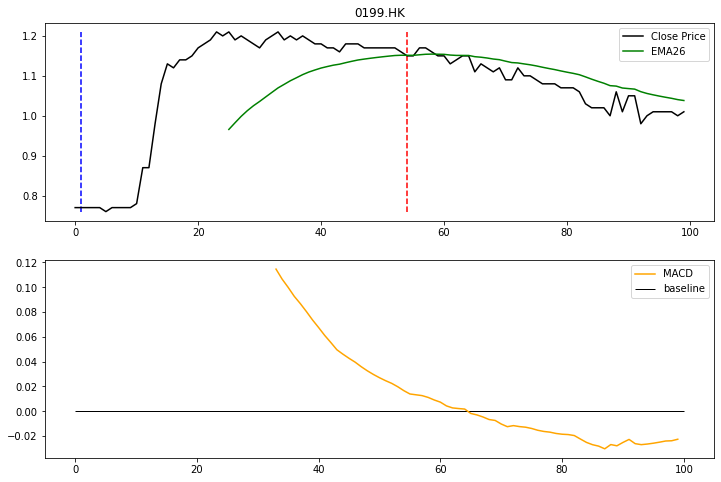

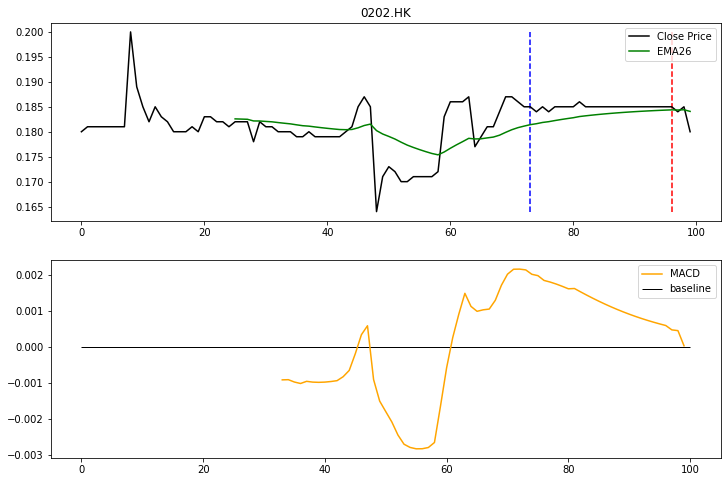

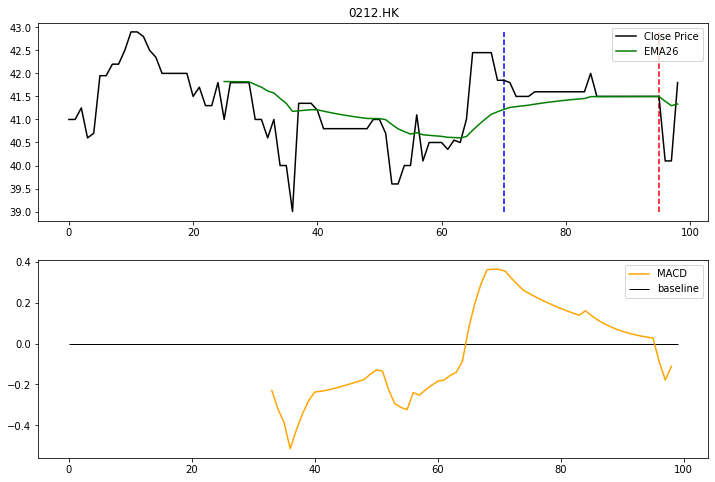

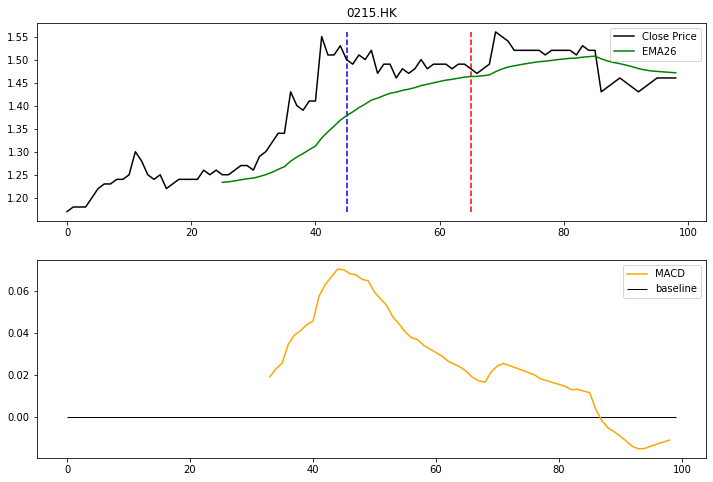

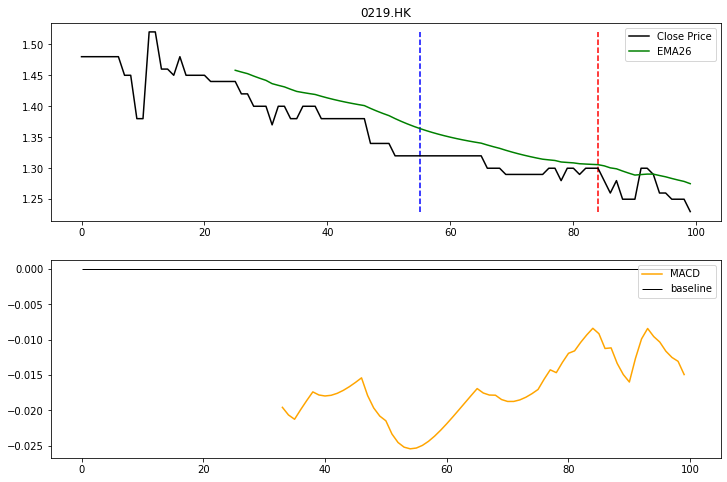

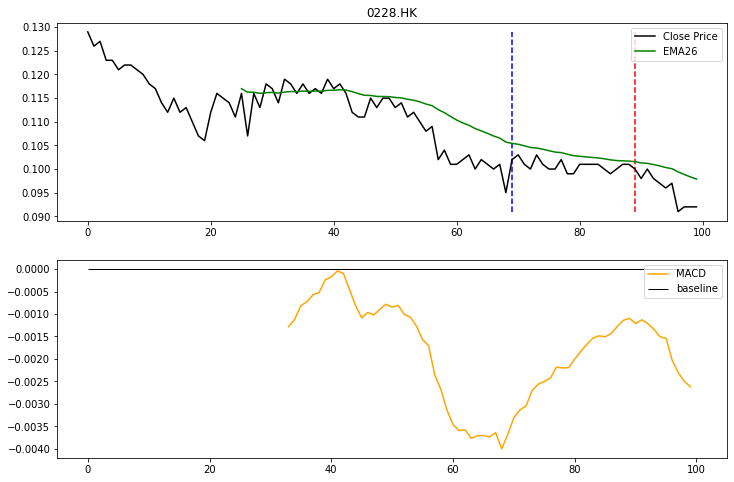

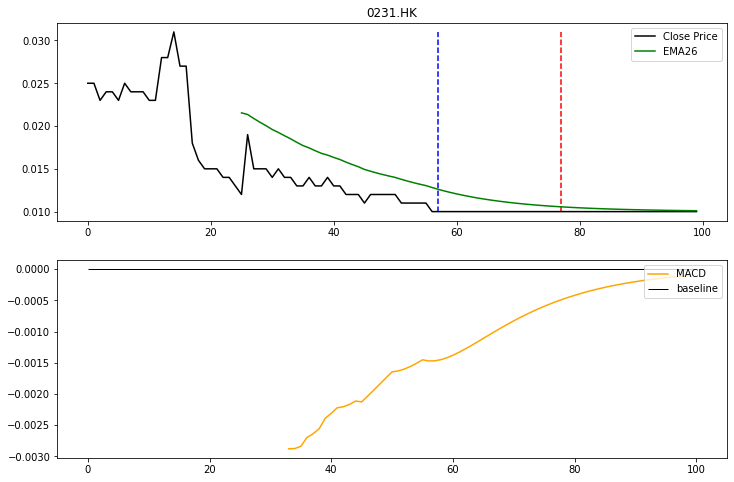

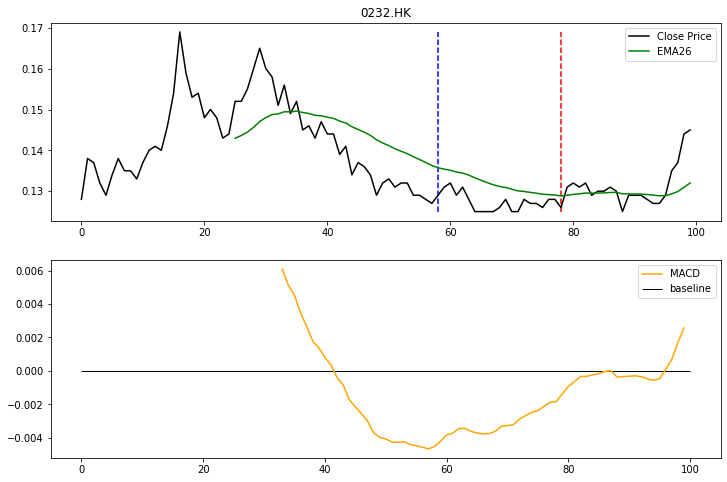

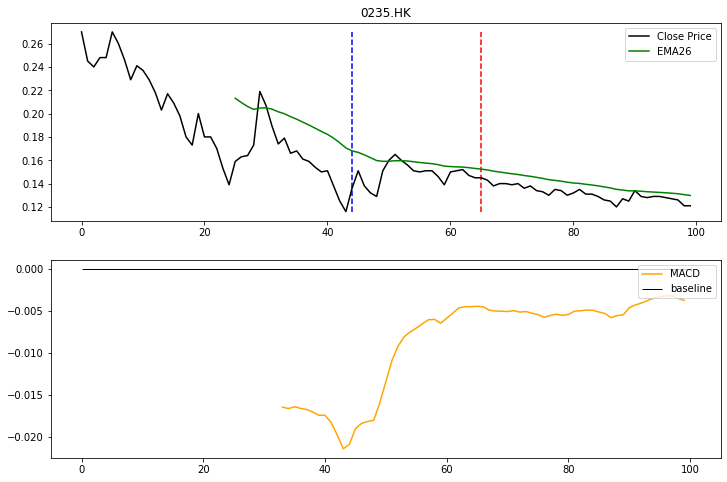

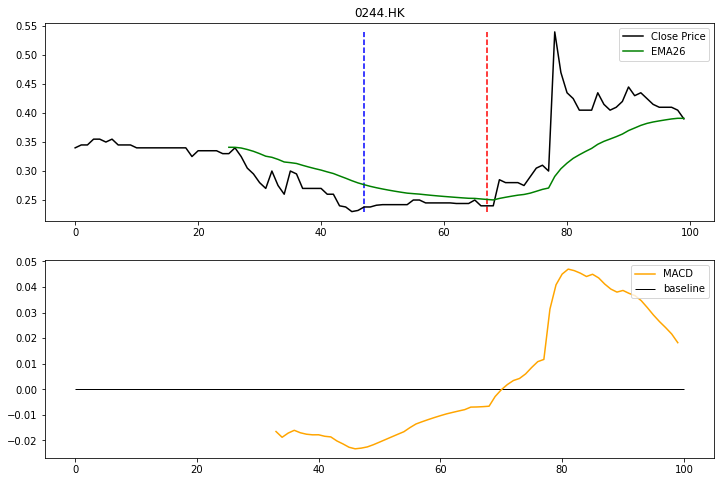

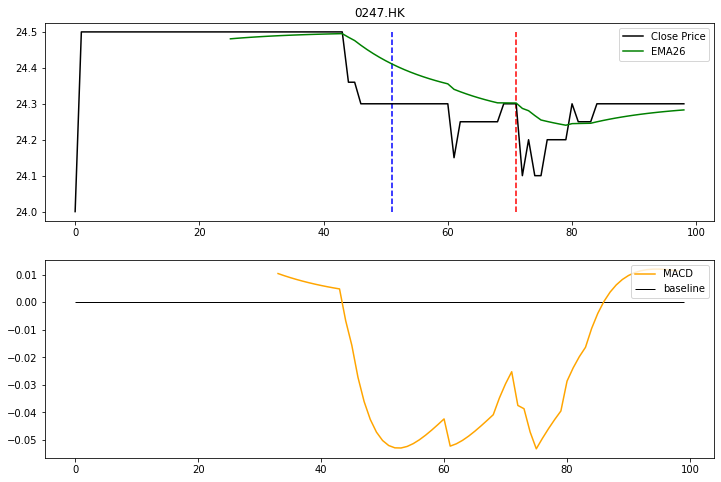

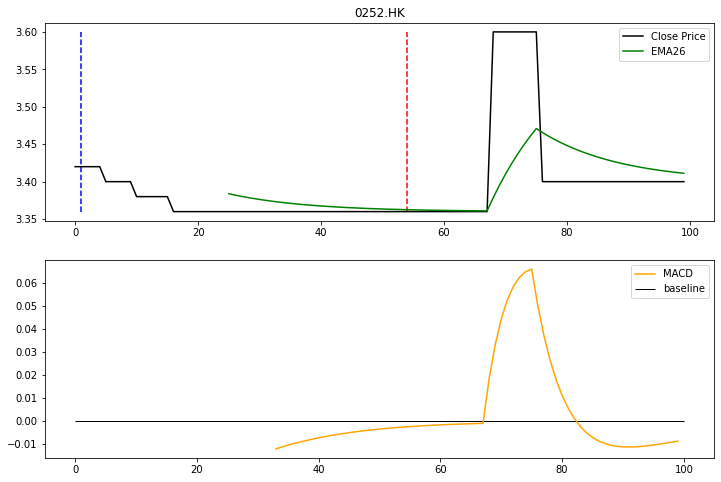

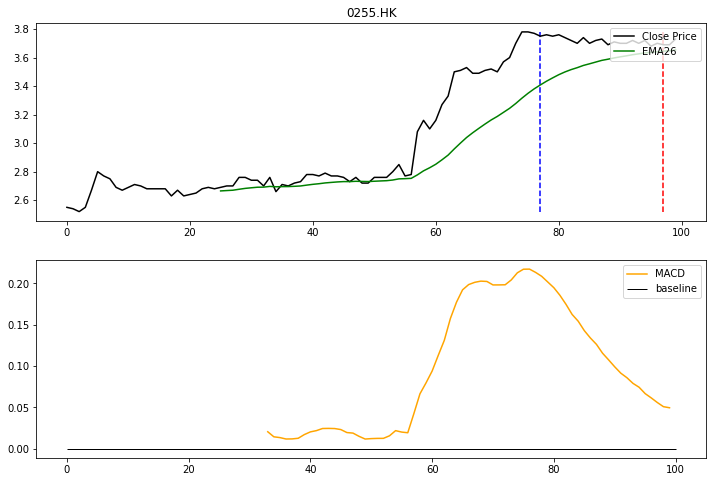

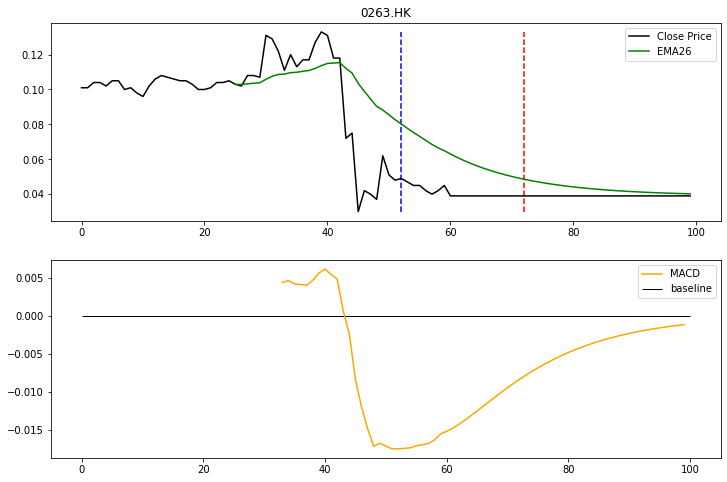

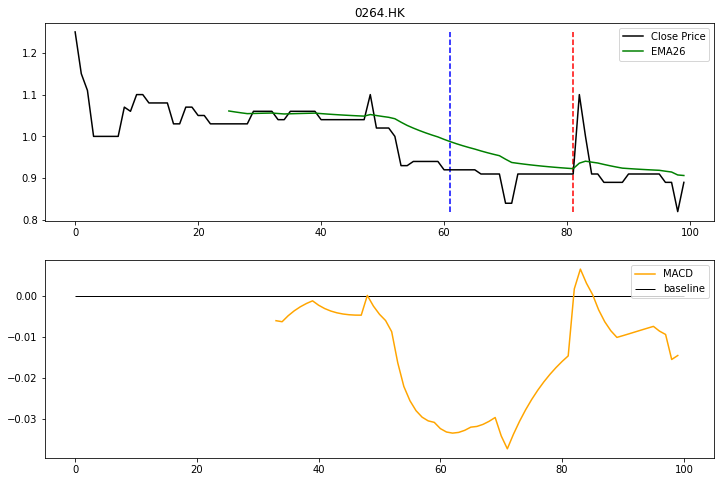

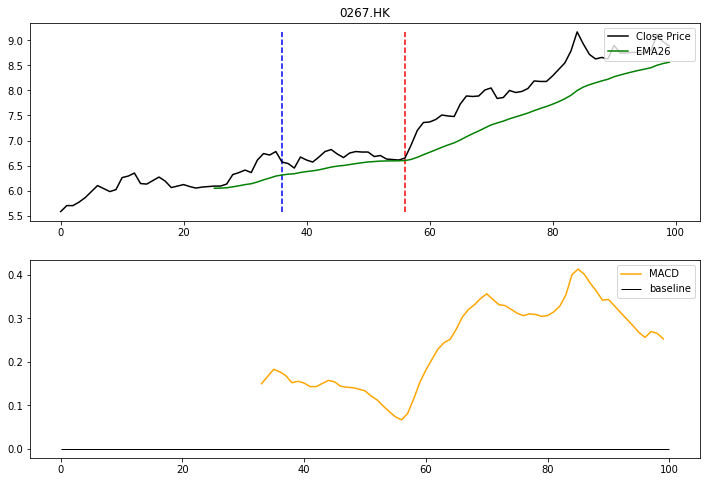

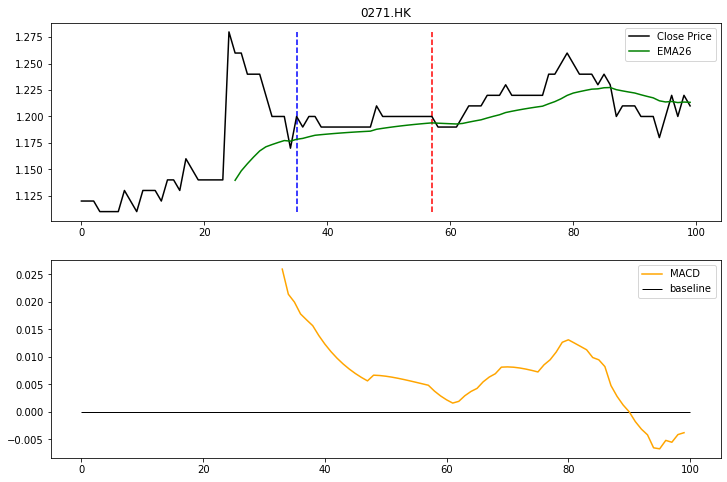

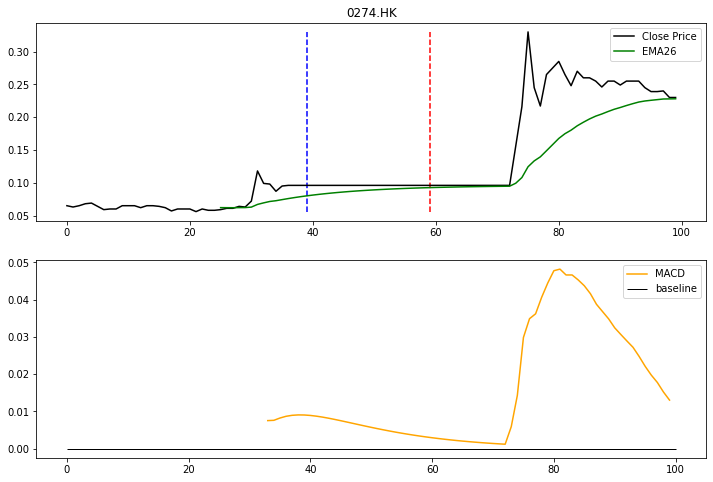

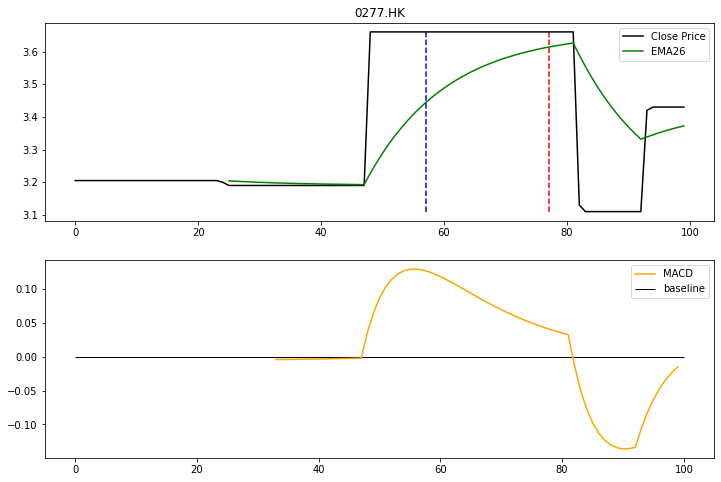

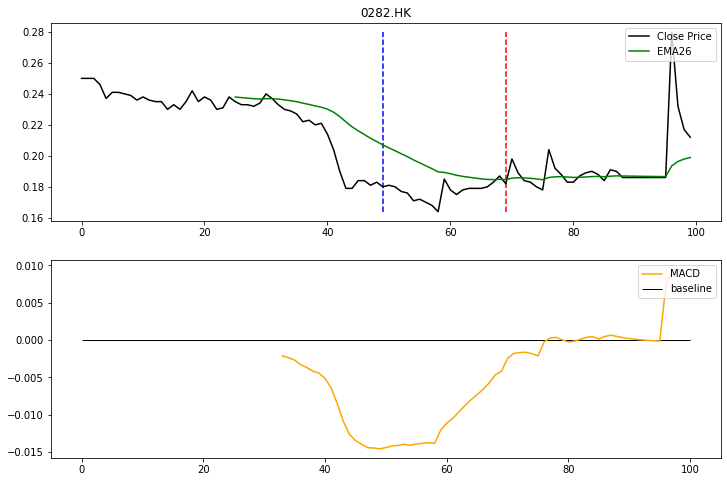

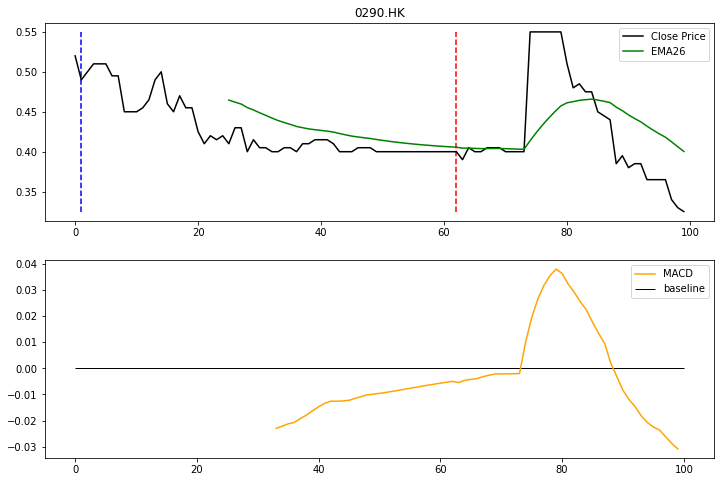

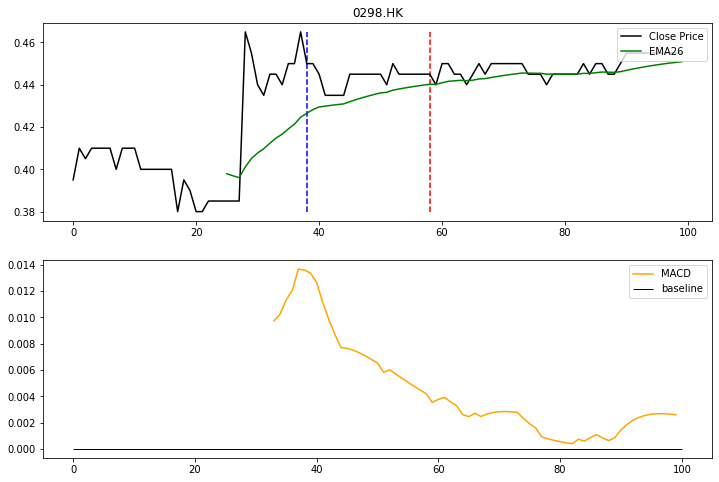

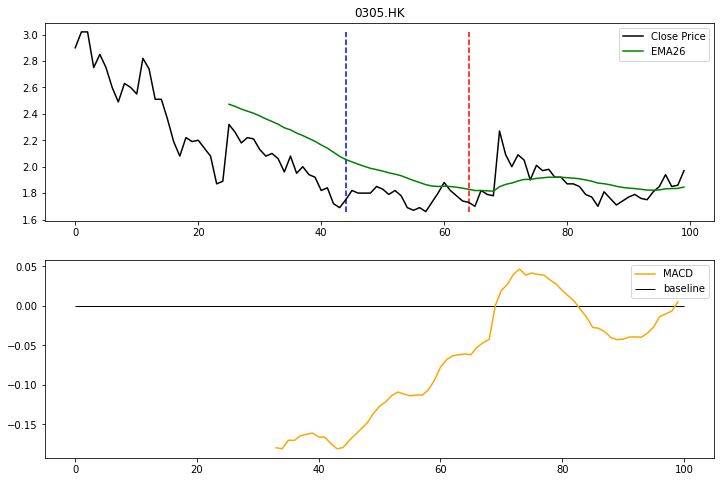

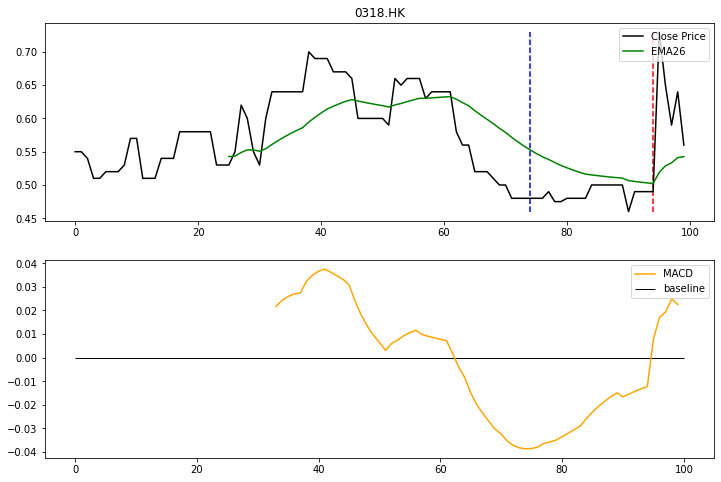

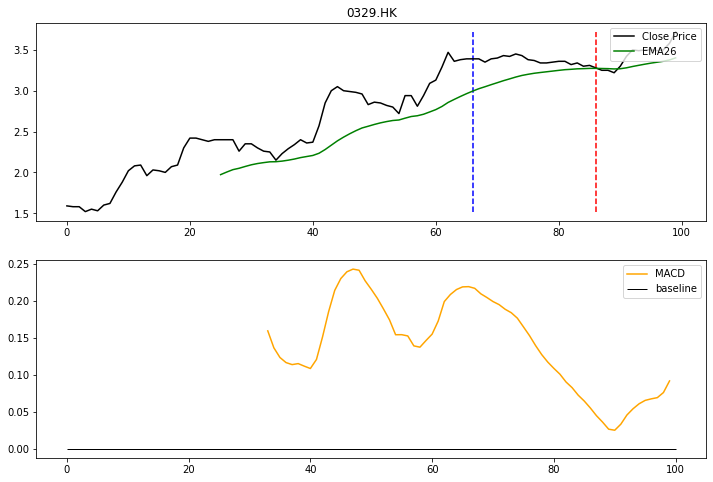

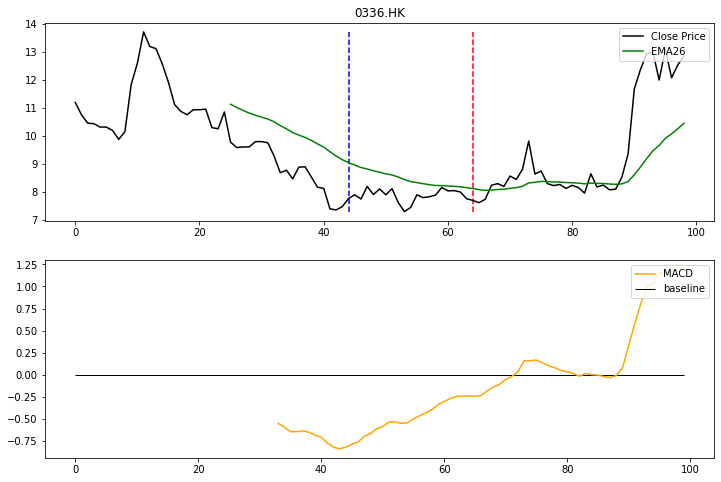

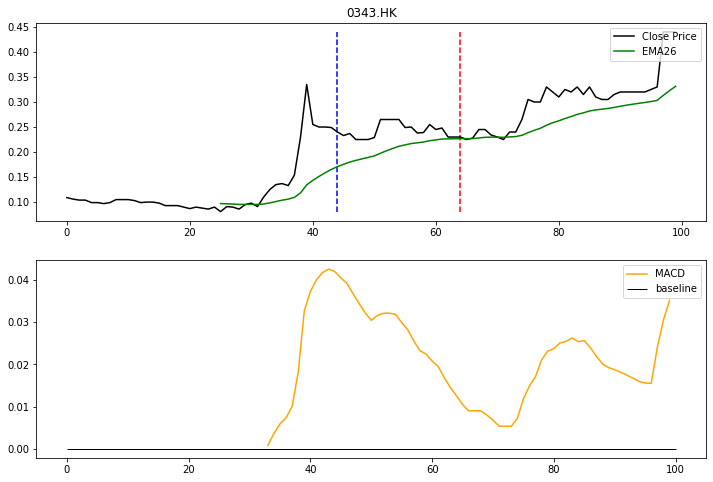

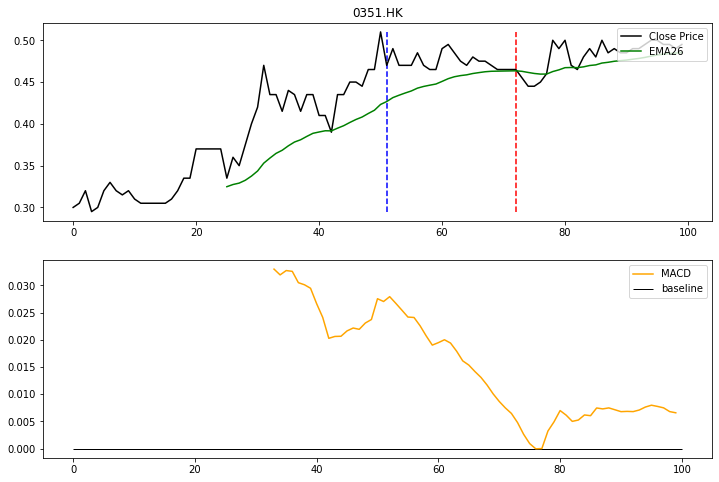

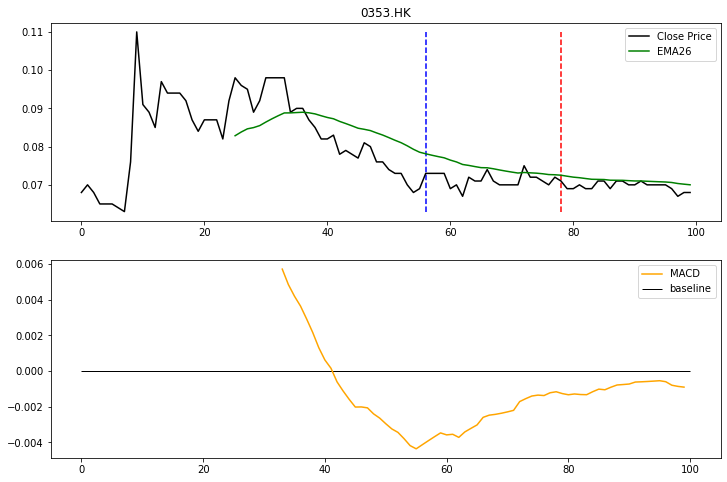

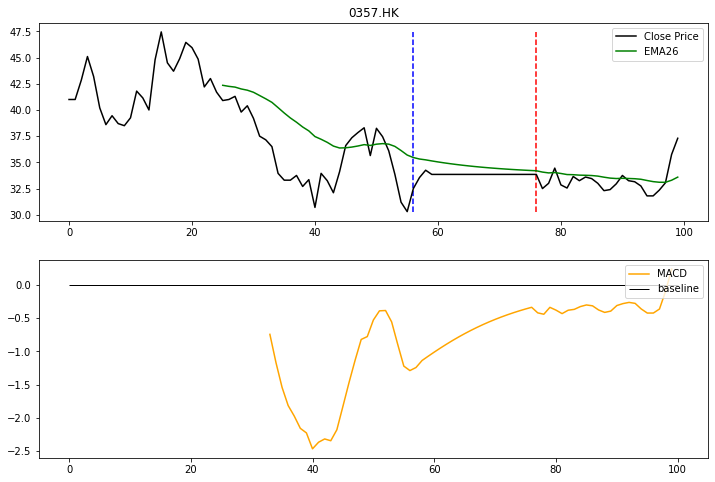

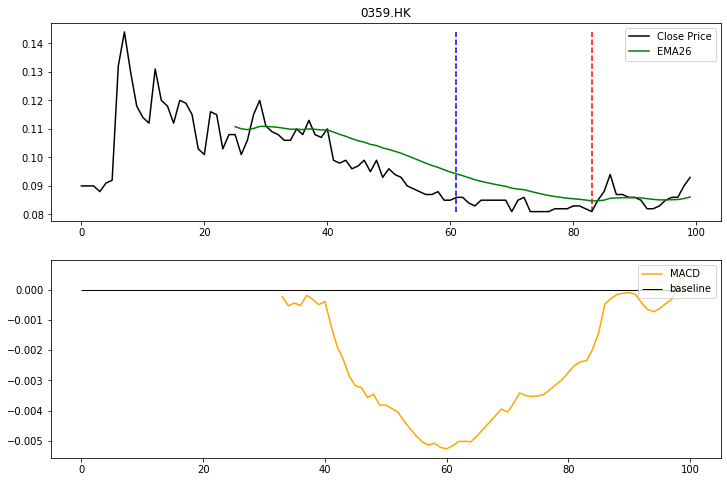

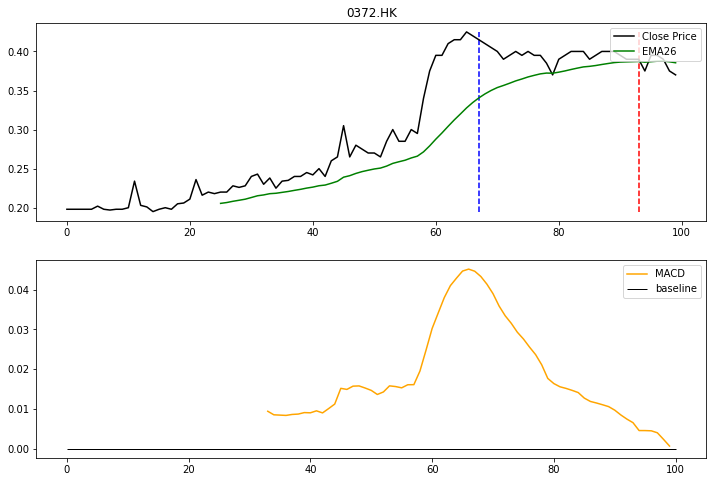

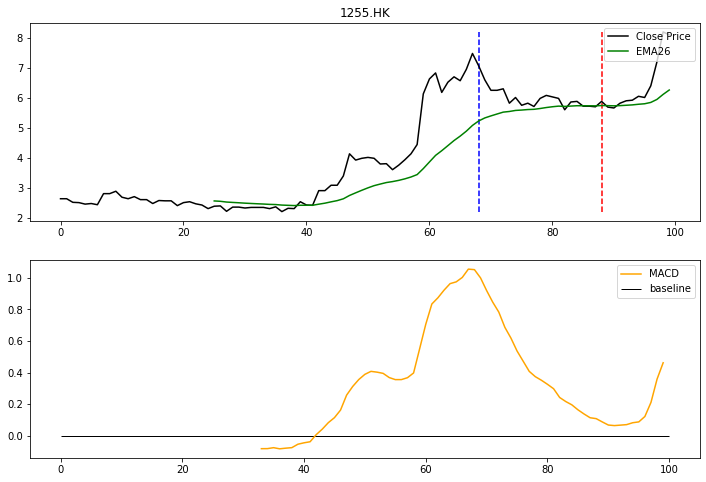

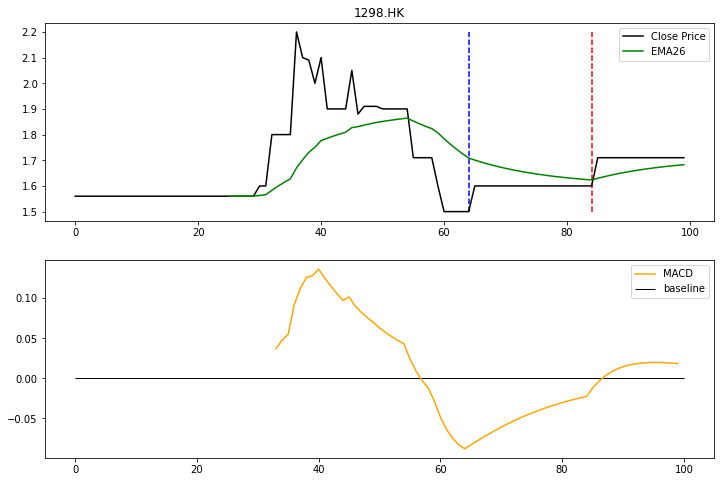

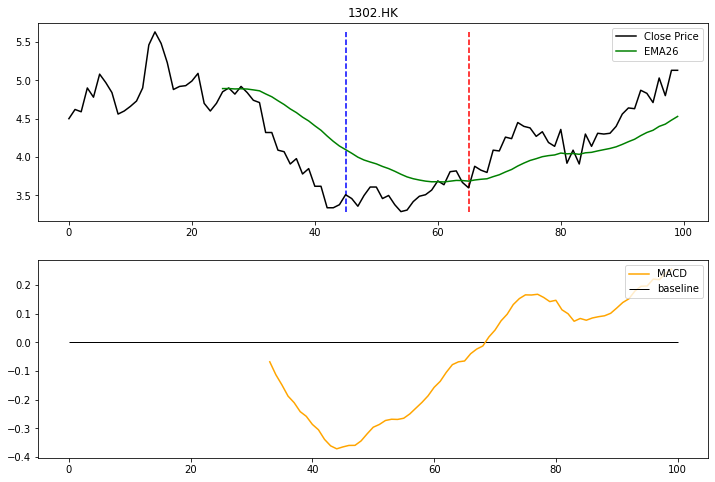

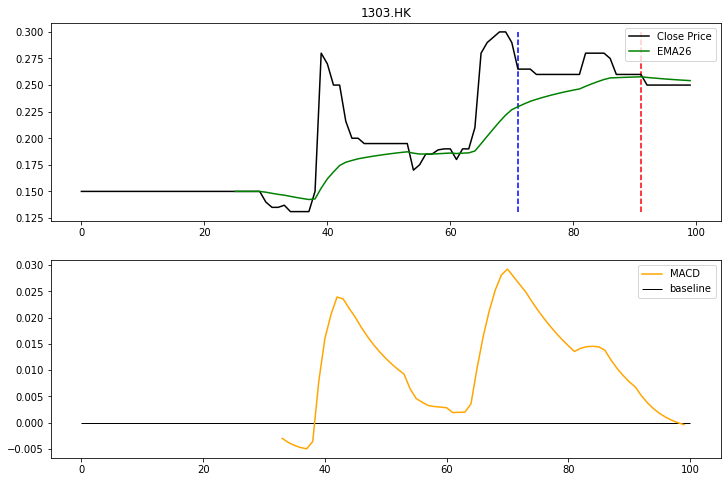

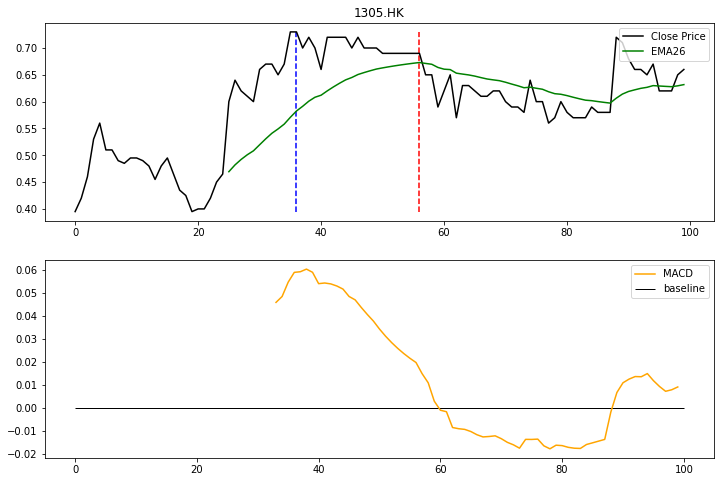

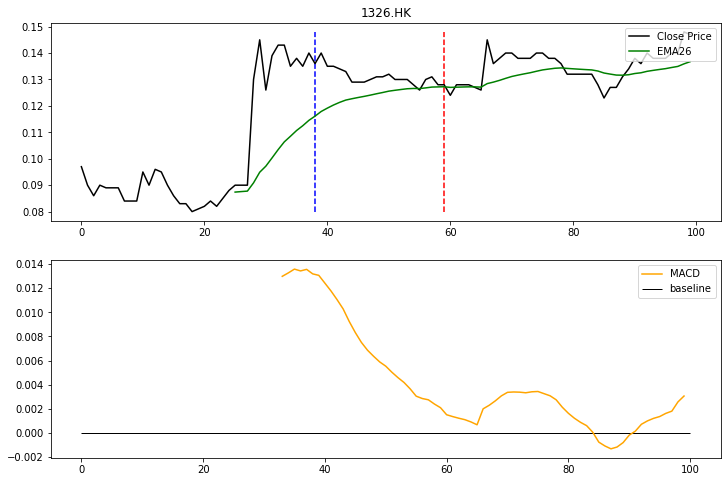

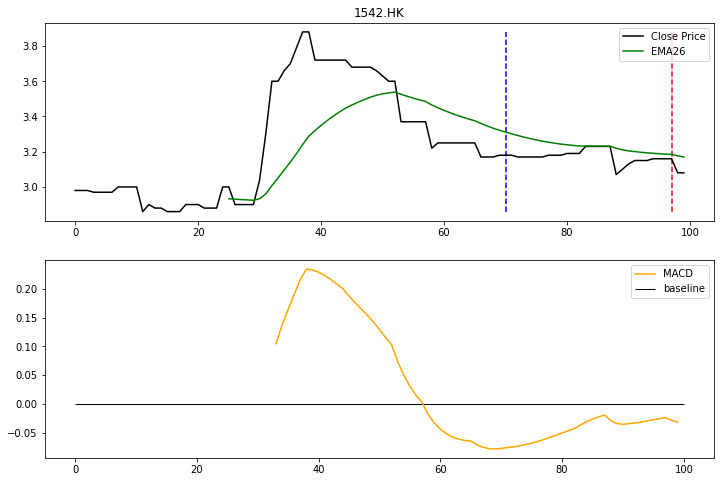

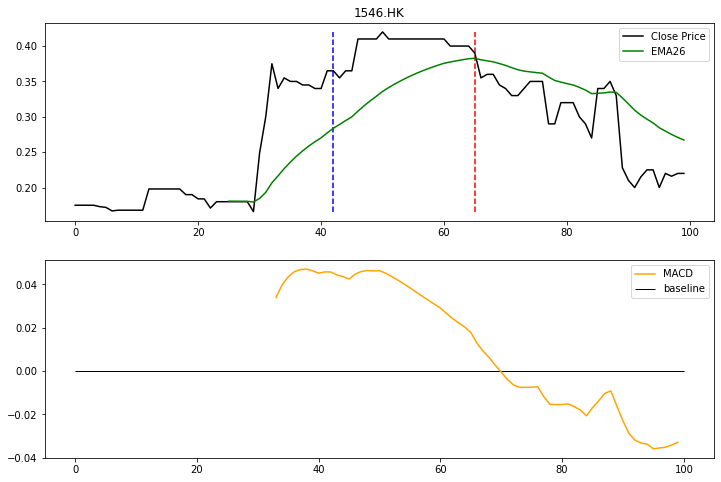

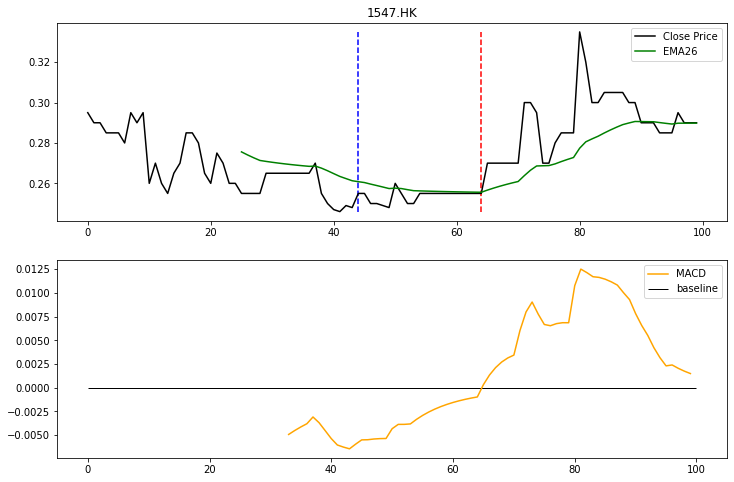

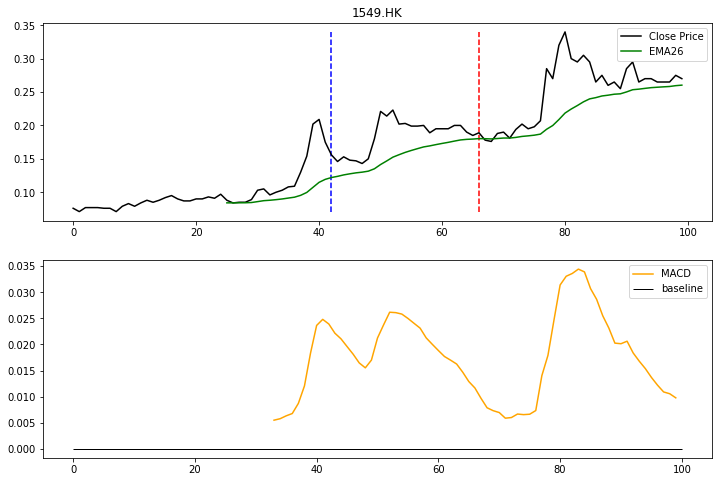

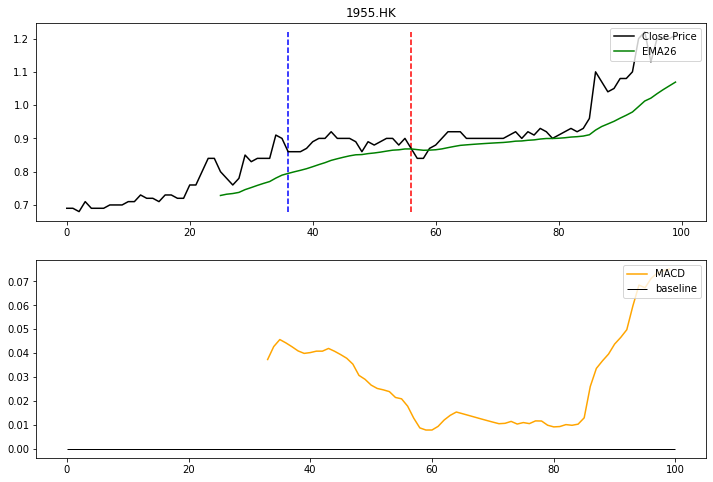

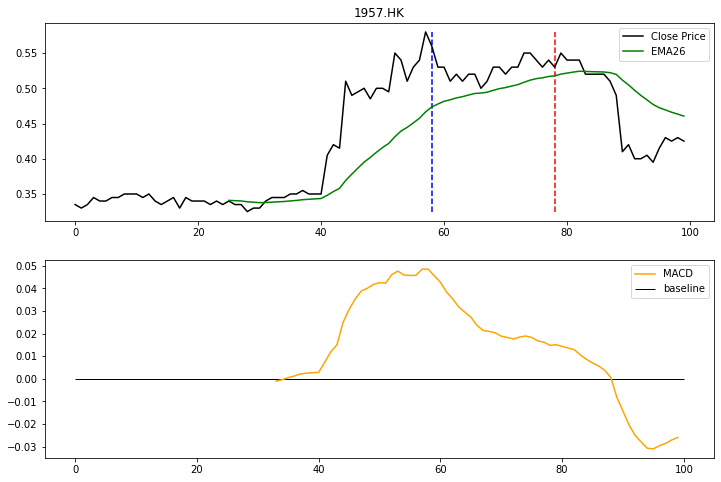

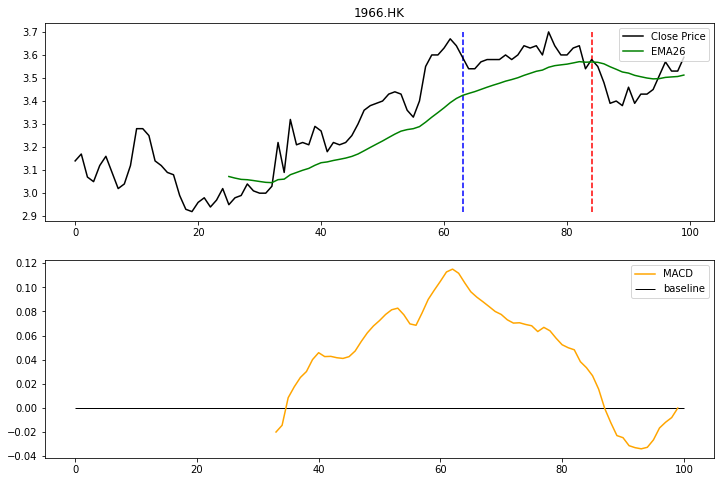

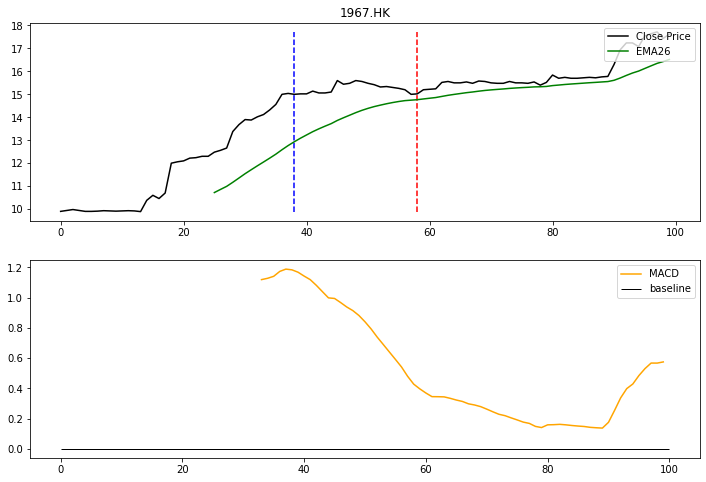

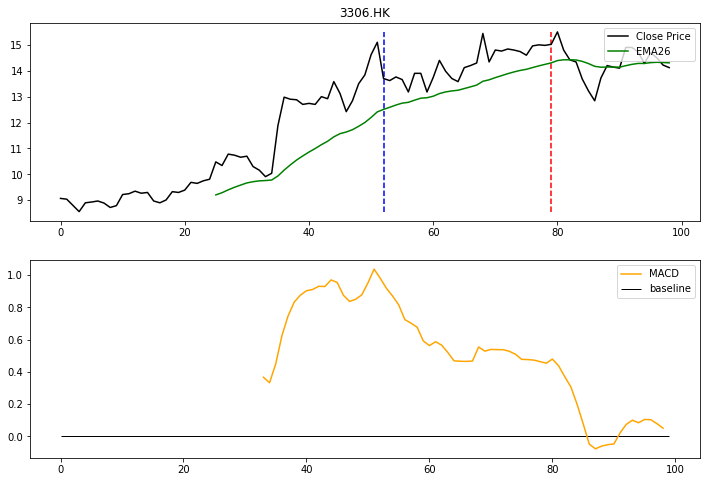

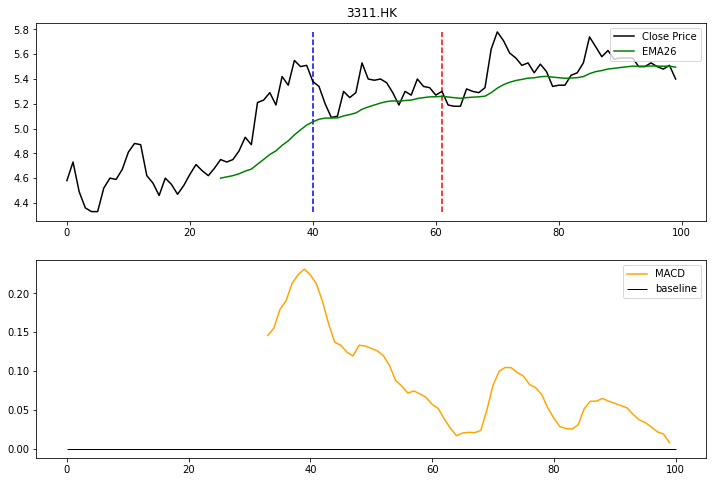

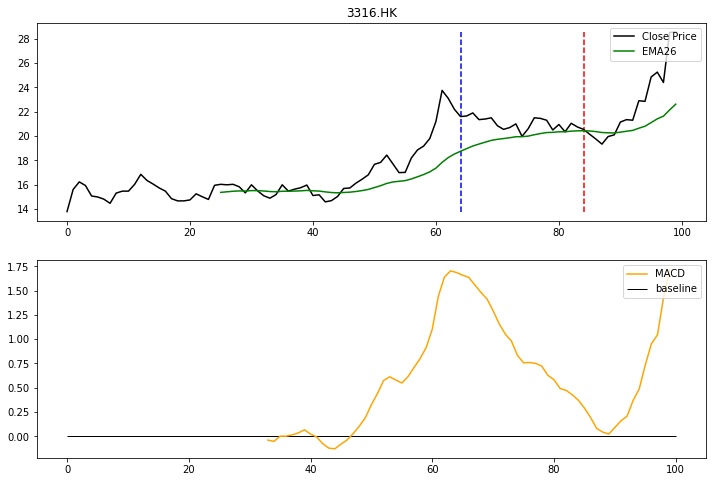

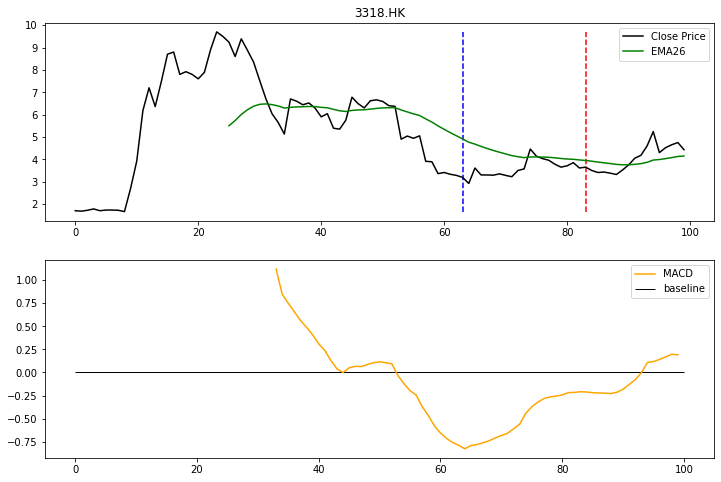

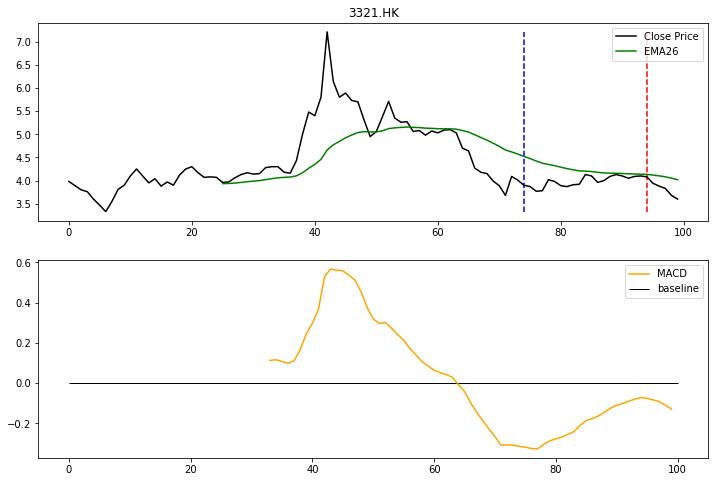

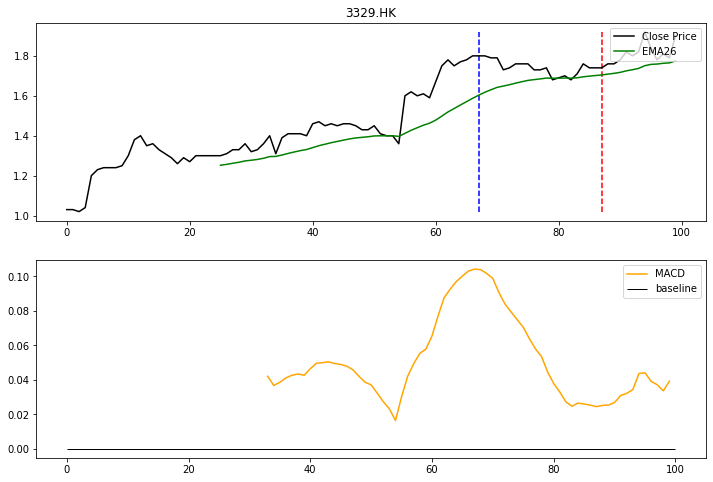

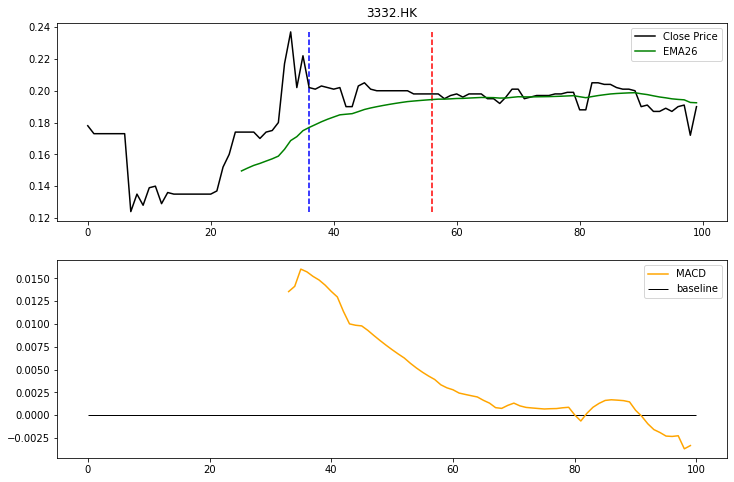

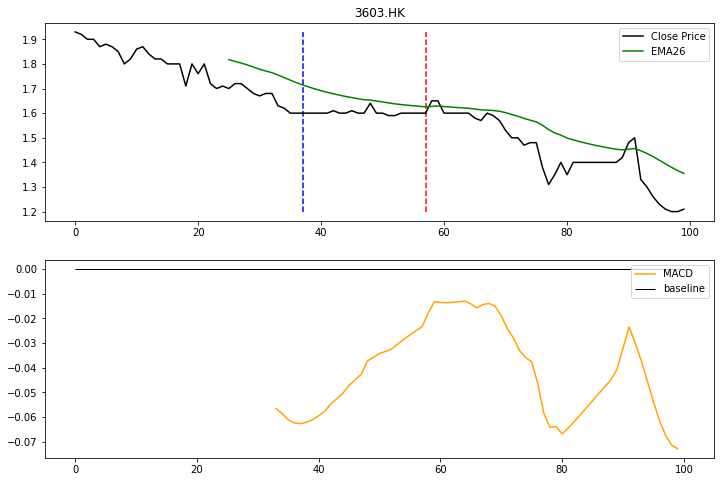

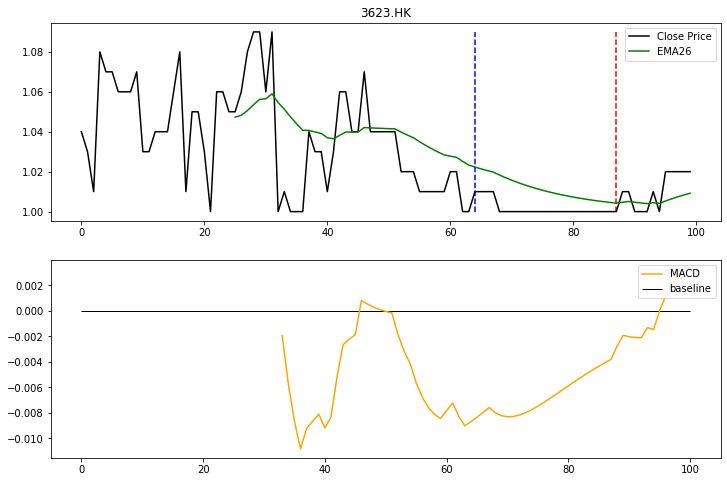

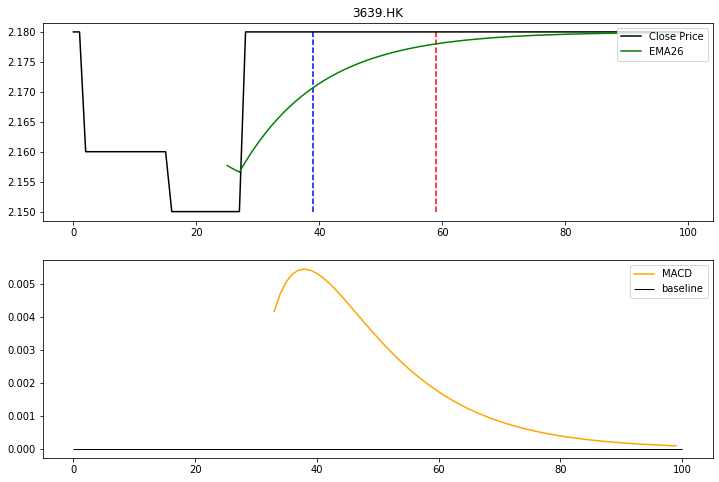

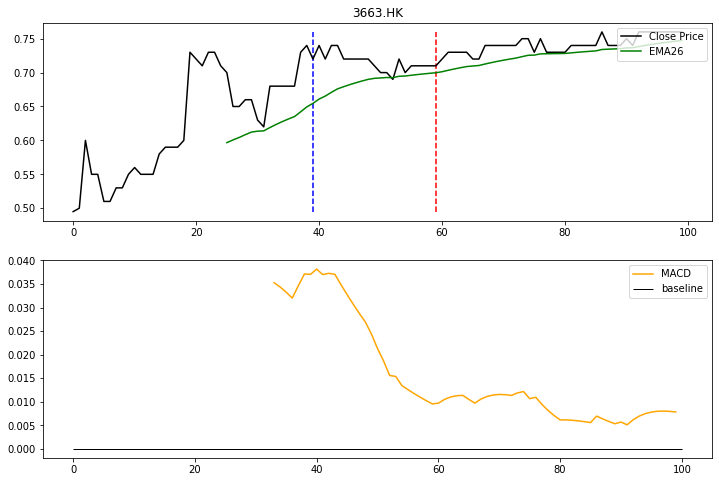

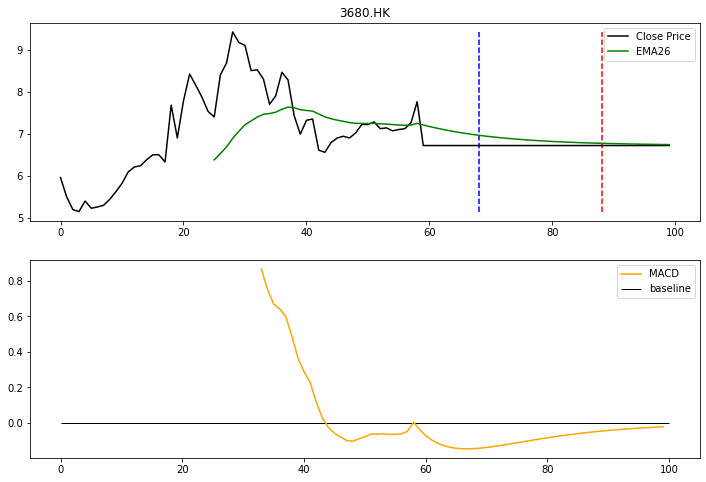

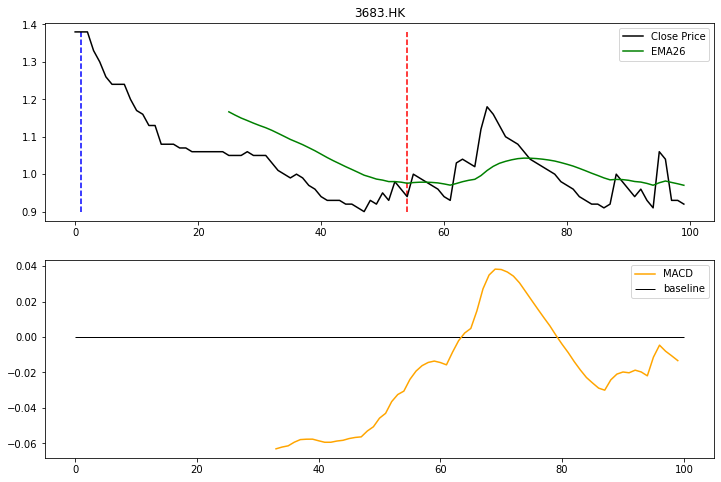

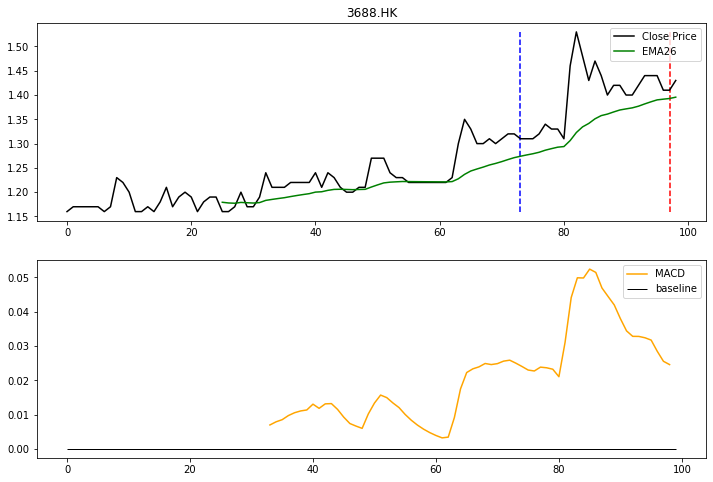

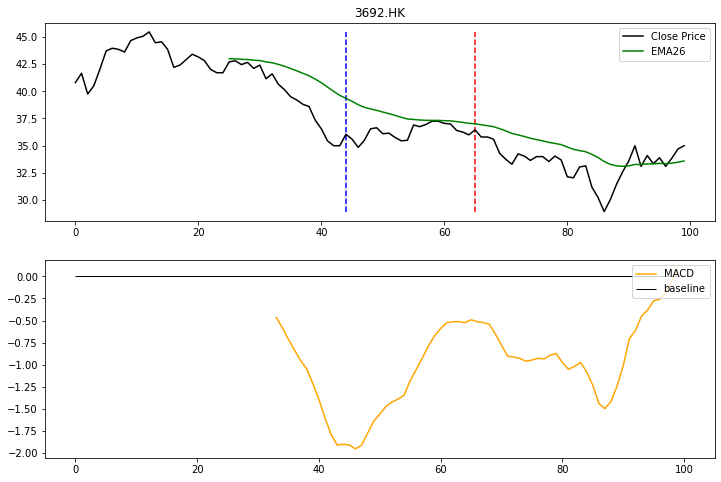

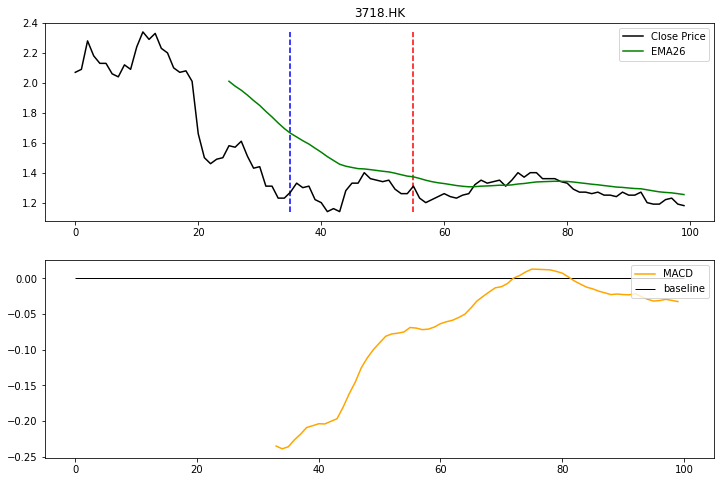

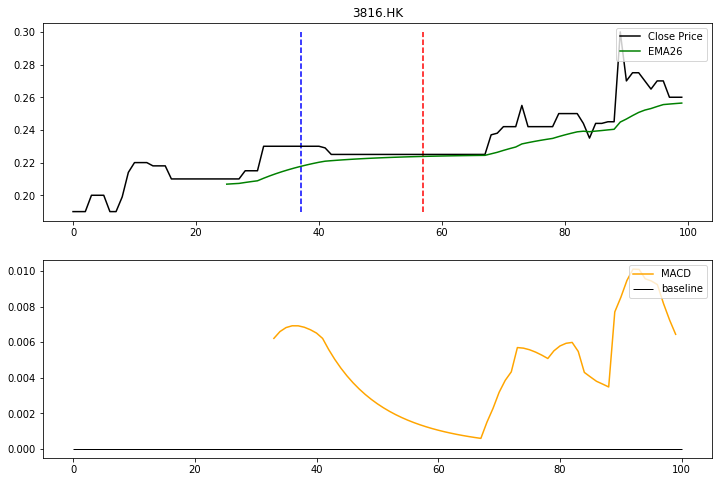

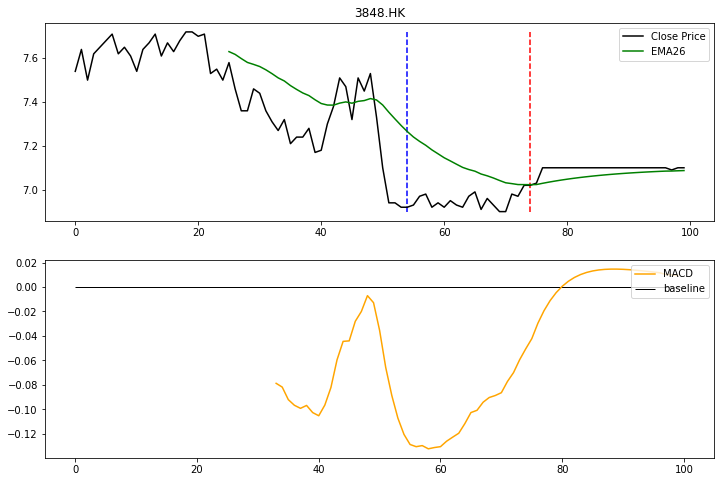

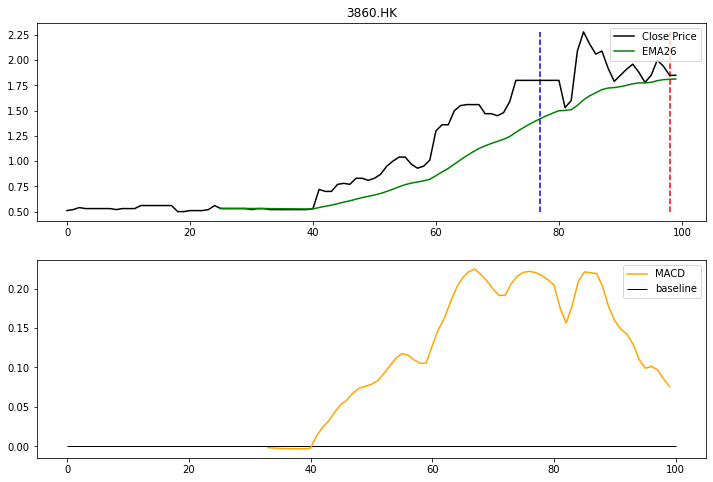

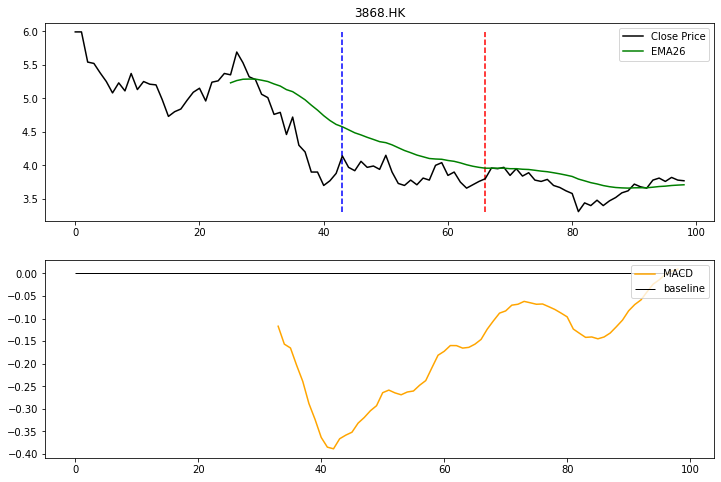

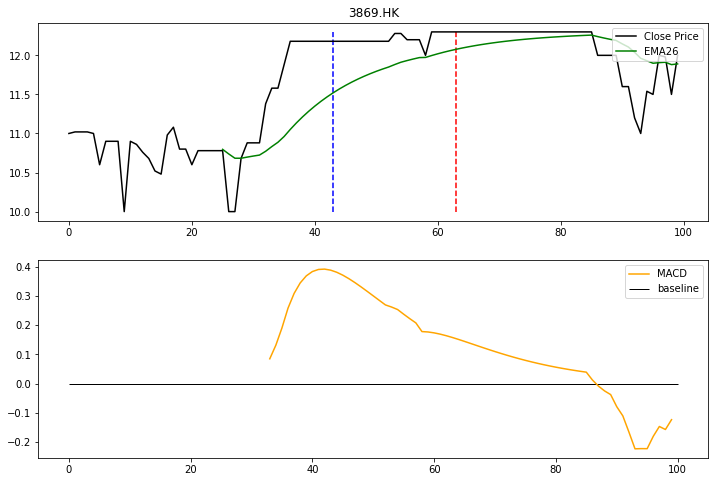

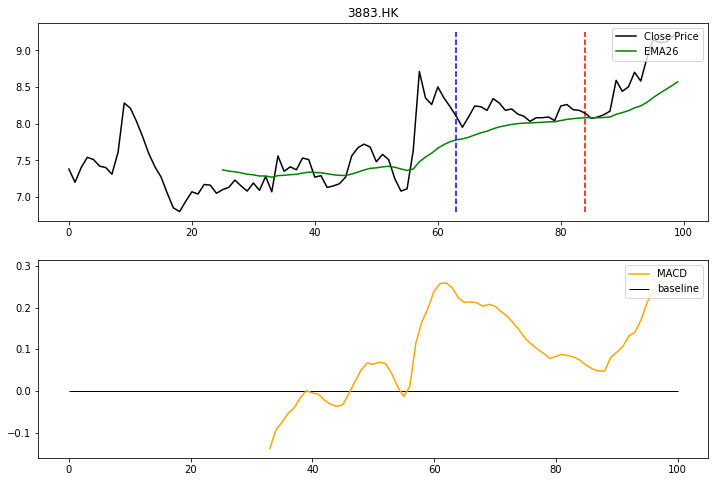

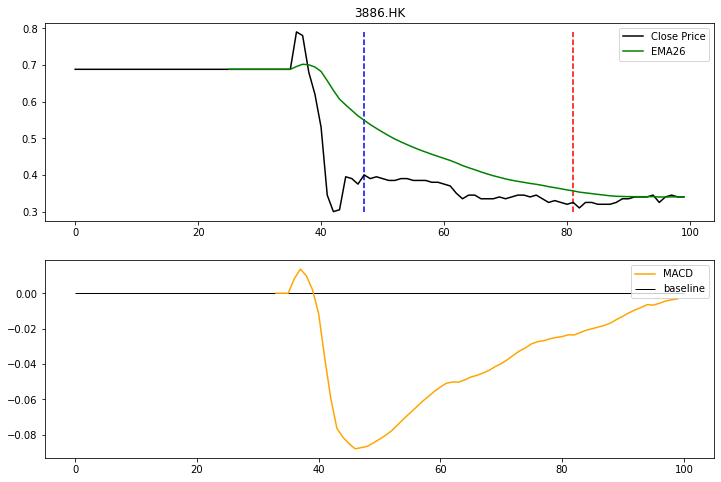

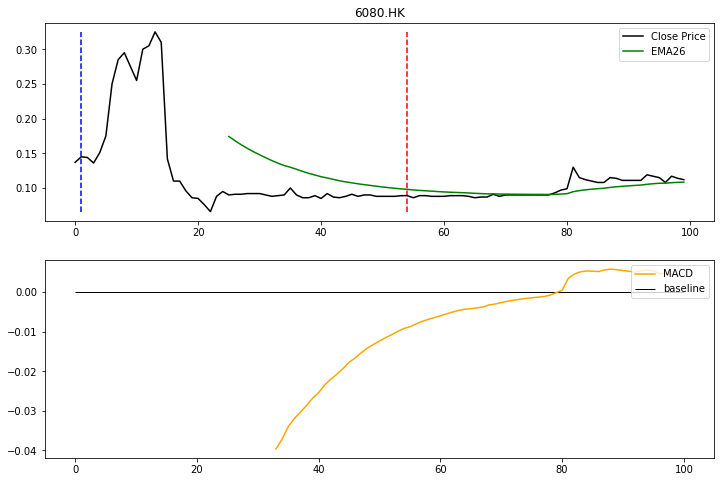

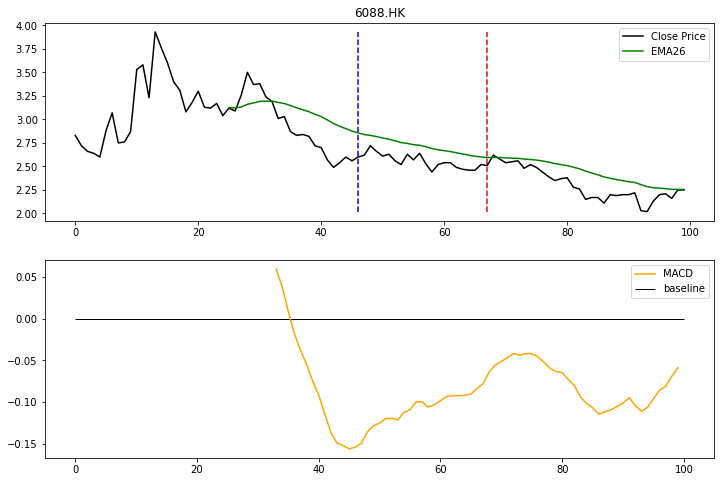

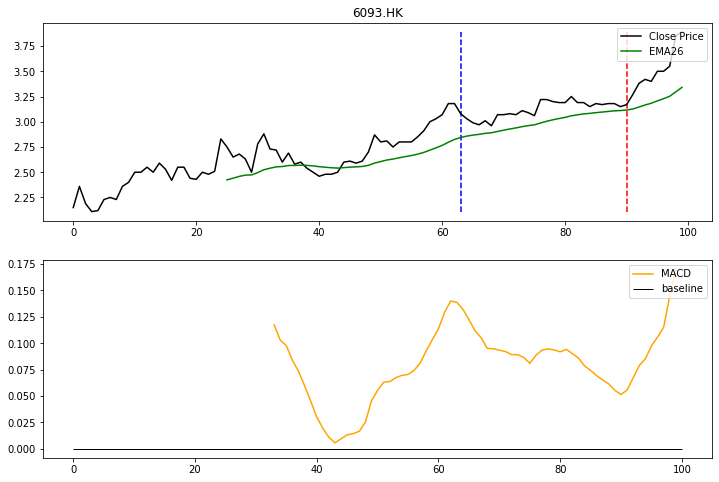

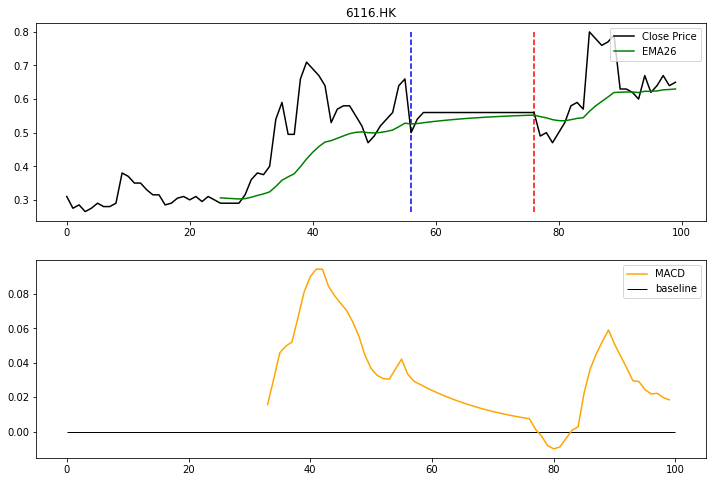

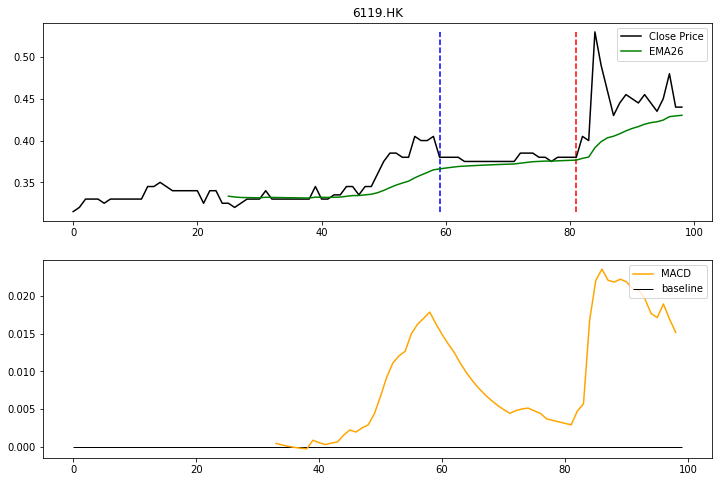

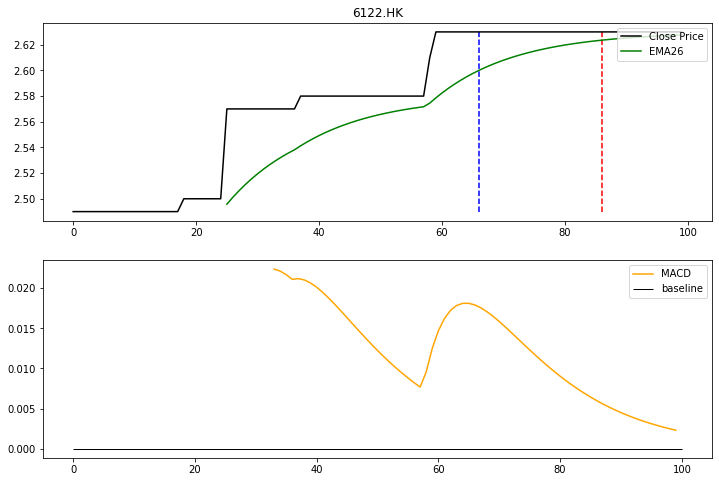

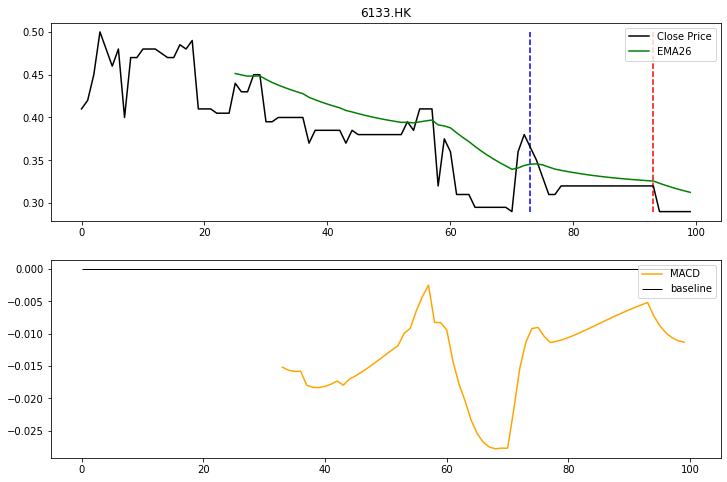

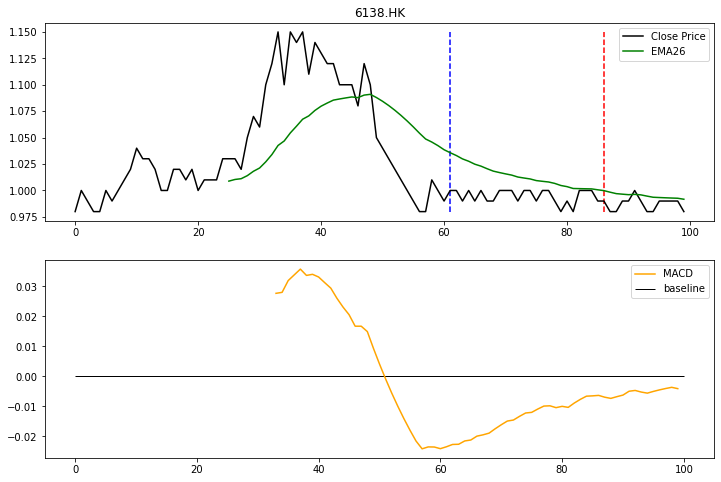

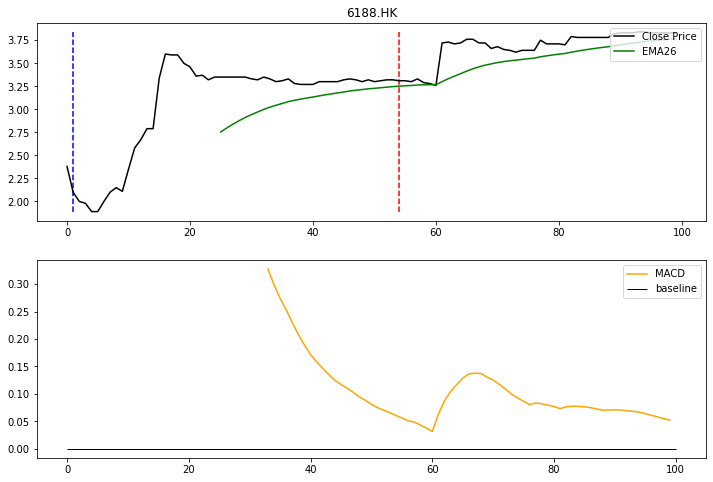

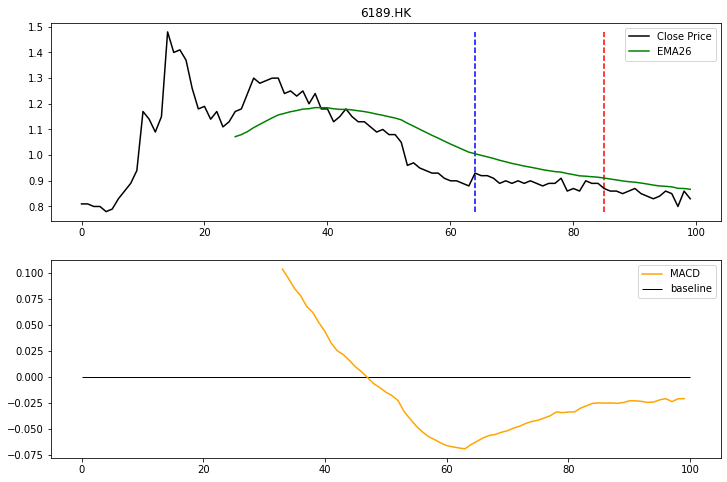

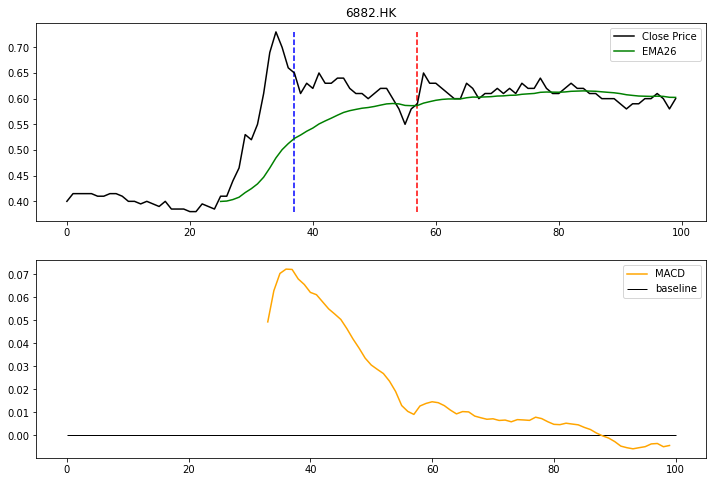

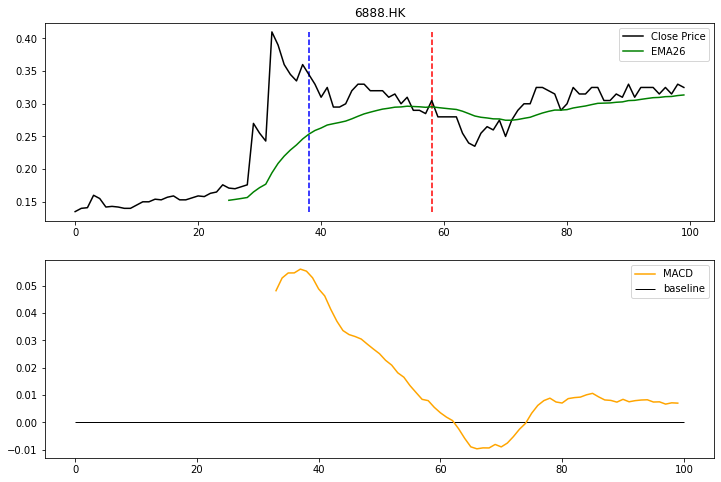

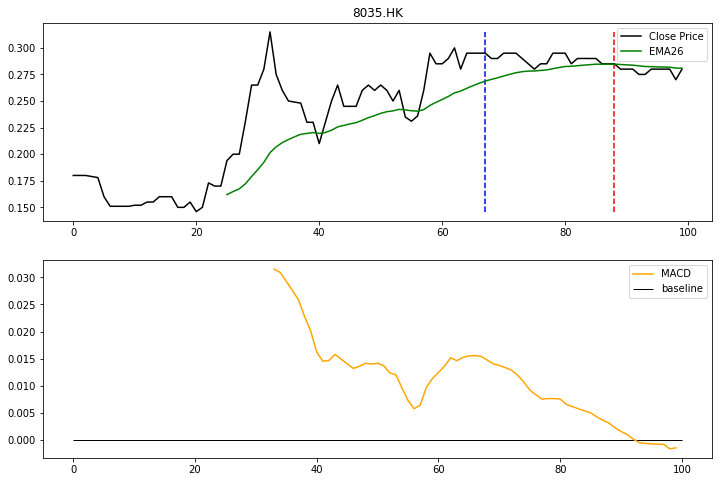

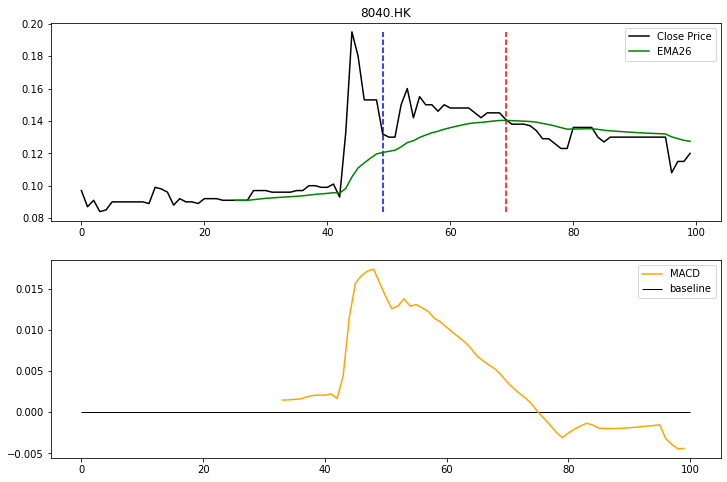

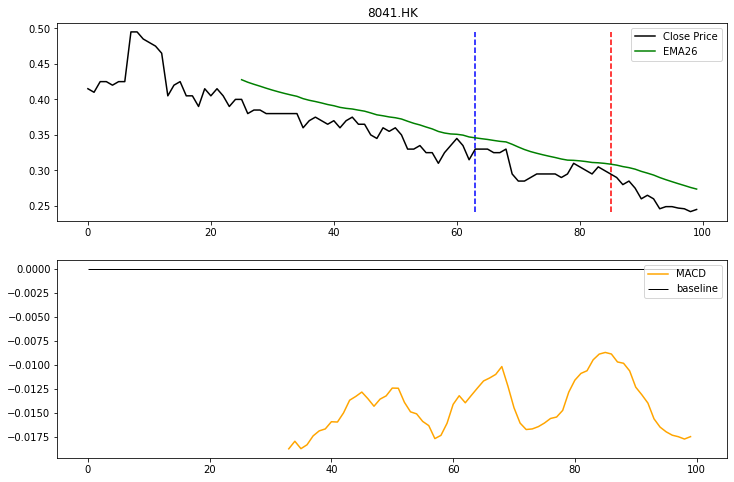

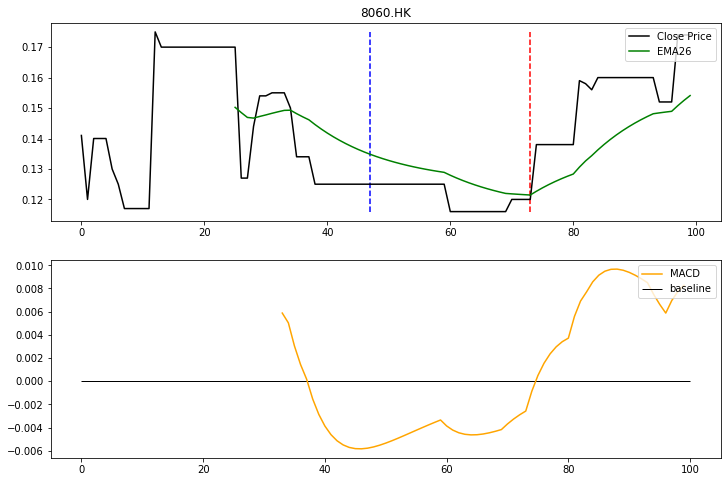

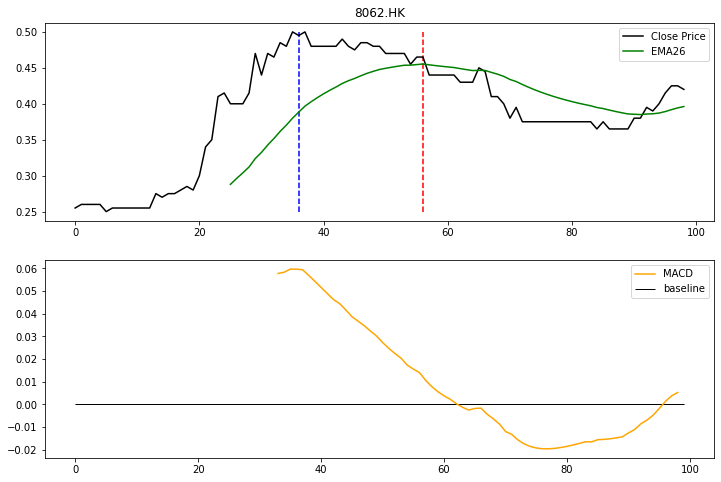

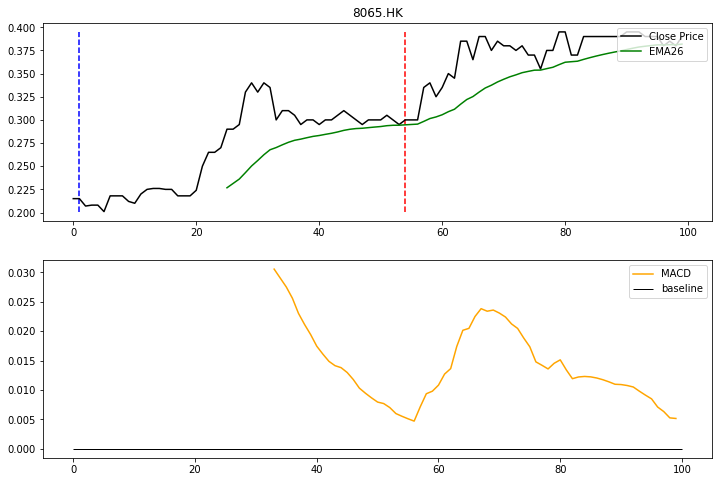

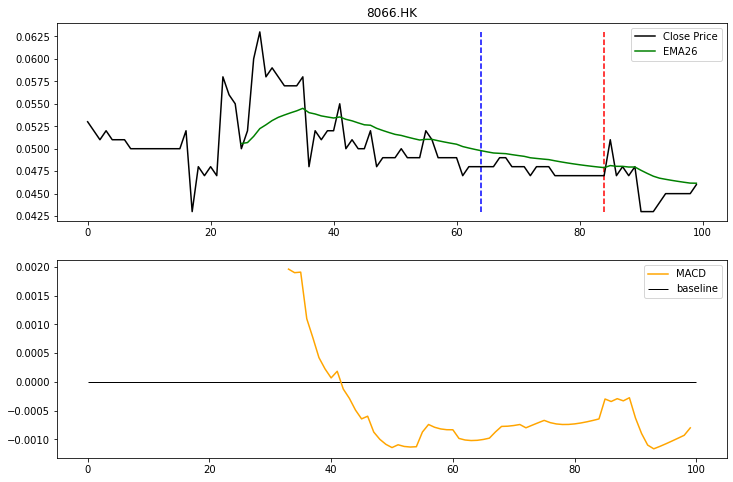

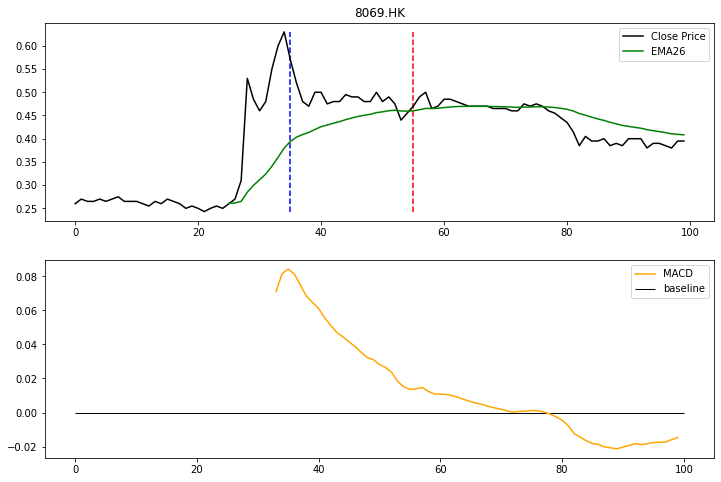

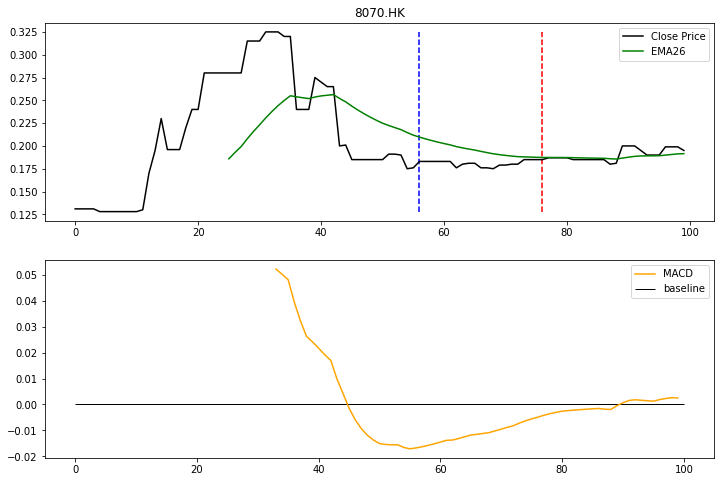

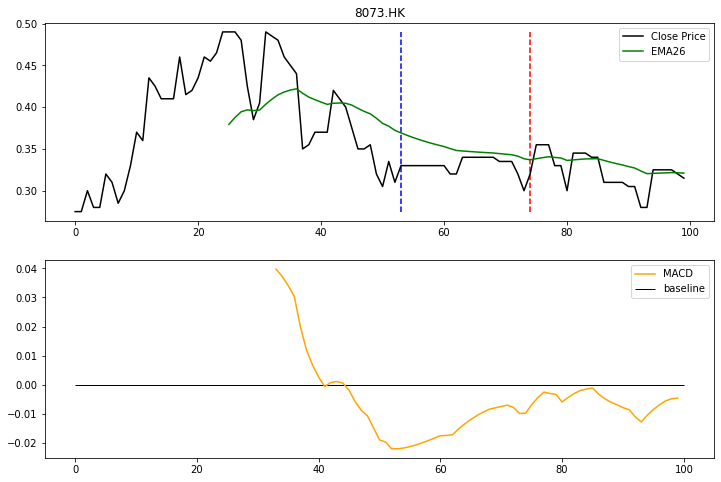

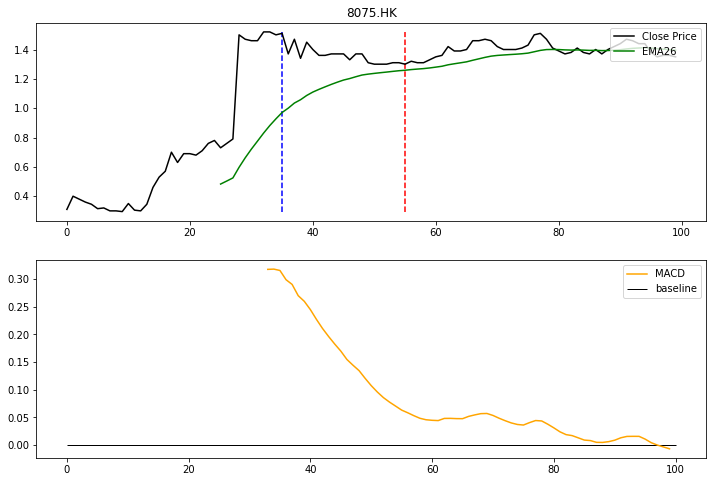

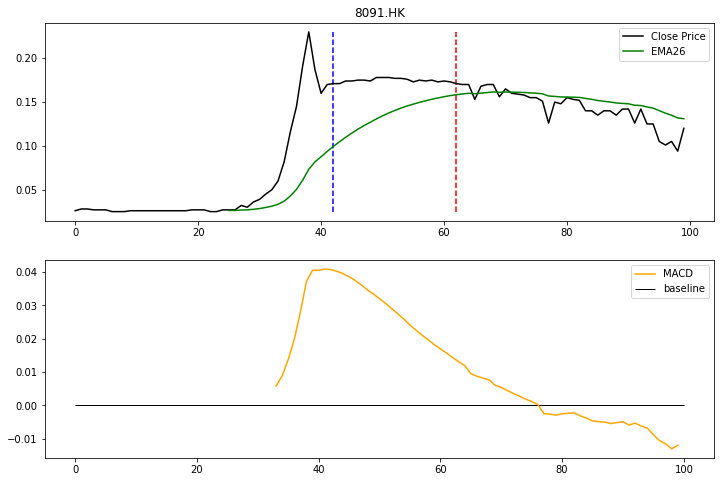

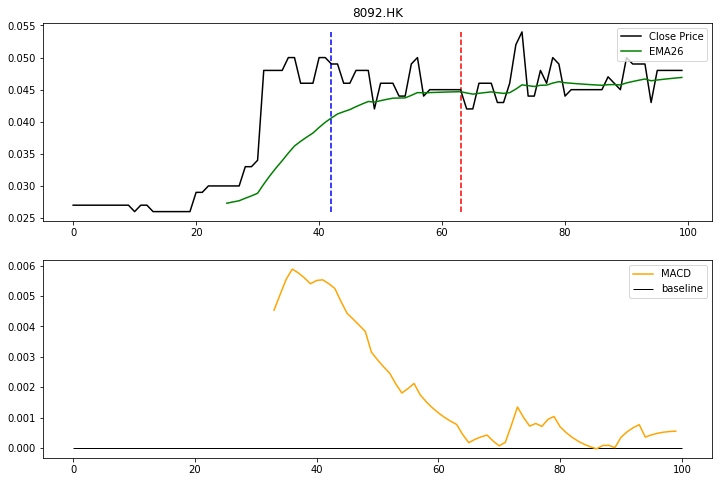

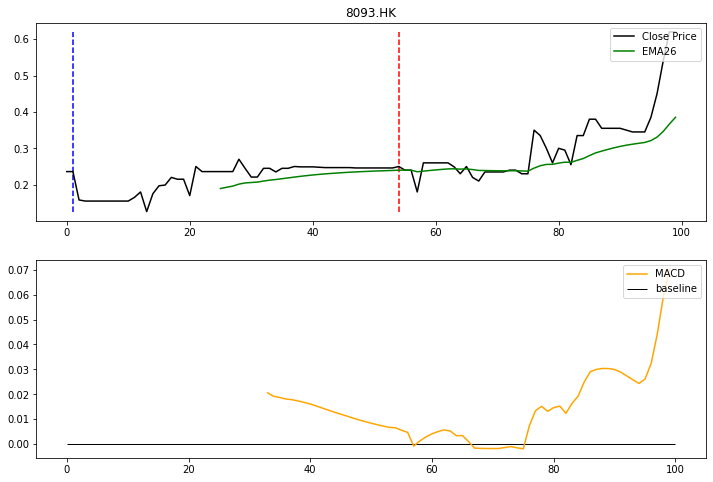

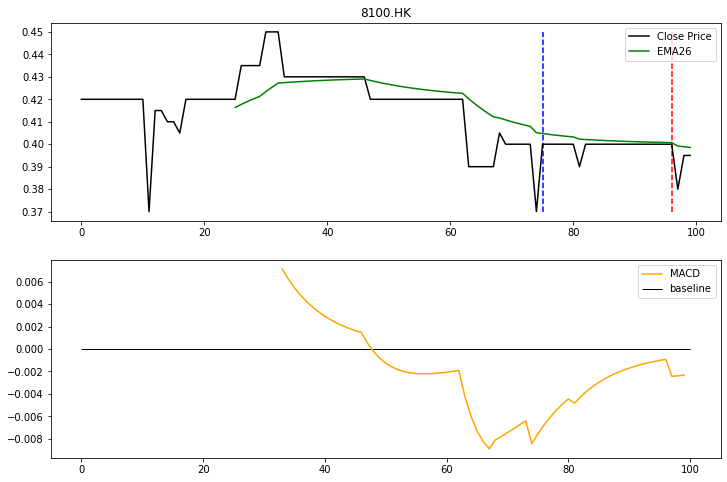

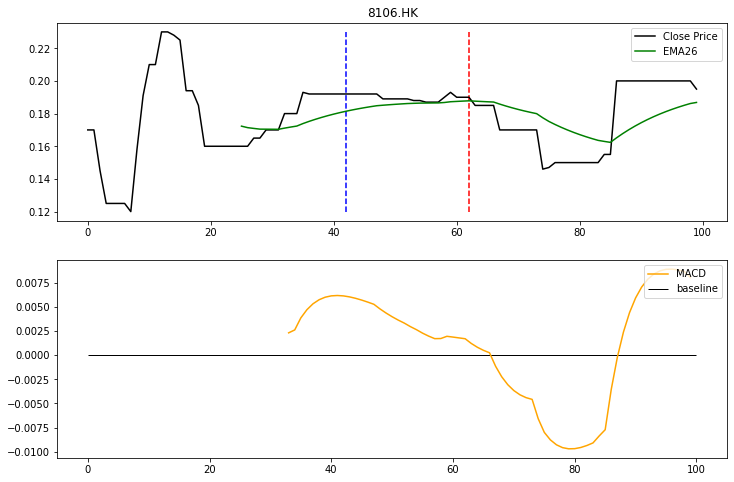

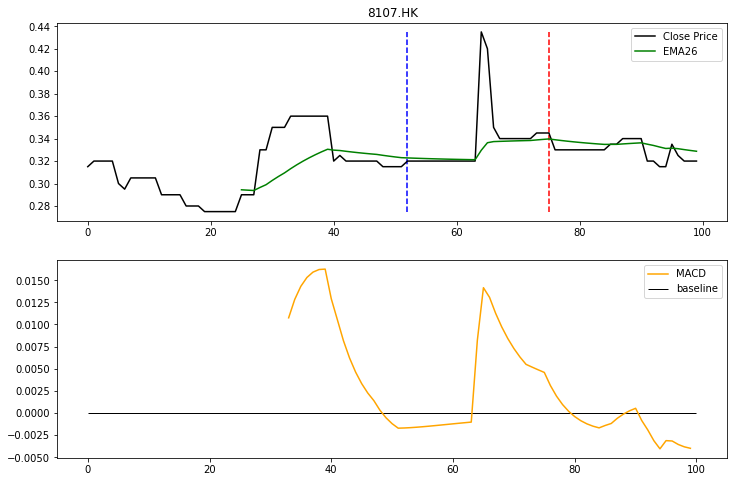

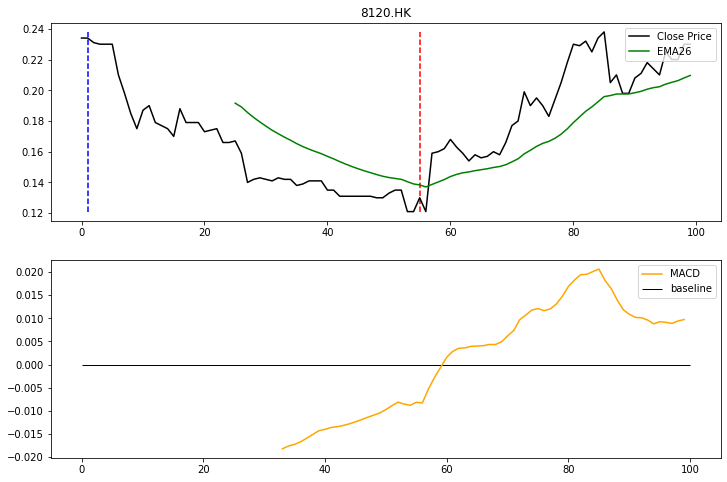

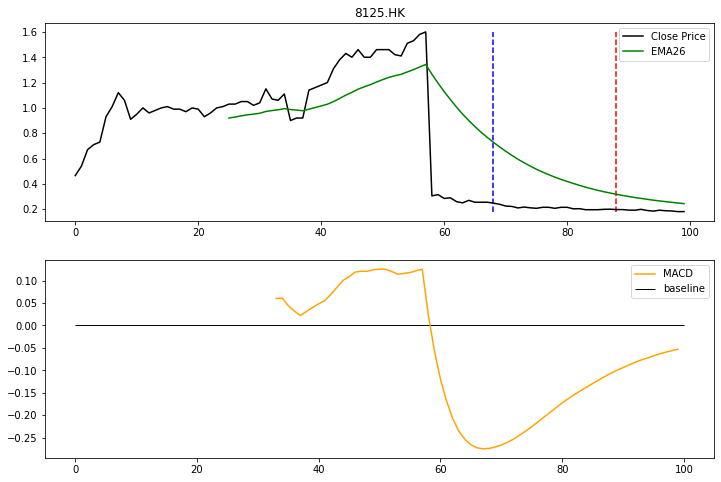

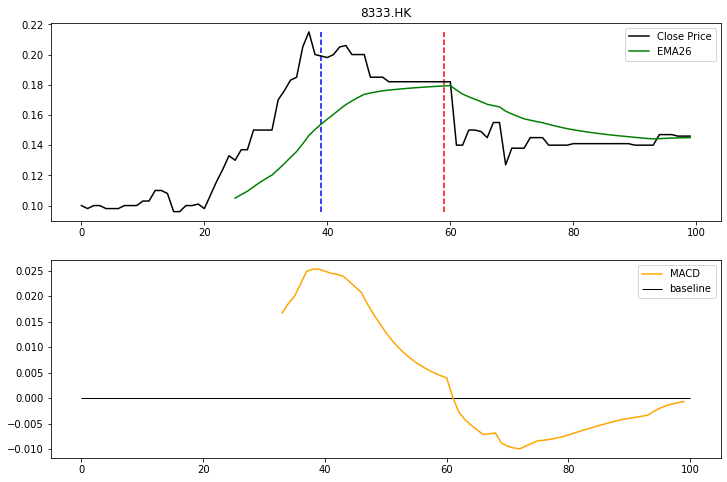

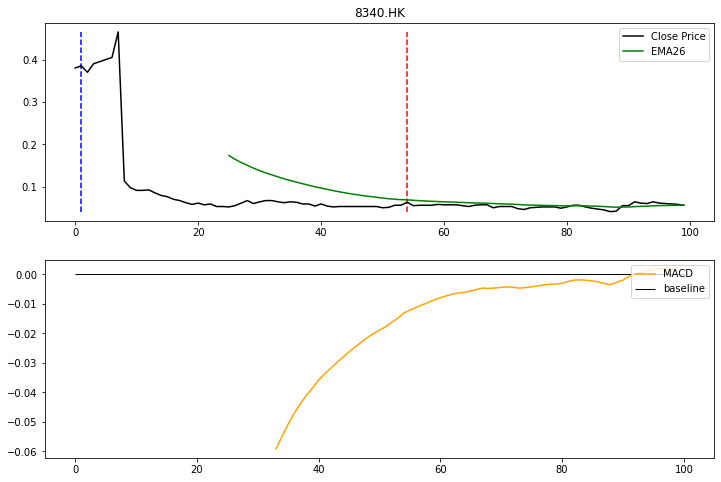

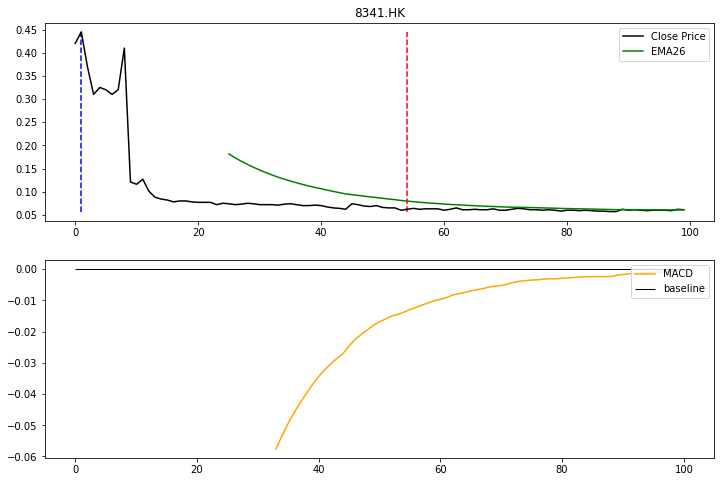

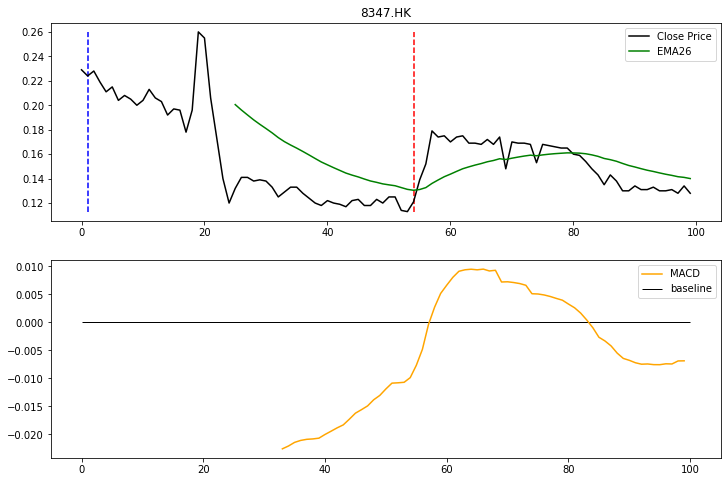

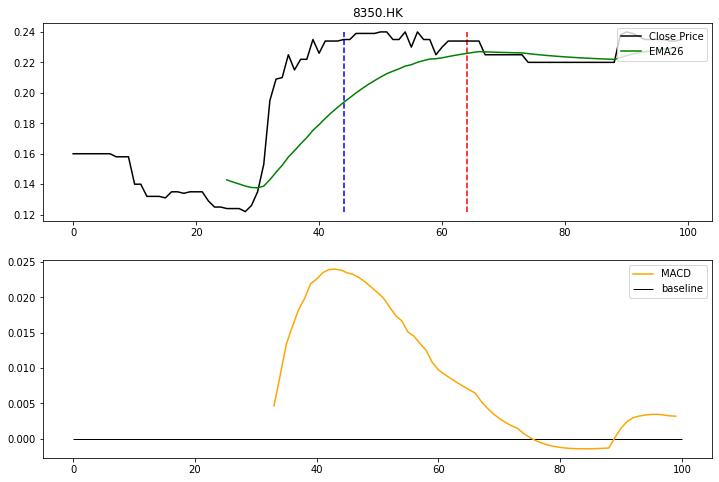

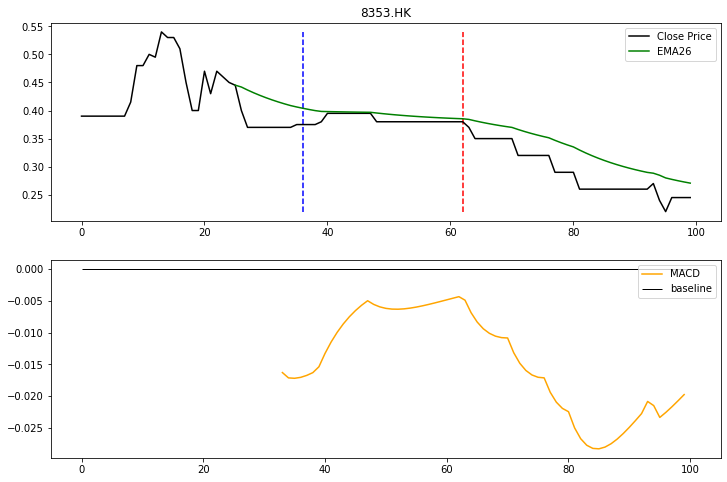

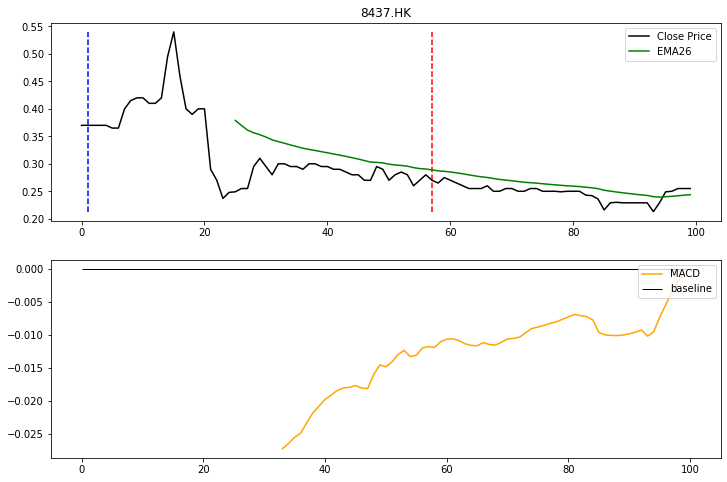

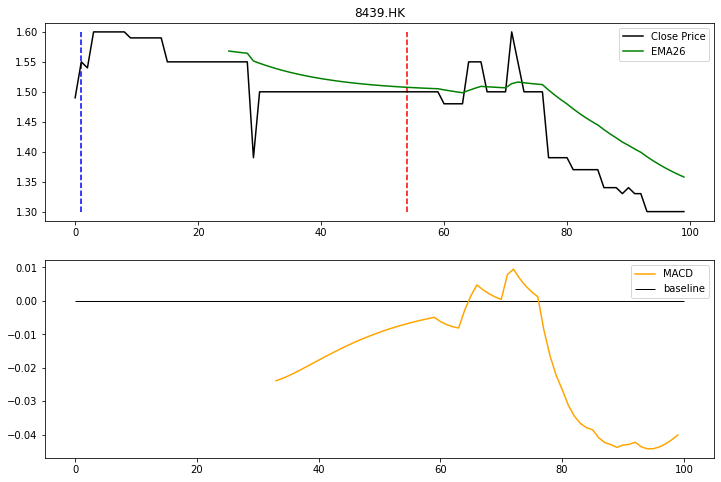

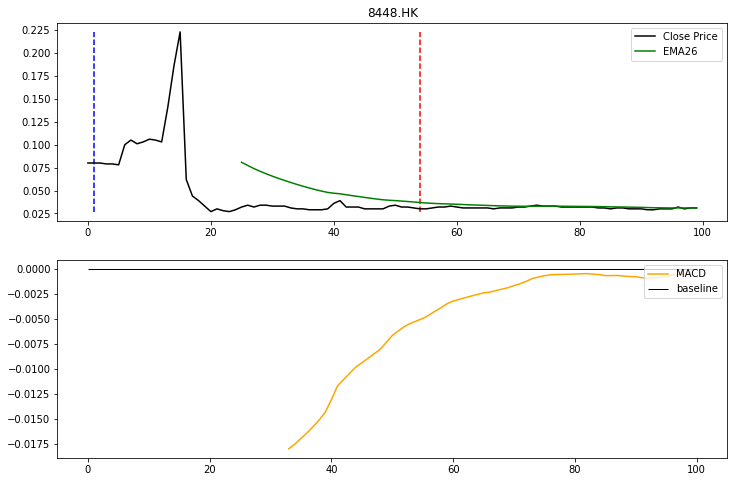

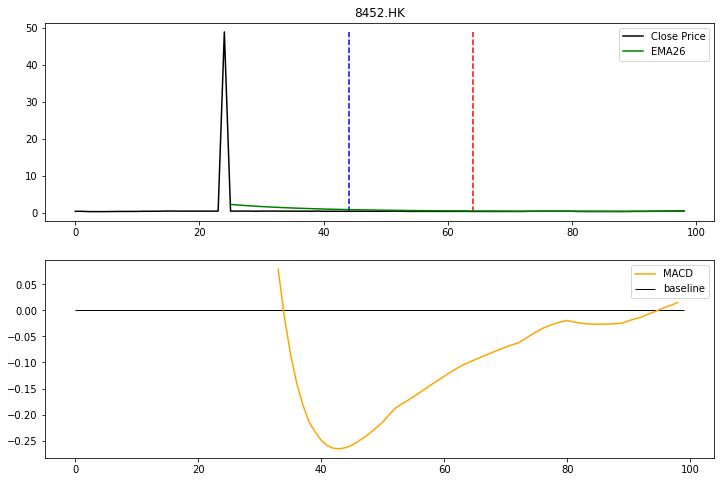

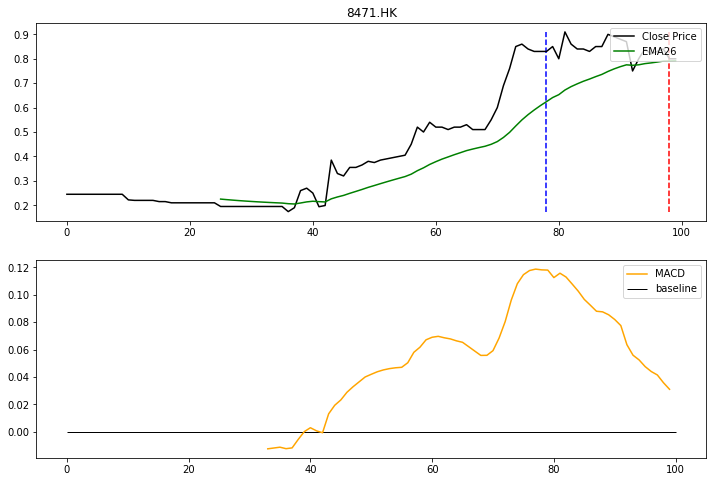

In [76]:
hkex_macd_div(2, 10000, stock_list_src, min_day=20)

In [384]:
def add_baseline(length, color="black", width=1.0, style="dashed"):
    plt.hlines(0, 0, length, color=color, linewidth=width, linestyle=style, label="baseline")

## Tesla

In [314]:
tesla_df = pandas.read_pickle("us_stock/TSLA.pkl")

In [315]:
tesla_cp = get_close_price(tesla_df)

In [357]:
tesla_macd = list(ta.MACD(tesla_cp))

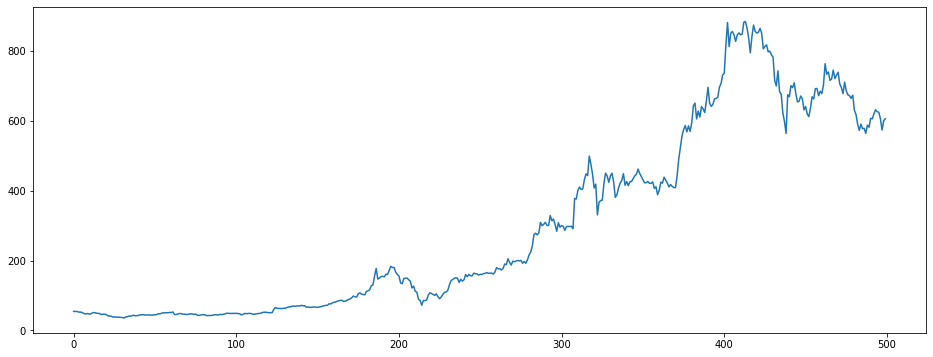

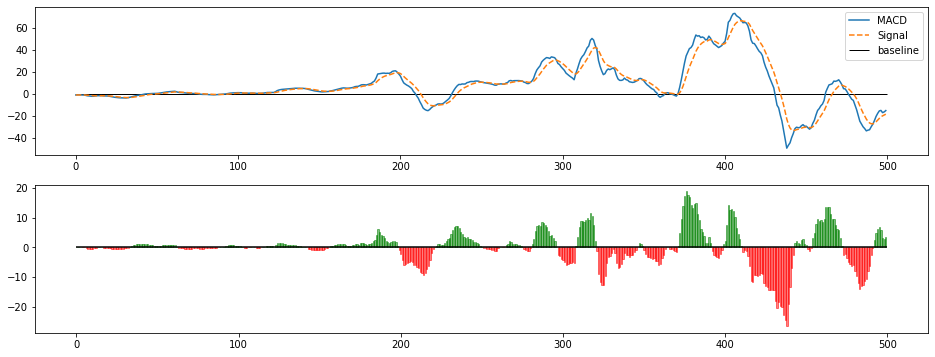

In [317]:
recent_days=500
plt.plot(tesla_cp[-recent_days:])
plot_MACD(tesla_macd[0][-recent_days:],
          tesla_macd[1][-recent_days:],
          tesla_macd[2][-recent_days:], 
          figSize=largeFigSize)

In [204]:
#Normalization
tesla_cp_norm = np.array(tesla_cp[-recent_days:])/max(tesla_cp)

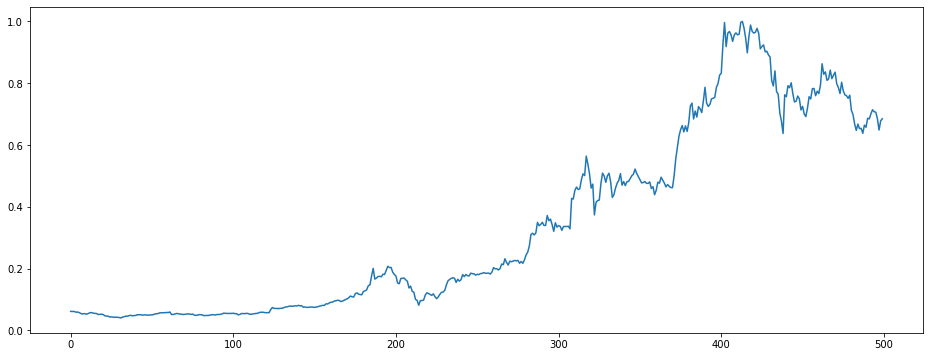

In [205]:
plt.plot(tesla_cp_norm)

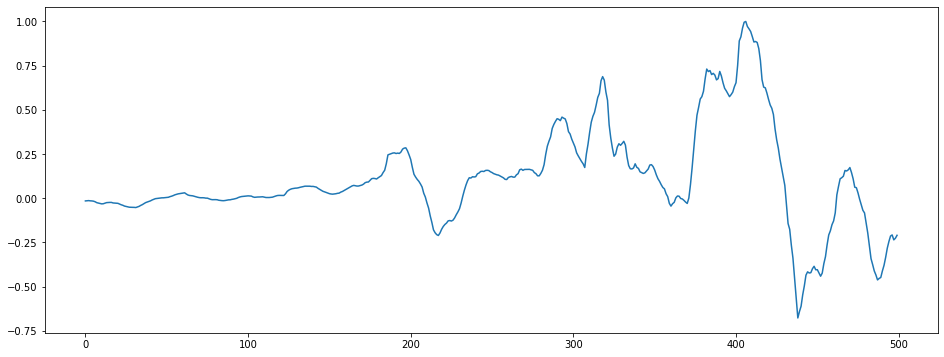

In [206]:
tesla_macd_norm = np.array(tesla_macd[0][-recent_days:])/max(tesla_macd[0][-recent_days:])
plt.plot(tesla_macd_norm)

In [310]:
min_day=15
tesla_div = list(compare_price_MACD(tesla_cp[-recent_days:], 
                                    tesla_macd[0][-recent_days:], 
                                    ema_period=ema_period, 
                                    min_day=min_day, 
                                    results="FULL"))

In [311]:
tesla_potential_div = np.array(tesla_div[1])>0.6
section_no = np.where(tesla_potential_div==True)[0]
print(len(section_no))

703


In [312]:
tesla_cp_recent = tesla_cp[-recent_days:].copy()
tesla_macd_recent = tesla_macd[0][-recent_days:].copy()
tesla_signal_recent = tesla_macd[1][-recent_days:].copy()
tesla_hist_recent = tesla_macd[2][-recent_days:].copy()

(40, 57)
True
[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


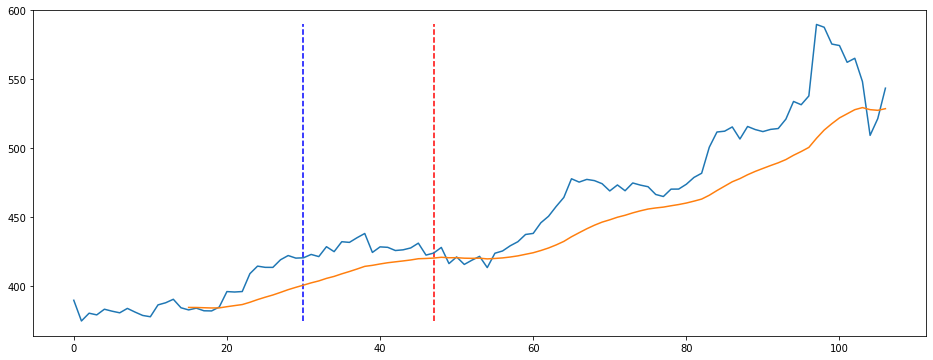

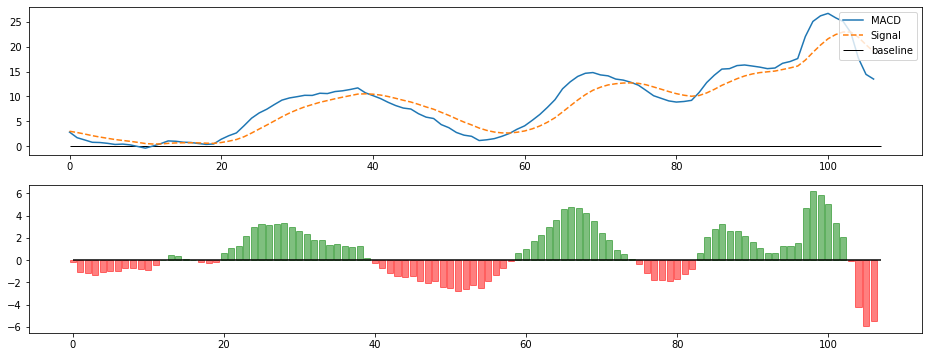

(73, 90)
True
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


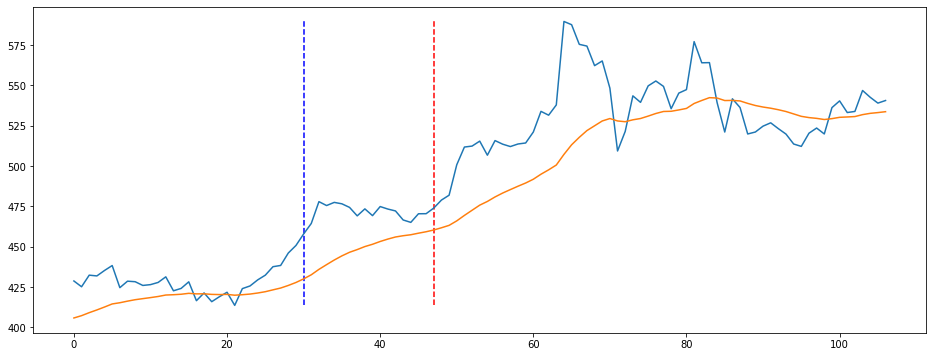

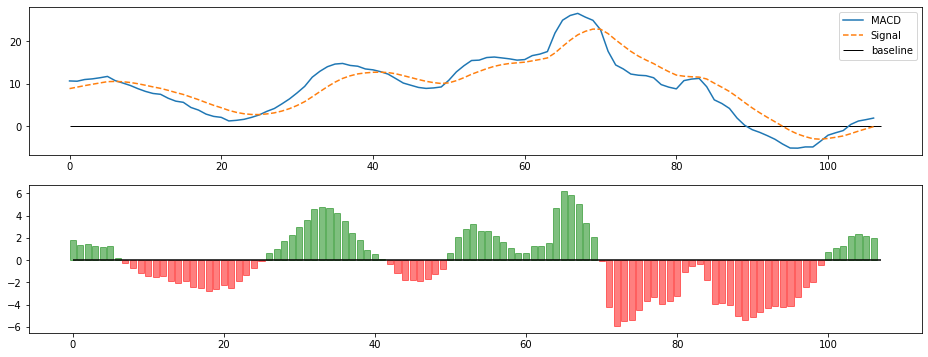

(106, 123)
True
[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


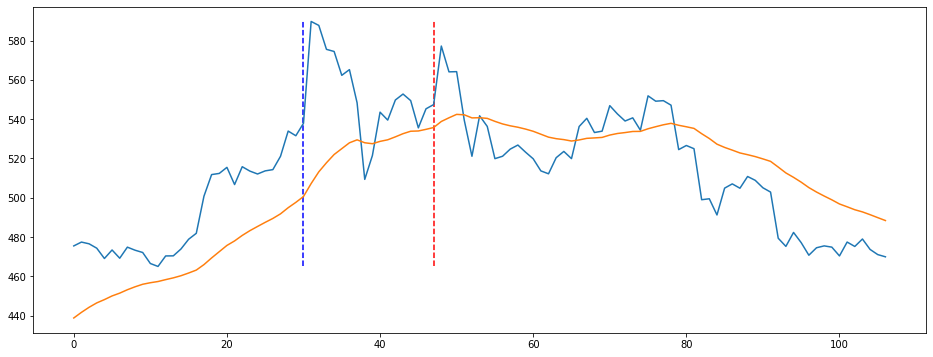

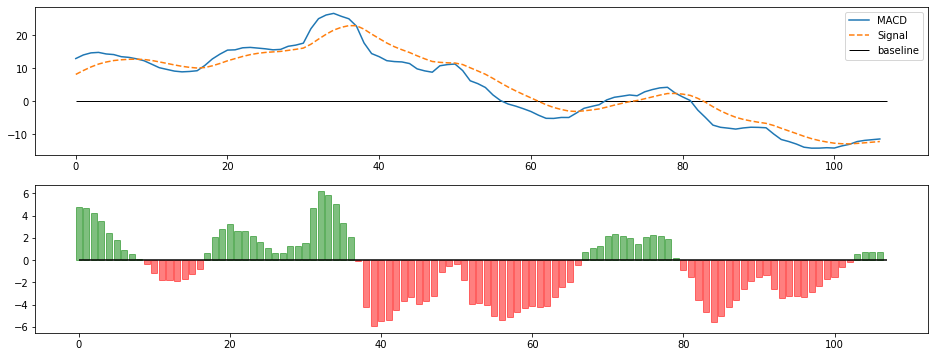

(164, 189)
False
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


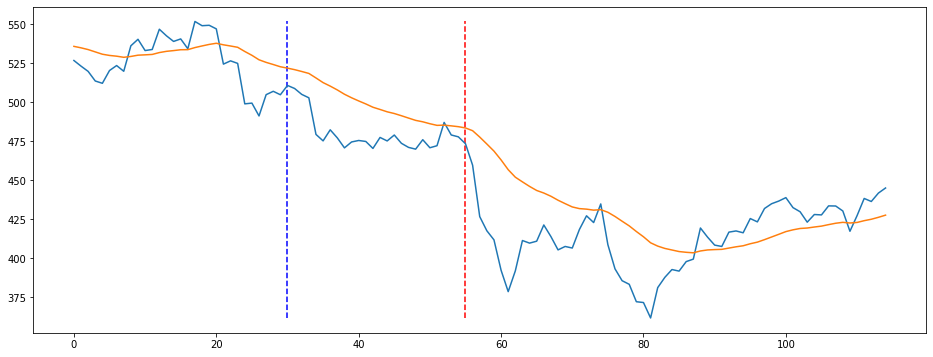

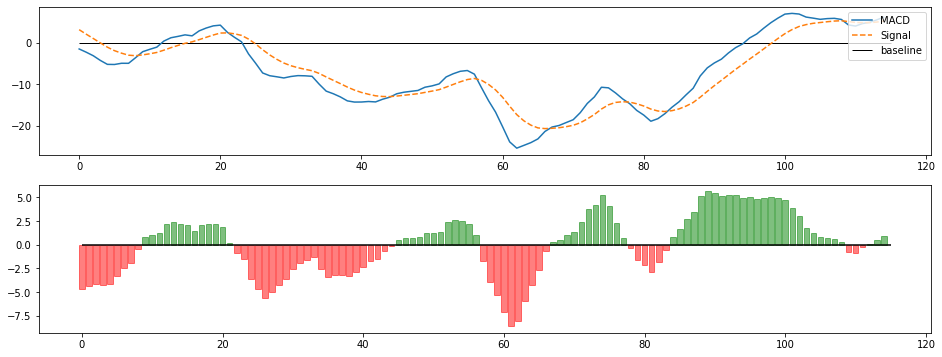

(189, 206)
False
[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


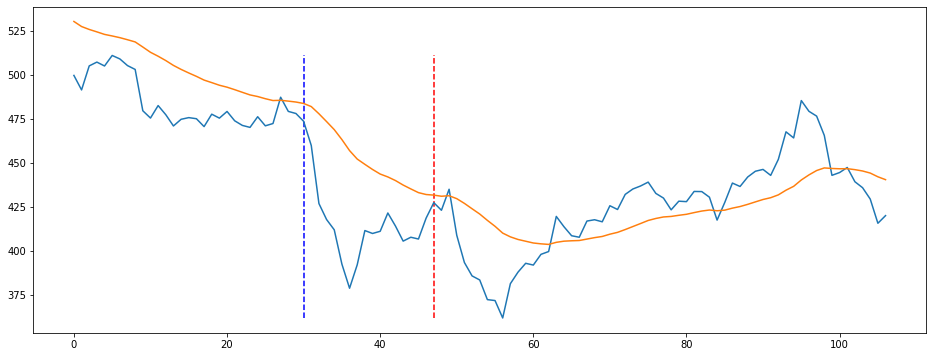

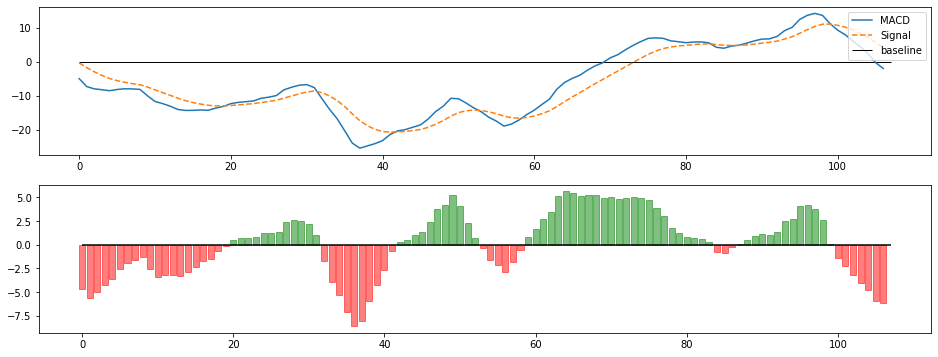

(382, 409)
True
[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


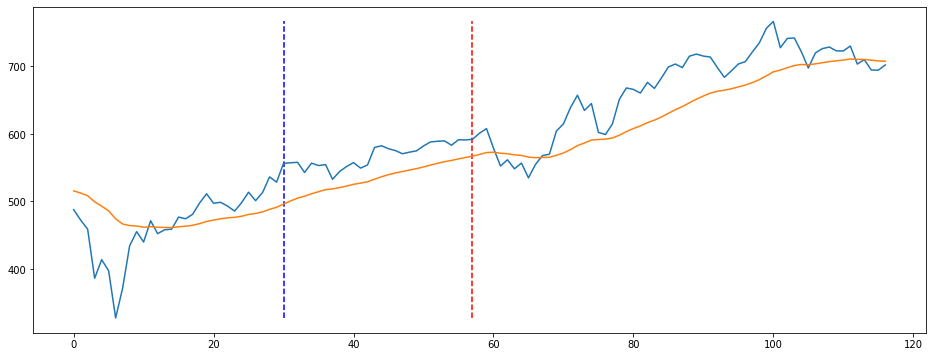

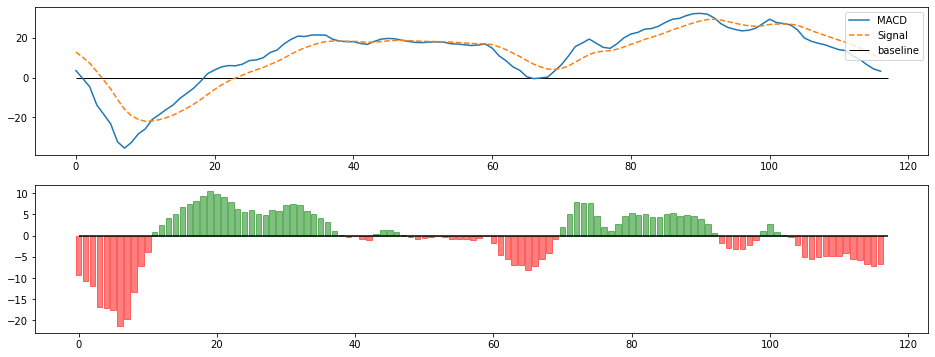

(438, 463)
True
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


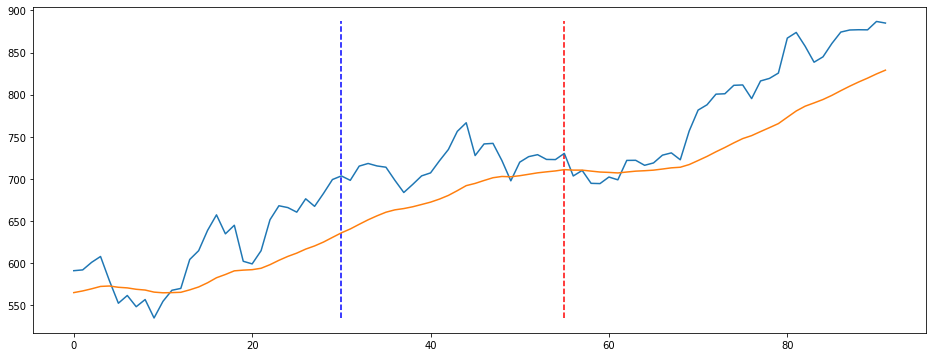

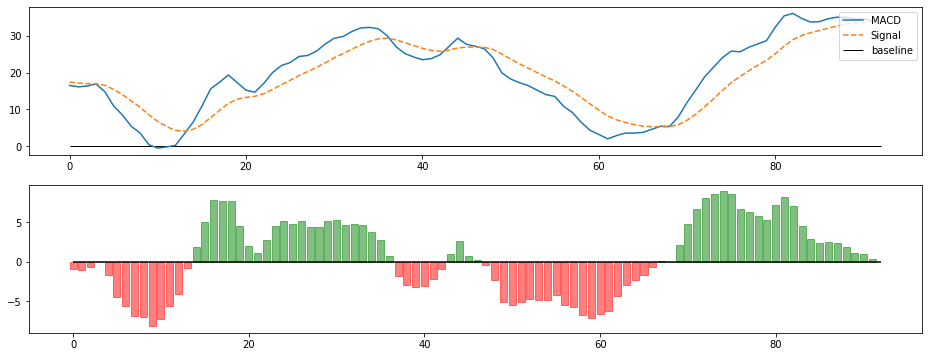

In [313]:
before=30
after=60
close_range = 10
last_pair = tesla_div[0][0]

for i in range(len(section_no)):
    period = tesla_div[0][section_no[i]]
    a = period[0]
    b = period[1]
    length = b-a
    
    if i!=0 and (abs(a-last_pair[0])<close_range or a<last_pair[1]):
        continue
    
    print(period)
    print(tesla_div[3][section_no[i]])
    print(tesla_div[2][section_no[i]])
    ema = ta.EMA(tesla_cp_recent, timeperiod=ema_period)
    plt.plot(tesla_cp_recent[a-before:b+after])
    plt.plot(ema[a-before:b+after])
    vmax = tesla_cp_recent[a-before:b+after].max()
    vmin = tesla_cp_recent[a-before:b+after].min()
    plt.vlines(before, vmin, vmax, color='b', linestyle='dashed')
    plt.vlines(before+length, vmin, vmax, color='r', linestyle='dashed')
    plt.show()
    plot_MACD(tesla_macd_recent[a-before:b+after],
              tesla_signal_recent[a-before:b+after],
              tesla_hist_recent[a-before:b+after], 
              figSize=largeFigSize)
    last_pair=(a,b)

In [234]:
tesla_div[0][0]

(1, 41)

In [237]:
section_no

(array([ 56183,  97840,  97841,  98033, 113558, 113559, 113635]),)

[25 54]


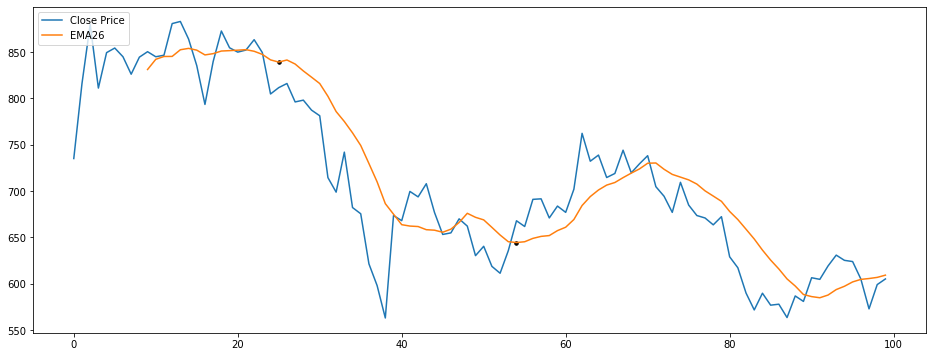

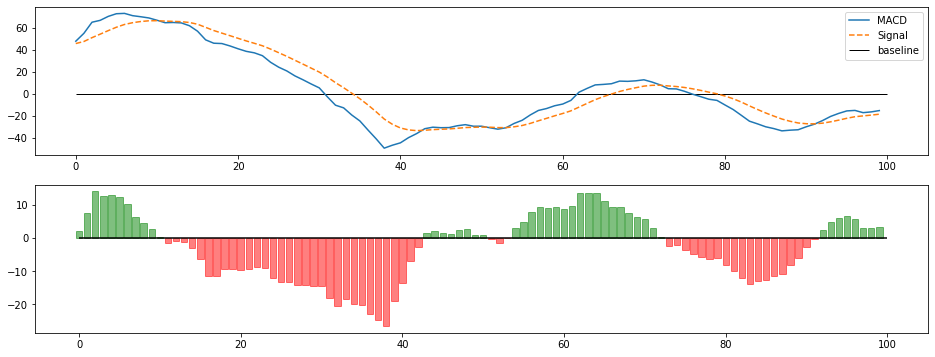

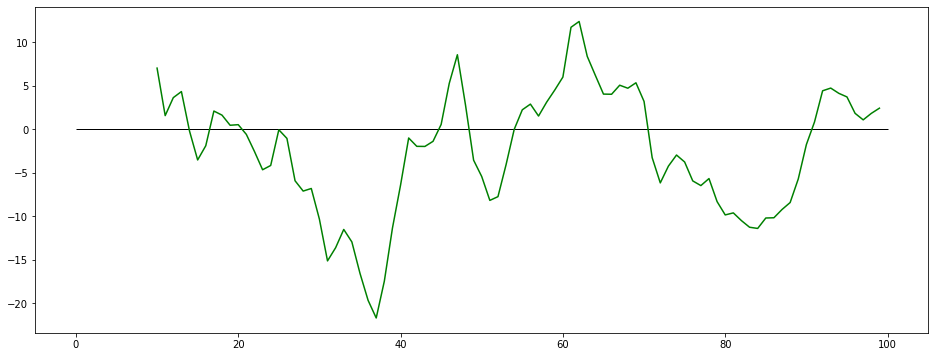

In [379]:
recent=100
tesla_cp_recent = tesla_cp[-recent:]
#tesla_ema26 = ta.EMA(tesla_cp_recent, timeperiod=30)
tesla_ema26 = ta.MA(tesla_cp_recent, timeperiod=10)
tesla_ema26_grad = np.gradient(tesla_ema26)
straddle = np.where(np.abs(tesla_ema26_grad)<=0.1)[0]
print(straddle)

plt.plot(tesla_cp_recent, label="Close Price")
plt.plot(tesla_ema26, label="EMA26")
for s in straddle:
    plt.scatter(s, tesla_ema26[s], color='k', s=12.0)
plt.legend(loc="upper left")
plt.show()

plot_MACD(tesla_macd[0][-recent:],
          tesla_macd[1][-recent:],
          tesla_macd[2][-recent:], 
          figSize=largeFigSize)

plt.hlines(0, 0, len(tesla_ema26_grad), color='k', linewidth=1.0, label="baseline")
plt.plot(tesla_ema26_grad, label='EMA26 GRAD', color='g')
plt.show()

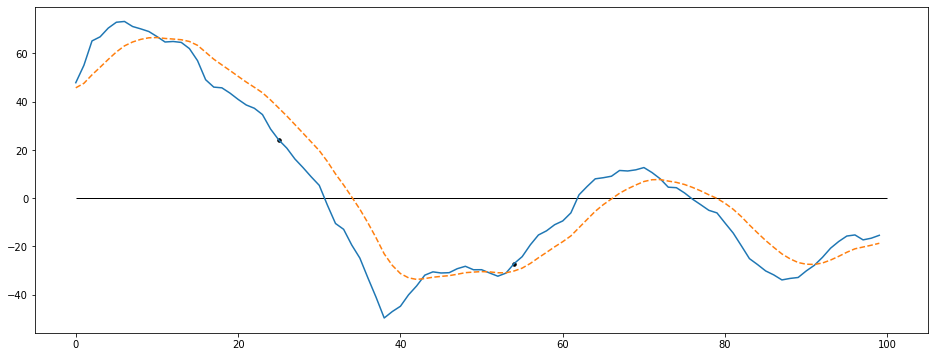

In [380]:
tesla_macd_recent = tesla_macd[0][-recent:]
tesla_signal_recent = tesla_macd[1][-recent:]
plt.plot(tesla_macd_recent)
plt.plot(tesla_signal_recent, linestyle='dashed')
for s in straddle:
    plt.scatter(s, tesla_macd_recent[s], color='k', s=12.0)
plt.hlines(0, 0, len(tesla_macd_recent), color='k', linewidth=1.0, label="baseline")

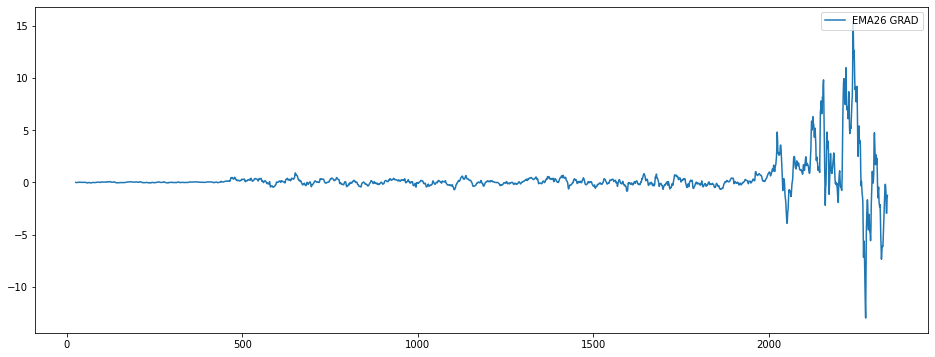

In [322]:
plt.plot(tesla_ema26_grad, label='EMA26 GRAD')
plt.legend(loc="upper right")

In [326]:
np.where(np.abs(tesla_ema26_grad)<=0.001)

(array([  26,   33,   50,   53,  271,  281,  298,  329,  383,  621, 1290,
        1456]),)

In [382]:
tesla_mom10 = ta.MOM(tesla_cp_recent, timeperiod=10)
tesla_mom18 = ta.MOM(tesla_cp_recent, timeperiod=18)

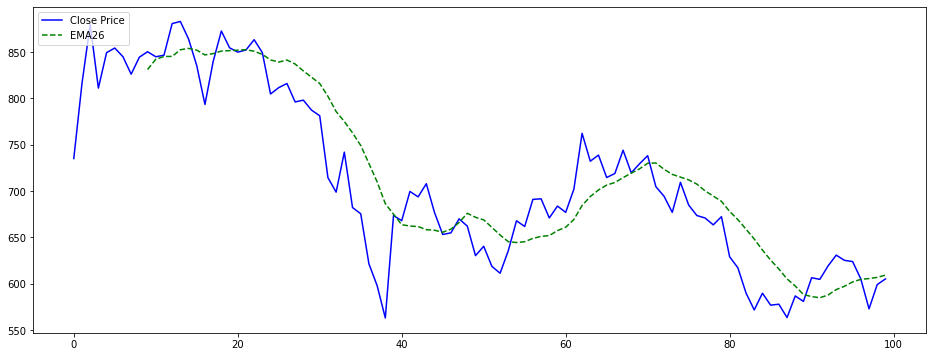

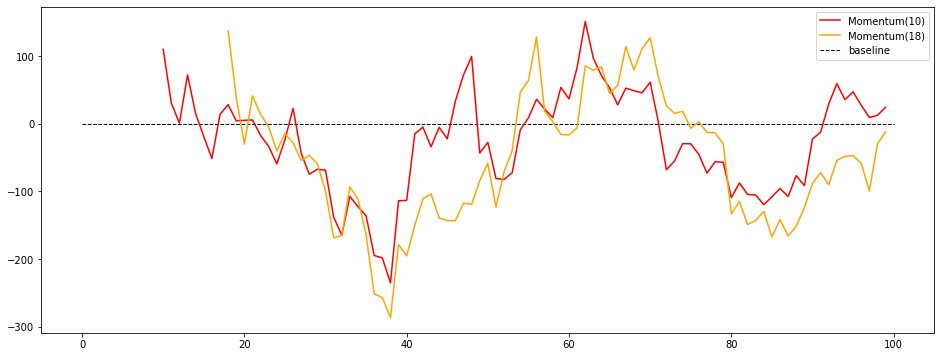

In [385]:
plt.plot(tesla_cp_recent, label="Close Price", color='b')
plt.plot(tesla_ema26, label="EMA26", color='g', linestyle='dashed')
plt.legend(loc="upper left")
plt.show()

plt.plot(tesla_mom10, label='Momentum(10)', color='r')
plt.plot(tesla_mom18, label='Momentum(18)', color='orange')
add_baseline(len(tesla_mom10))
plt.legend(loc="upper right")
plt.show()

In [386]:
hk7226_df = get_stock(symbol="7226.HK", days=100)

In [394]:
hk7226_df = stock_df_postprocess(hk7226_df)

In [395]:
hk7226_df

Date    Open    High    Low Close* Adj Close**    Volume
1   Jun 07, 2021   7.090   7.100  6.875  6.950       6.950   8918700
2   Jun 04, 2021   7.130   7.200  6.975  7.030       7.030   9358900
3   Jun 03, 2021   7.250   7.415  7.125  7.130       7.130  15823500
4   Jun 02, 2021   7.455   7.460  7.220  7.260       7.260  11901300
5   Jun 01, 2021   7.100   7.425  7.095  7.425       7.425  21301600
..           ...     ...     ...    ...    ...         ...       ...
63  Mar 05, 2021   8.175   8.540  7.805  8.230       8.230  23209200
64  Mar 04, 2021   9.200   9.280  8.650  8.725       8.725  18051401
65  Mar 03, 2021   9.600   9.760  9.240  9.685       9.685   7187900
66  Mar 02, 2021  10.000  10.300  9.475  9.525       9.525  15489600
67  Mar 01, 2021   9.400   9.665  9.300  9.580       9.580  12650500

[67 rows x 7 columns]

In [396]:
hk7226_cp = get_close_price(hk7226_df)

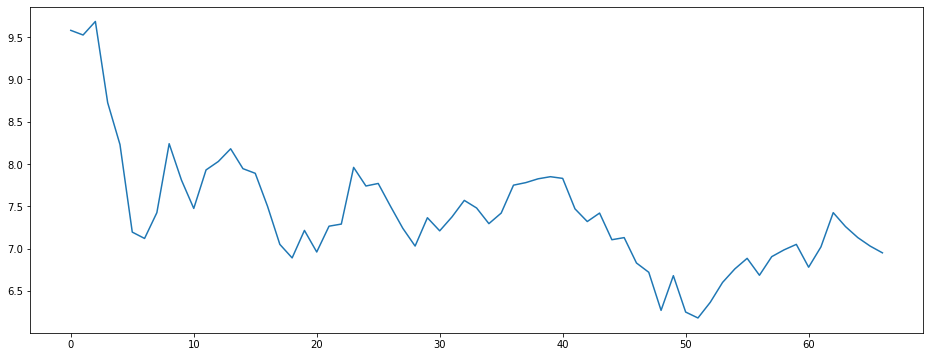

In [397]:
plt.plot(hk7226_cp)

In [398]:
hk7226_macd, hk7226_signal, hk7226_hist = ta.MACD(hk7226_cp)

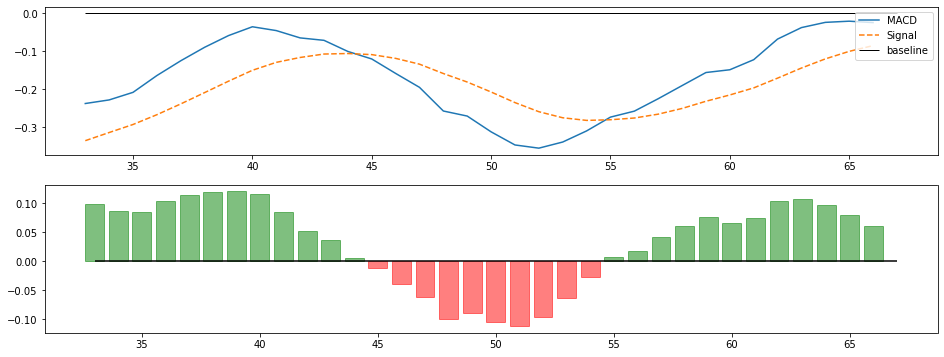

In [399]:
plot_MACD(hk7226_macd,
          hk7226_signal,
          hk7226_hist, 
          figSize=largeFigSize)

In [400]:
hk7226_div = list(compare_price_MACD(hk7226_cp, 
                                    hk7226_macd, 
                                    ema_period=26, 
                                    min_day=min_day, 
                                    results="MAX"))

In [401]:
hk7226_div

[(50, 65), 0.5, [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1], False]

In [402]:
hk7226_ema26 = ta.EMA(hk7226_cp, timeperiod=26)

In [405]:
len(hk7226_ema26)

67

In [411]:
np.sum(np.isnan(hk7226_ema26))

25

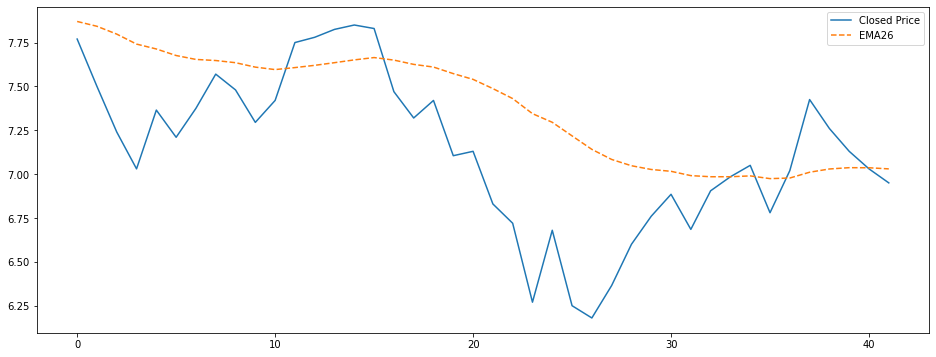

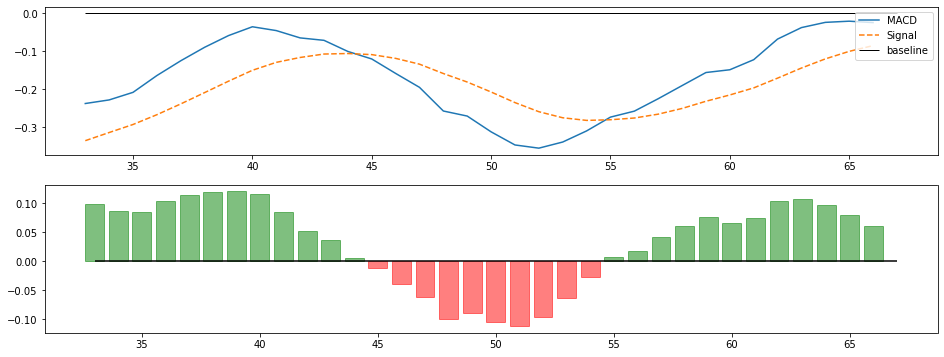

In [413]:
plt.plot(hk7226_cp[-(67-25):], label="Closed Price")
plt.plot(hk7226_ema26[-(67-25):], linestyle="dashed", label="EMA26")
plt.legend(loc="upper right")

plot_MACD(hk7226_macd,
          hk7226_signal,
          hk7226_hist, 
          figSize=largeFigSize)